In [1]:
import random
import threading
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from parameters import *
from utils import next_train, initialization, get_next_starting_Time, get_ActiveSchedule, get_df_ofPassengers, arrival_time

sa_neighbors=3
T=0  # 轻微跳跃
cooling_rate=0.95

In [2]:
df=pd.read_csv('../shenzhen_data/morning_longtime_100000(processed).csv')
df.drop_duplicates(inplace=True)
print(df.shape, df.columns)
df.sort_values(by=['time'], inplace=True)
df['time']=df['time']+2*int(stations_N*2*(skipped_saved+station_interval)) # 提前一定时间开始运营地铁，发出的第一台车跑完一圈就开始接待高峰期乘客
print(passenger_max)
df.head(2)

(10000, 7) Index(['start', 'end', 'time', 'id', 'forward', 'start_', 'end_'], dtype='object')
75


,start,end,time,id,forward,start_,end_
4936,23,13,270,94603,0,26,36
9127,2,17,270,13973,1,2,17


In [3]:
# initialization 后的StartTrain_time是上一台已经发车的列车的时间，故在while里面要新建
# df_schedule, StartTrain_time=initialization()

# while StartTrain_time<final_time:
#     StartTrain_time=get_next_starting_Time(get_ActiveSchedule(df_schedule, StartTrain_time)) 
#     temp_schedule=next_train(stop_stations=list(np.ones(stations_N*2).astype(int)), StartTrain_time=StartTrain_time)
#     df_schedule=pd.concat([df_schedule, temp_schedule])
# df_schedule.reset_index(drop=True, inplace=True)
# df_schedule
df_schedule=pd.read_csv('../result/df_schedule_al2.csv')
print(df_schedule.shape, df_schedule.columns)
df_schedule.head(5)

(123, 101) Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '41_stop', '42_stop', '43_stop', '44_stop', '45_stop', '46_stop',
       '47_stop', '48_stop', '49_stop', 'restart_time'],
      dtype='object', length=101)


,0,1,2,3,4,5,6,7,8,9,...,41_stop,42_stop,43_stop,44_stop,45_stop,46_stop,47_stop,48_stop,49_stop,restart_time
0,0.0,2.7,5.4,8.1,10.8,13.5,16.2,18.9,21.6,24.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,135.0
1,5.0,7.7,10.4,13.1,15.8,18.5,21.2,23.9,26.6,29.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,140.0
2,10.0,12.7,15.4,18.1,20.8,23.5,26.2,28.9,31.6,34.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,145.0
3,15.0,17.7,20.4,23.1,25.8,28.5,31.2,33.9,36.6,39.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,150.0
4,20.0,22.7,25.4,28.1,30.8,33.5,36.2,38.9,41.6,44.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,155.0


In [4]:
def new_neighbor_schedule(df_schedule,sa_neighbors=sa_neighbors):
    random_indices = [(random.randint(train_N, len(df_schedule)-2), random.choice(column_names_with_stop)) for _ in range(sa_neighbors)] #数据去头去尾
    for index, col in random_indices:
        df_schedule.at[index, col] = random.choice([0, 1])
    df_schedule_temp, StartTrain_time=initialization()
    init_n=len(df_schedule_temp)
    assert train_N==init_n
    for i in range(train_N, len(df_schedule)):
        StartTrain_time=get_next_starting_Time(get_ActiveSchedule(df_schedule_temp, StartTrain_time)) 
        temp_schedule=next_train(stop_stations=list(df_schedule[column_names_with_stop].iloc[i]), 
                                StartTrain_time=StartTrain_time)
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
    df_schedule_temp.reset_index(drop=True, inplace=True)
    df_schedule=df_schedule_temp.copy()

    return df_schedule

def heat_func(delta, T):
    if delta<=0:
        return 1
    else:
        return np.e**(-delta/T)        
    

In [5]:
###
print(new_neighbor_schedule(df_schedule.copy(),3).sum().sum())
df_schedule.sum().sum()


2296988.6999999965


2296988.6999999965

In [6]:
def calculating_waiting_time_for_SA(df_schedule, df,result_t=None, result_df=None):
    waiting_time=0
    waiting_time_list=[]
    station_interval_list=[]
    df_changing=df.copy()
    df_schedule_temp=pd.DataFrame()
    for i in range(df_schedule.shape[0]):
        temp_schedule=df_schedule.iloc[[i]]
        stop_stations=temp_schedule.T.reset_index()[stations_N*2:stations_N*4][i].values
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
        df_drop, _=get_df_ofPassengers(next_schedule_Ref=temp_schedule, stop_stations=stop_stations.copy(), df_changing=df_changing.copy()) # 新车把旧车接走了
        if len(df_drop)!=0:
            waiting_time_list.append(df_drop.apply(lambda row: arrival_time(row['start_'], row['end_'], row['time'],df_schedule=temp_schedule)[1], axis=1))
            waiting_time+=waiting_time_list[-1].sum()
            station_interval_list.append(list(df_drop['end_']-df_drop['start_']))

        df_changing=pd.merge(df_changing, df_drop, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
        # print("stop_stations:", stop_stations)

    #
    while df_changing.shape[0]>0:
        print('a new shcedule is generated')
        stop_stations=list(np.ones(stations_N*2).astype(int))
        StartTrain_time=df_schedule_temp['restart_time'].iloc[-train_N:].min()  # 已经在运行列车最早回来的值
        temp_schedule=next_train(stop_stations=stop_stations, StartTrain_time=StartTrain_time)
        df_schedule_temp=pd.concat([df_schedule_temp, temp_schedule])
        df_schedule_temp.reset_index(drop=True, inplace=True)
        df_drop, _=get_df_ofPassengers(next_schedule_Ref=temp_schedule, stop_stations=stop_stations.copy(), df_changing=df_changing.copy()) # 新车把旧车接走了
        if len(df_drop)!=0:
            waiting_time_list.append(df_drop.apply(lambda row: arrival_time(row['start_'], row['end_'], row['time'],df_schedule=temp_schedule)[1], axis=1))
            waiting_time+=waiting_time_list[-1].sum()
            station_interval_list.append(list(df_drop['end_']-df_drop['start_']))

        df_changing=pd.merge(df_changing, df_drop, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
#         print("stop_stations:", stop_stations)
        
    df_schedule_temp.reset_index(drop=True, inplace=True)
    if result_t!=None:
        result_t.append(waiting_time)
        result_df.append(df_schedule)
    return waiting_time, df_schedule_temp

In [7]:
costTime_best, df_schedule=calculating_waiting_time_for_SA(df_schedule=df_schedule.copy(), df=df.copy())
df_schedule=df_schedule
ref_time=costTime_best
result=[]
for i in tqdm(range(3000)):
    df_schedule_temp=new_neighbor_schedule(df_schedule.copy())
    costTime_temp,df_schedule_temp = calculating_waiting_time_for_SA(df_schedule=df_schedule_temp.copy(), df=df.copy())
    delta=costTime_best-costTime_temp
    print(df_schedule.shape[0], df_schedule_temp.shape[0])
    if delta>0:
        costTime_best=costTime_temp
        df_schedule=df_schedule_temp.copy()
    else:
        pass
    result.append(costTime_temp)
    print('original_time:', ref_time, 'optimization_time:', costTime_temp)

  0%|          | 1/3000 [00:24<20:40:26, 24.82s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276601.8999999891


  0%|          | 2/3000 [00:49<20:40:31, 24.83s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276349.2999999892


  0%|          | 3/3000 [01:14<20:51:18, 25.05s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276482.29999998916


  0%|          | 4/3000 [01:40<20:52:29, 25.08s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276371.2999999893


  0%|          | 5/3000 [02:05<20:48:56, 25.02s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276468.89999998925


  0%|          | 6/3000 [02:30<20:51:24, 25.08s/it]

123 123
original_time: 276903.29999998916 optimization_time: 277012.8999999892


  0%|          | 7/3000 [02:55<20:51:33, 25.09s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276797.69999998936


  0%|          | 8/3000 [03:20<20:49:33, 25.06s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276399.89999998914


  0%|          | 9/3000 [03:45<20:48:18, 25.04s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276346.69999998936


  0%|          | 10/3000 [04:10<20:47:34, 25.04s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276536.4999999893


  0%|          | 11/3000 [04:35<20:51:51, 25.13s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276280.8999999894


  0%|          | 12/3000 [05:00<20:45:56, 25.02s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276359.29999998934


  0%|          | 13/3000 [05:25<20:41:37, 24.94s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276253.49999998935


  0%|          | 14/3000 [05:50<20:42:50, 24.97s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276303.2999999894


  0%|          | 15/3000 [06:15<20:46:10, 25.05s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276252.8999999893


  1%|          | 16/3000 [06:40<20:42:58, 24.99s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276252.8999999893


  1%|          | 17/3000 [07:05<20:46:27, 25.07s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276220.69999998936


  1%|          | 18/3000 [07:30<20:48:02, 25.11s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276568.4999999892


  1%|          | 19/3000 [07:55<20:45:30, 25.07s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276233.0999999893


  1%|          | 20/3000 [08:20<20:45:34, 25.08s/it]

a new shcedule is generated
123 124
original_time: 276903.29999998916 optimization_time: 276251.6999999893


  1%|          | 21/3000 [08:45<20:45:35, 25.09s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276163.6999999893


  1%|          | 22/3000 [09:10<20:41:28, 25.01s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276163.6999999893


  1%|          | 23/3000 [09:36<20:44:23, 25.08s/it]

123 123
original_time: 276903.29999998916 optimization_time: 275798.49999998923


  1%|          | 24/3000 [10:01<20:50:08, 25.20s/it]

123 123
original_time: 276903.29999998916 optimization_time: 275987.69999998924


  1%|          | 25/3000 [10:26<20:51:38, 25.24s/it]

123 123
original_time: 276903.29999998916 optimization_time: 275798.49999998923


  1%|          | 26/3000 [10:51<20:48:48, 25.19s/it]

123 123
original_time: 276903.29999998916 optimization_time: 278770.69999998924


  1%|          | 27/3000 [11:16<20:42:59, 25.09s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276575.6999999893


  1%|          | 28/3000 [11:41<20:43:40, 25.11s/it]

123 123
original_time: 276903.29999998916 optimization_time: 276078.2999999892


  1%|          | 29/3000 [12:06<20:42:07, 25.08s/it]

123 123
original_time: 276903.29999998916 optimization_time: 275776.49999998923


  1%|          | 30/3000 [12:32<20:41:43, 25.09s/it]

a new shcedule is generated
123 124
original_time: 276903.29999998916 optimization_time: 275758.09999998927


  1%|          | 31/3000 [12:57<20:44:08, 25.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 276877.89999998925


  1%|          | 32/3000 [13:22<20:50:18, 25.28s/it]

124 124
original_time: 276903.29999998916 optimization_time: 277099.89999998925


  1%|          | 33/3000 [13:48<20:55:44, 25.39s/it]

124 124
original_time: 276903.29999998916 optimization_time: 277805.4999999893


  1%|          | 34/3000 [14:13<20:52:42, 25.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275758.09999998927


  1%|          | 35/3000 [14:39<20:50:39, 25.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275810.4999999893


  1%|          | 36/3000 [15:04<20:49:56, 25.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 276691.69999998924


  1%|          | 37/3000 [15:27<20:16:44, 24.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275759.2999999893


  1%|▏         | 38/3000 [15:51<20:13:15, 24.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275808.89999998914


  1%|▏         | 39/3000 [16:17<20:23:17, 24.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275508.89999998925


  1%|▏         | 40/3000 [16:43<20:39:12, 25.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275369.89999998925


  1%|▏         | 41/3000 [17:08<20:46:23, 25.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275760.09999998927


  1%|▏         | 42/3000 [17:33<20:46:13, 25.28s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275369.89999998925


  1%|▏         | 43/3000 [17:58<20:37:11, 25.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275401.09999998927


  1%|▏         | 44/3000 [18:23<20:36:48, 25.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275368.89999998925


  2%|▏         | 45/3000 [18:45<19:44:09, 24.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275389.2999999893


  2%|▏         | 46/3000 [19:08<19:36:33, 23.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275442.89999998925


  2%|▏         | 47/3000 [19:32<19:25:39, 23.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275369.2999999892


  2%|▏         | 48/3000 [19:55<19:17:22, 23.52s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275644.29999998916


  2%|▏         | 49/3000 [20:18<19:12:00, 23.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275312.29999998916


  2%|▏         | 50/3000 [20:41<19:05:13, 23.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275217.49999998923


  2%|▏         | 51/3000 [21:04<19:01:04, 23.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275167.4999999892


  2%|▏         | 52/3000 [21:27<18:55:55, 23.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 276987.29999998916


  2%|▏         | 53/3000 [21:49<18:48:34, 22.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275167.4999999892


  2%|▏         | 54/3000 [22:12<18:42:09, 22.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275008.0999999893


  2%|▏         | 55/3000 [22:35<18:39:10, 22.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275613.2999999893


  2%|▏         | 56/3000 [22:57<18:36:33, 22.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274825.29999998934


  2%|▏         | 57/3000 [23:20<18:36:18, 22.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274884.2999999892


  2%|▏         | 58/3000 [23:42<18:17:23, 22.38s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274825.29999998934


  2%|▏         | 59/3000 [24:04<18:15:09, 22.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275129.4999999893


  2%|▏         | 60/3000 [24:27<18:26:38, 22.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 276039.6999999894


  2%|▏         | 61/3000 [24:50<18:30:04, 22.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274844.49999998935


  2%|▏         | 62/3000 [25:13<18:41:56, 22.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 276341.2999999893


  2%|▏         | 63/3000 [25:37<18:51:01, 23.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274838.29999998934


  2%|▏         | 64/3000 [26:00<18:55:46, 23.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275442.0999999892


  2%|▏         | 65/3000 [26:24<19:00:51, 23.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274853.49999998935


  2%|▏         | 66/3000 [26:47<19:00:29, 23.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274825.29999998934


  2%|▏         | 67/3000 [27:11<18:59:49, 23.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274844.8999999893


  2%|▏         | 68/3000 [27:34<18:58:08, 23.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274839.4999999892


  2%|▏         | 69/3000 [27:57<18:55:40, 23.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274744.29999998934


  2%|▏         | 70/3000 [28:20<18:55:07, 23.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 278112.2999999892


  2%|▏         | 71/3000 [28:43<18:54:28, 23.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274744.29999998934


  2%|▏         | 72/3000 [29:07<18:57:12, 23.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275036.0999999893


  2%|▏         | 73/3000 [29:30<18:57:52, 23.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274925.89999998925


  2%|▏         | 74/3000 [29:53<18:52:43, 23.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274748.6999999893


  2%|▎         | 75/3000 [30:17<18:55:46, 23.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275099.69999998924


  3%|▎         | 76/3000 [30:40<18:56:30, 23.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 276300.29999998934


  3%|▎         | 77/3000 [31:03<18:54:57, 23.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275408.09999998927


  3%|▎         | 78/3000 [31:27<18:55:17, 23.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274402.2999999892


  3%|▎         | 79/3000 [31:50<18:54:57, 23.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275614.0999999893


  3%|▎         | 80/3000 [32:13<18:57:02, 23.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274344.4999999892


  3%|▎         | 81/3000 [32:37<18:58:04, 23.39s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275044.8999999892


  3%|▎         | 82/3000 [33:00<18:56:15, 23.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275094.0999999892


  3%|▎         | 83/3000 [33:23<18:50:23, 23.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274339.6999999892


  3%|▎         | 84/3000 [33:47<18:53:38, 23.33s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274346.0999999892


  3%|▎         | 85/3000 [34:10<18:53:34, 23.33s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274339.6999999892


  3%|▎         | 86/3000 [34:33<18:51:01, 23.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 276113.29999998916


  3%|▎         | 87/3000 [34:57<18:51:03, 23.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274399.8999999893


  3%|▎         | 88/3000 [35:20<18:54:06, 23.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274343.09999998915


  3%|▎         | 89/3000 [35:43<18:51:07, 23.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275043.4999999891


  3%|▎         | 90/3000 [36:07<18:49:02, 23.28s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274339.6999999892


  3%|▎         | 91/3000 [36:30<18:45:18, 23.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275586.8999999893


  3%|▎         | 92/3000 [36:52<18:40:59, 23.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 277010.49999998935


  3%|▎         | 93/3000 [37:16<18:41:00, 23.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274398.6999999892


  3%|▎         | 94/3000 [37:39<18:44:07, 23.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274564.2999999893


  3%|▎         | 95/3000 [38:02<18:41:28, 23.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274338.4999999892


  3%|▎         | 96/3000 [38:25<18:39:34, 23.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274094.0999999892


  3%|▎         | 97/3000 [38:48<18:39:45, 23.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274049.69999998924


  3%|▎         | 98/3000 [39:11<18:38:12, 23.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274002.09999998927


  3%|▎         | 99/3000 [39:34<18:35:27, 23.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274249.4999999893


  3%|▎         | 100/3000 [39:57<18:35:11, 23.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274638.2999999892


  3%|▎         | 101/3000 [40:21<18:39:01, 23.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274002.09999998927


  3%|▎         | 102/3000 [40:44<18:42:32, 23.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273912.49999998935


  3%|▎         | 103/3000 [41:08<18:45:48, 23.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273912.49999998935


  3%|▎         | 104/3000 [41:31<18:44:41, 23.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273893.4999999893


  4%|▎         | 105/3000 [41:54<18:39:56, 23.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273889.8999999893


  4%|▎         | 106/3000 [42:17<18:33:41, 23.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273856.89999998925


  4%|▎         | 107/3000 [42:40<18:31:18, 23.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273812.4999999893


  4%|▎         | 108/3000 [43:03<18:30:14, 23.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273849.0999999894


  4%|▎         | 109/3000 [43:26<18:34:15, 23.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274837.2999999894


  4%|▎         | 110/3000 [43:49<18:36:08, 23.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273794.6999999893


  4%|▎         | 111/3000 [44:12<18:34:58, 23.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275014.0999999892


  4%|▎         | 112/3000 [44:36<18:39:13, 23.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273628.4999999893


  4%|▍         | 113/3000 [44:59<18:36:55, 23.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273321.4999999893


  4%|▍         | 114/3000 [45:22<18:30:11, 23.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273309.09999998927


  4%|▍         | 115/3000 [45:45<18:28:21, 23.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 278151.2999999892


  4%|▍         | 116/3000 [46:08<18:28:13, 23.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273366.2999999893


  4%|▍         | 117/3000 [46:31<18:32:00, 23.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274077.0999999892


  4%|▍         | 118/3000 [46:54<18:30:29, 23.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273396.09999998915


  4%|▍         | 119/3000 [47:18<18:32:11, 23.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273309.09999998927


  4%|▍         | 120/3000 [47:41<18:35:42, 23.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273268.49999998923


  4%|▍         | 121/3000 [48:04<18:35:22, 23.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274410.09999998927


  4%|▍         | 122/3000 [48:28<18:37:16, 23.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273504.4999999893


  4%|▍         | 123/3000 [48:51<18:36:17, 23.28s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273840.8999999893


  4%|▍         | 124/3000 [49:14<18:31:30, 23.19s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273272.09999998927


  4%|▍         | 125/3000 [49:37<18:33:55, 23.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273268.49999998923


  4%|▍         | 126/3000 [50:00<18:26:18, 23.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273368.29999998934


  4%|▍         | 127/3000 [50:23<18:22:42, 23.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273687.69999998924


  4%|▍         | 128/3000 [50:46<18:25:15, 23.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273280.2999999893


  4%|▍         | 129/3000 [51:09<18:21:16, 23.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273272.4999999893


  4%|▍         | 130/3000 [51:32<18:21:48, 23.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273440.8999999892


  4%|▍         | 131/3000 [51:55<18:19:41, 23.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 277519.2999999892


  4%|▍         | 132/3000 [52:18<18:20:11, 23.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273323.69999998936


  4%|▍         | 133/3000 [52:41<18:22:59, 23.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273268.49999998923


  4%|▍         | 134/3000 [53:04<18:20:29, 23.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273893.2999999892


  4%|▍         | 135/3000 [53:27<18:18:13, 23.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273486.2999999892


  5%|▍         | 136/3000 [53:50<18:16:26, 22.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273643.4999999893


  5%|▍         | 137/3000 [54:13<18:16:58, 22.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273268.49999998923


  5%|▍         | 138/3000 [54:36<18:15:36, 22.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273267.6999999893


  5%|▍         | 139/3000 [54:59<18:23:03, 23.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273267.6999999893


  5%|▍         | 140/3000 [55:23<18:22:02, 23.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273783.2999999893


  5%|▍         | 141/3000 [55:46<18:20:08, 23.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273267.6999999893


  5%|▍         | 142/3000 [56:09<18:23:21, 23.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273135.29999998934


  5%|▍         | 143/3000 [56:32<18:24:58, 23.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273066.8999999893


  5%|▍         | 144/3000 [56:55<18:22:28, 23.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272866.89999998925


  5%|▍         | 145/3000 [57:18<18:18:16, 23.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272869.2999999892


  5%|▍         | 146/3000 [57:41<18:15:06, 23.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272694.49999998923


  5%|▍         | 147/3000 [58:04<18:15:46, 23.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273003.09999998927


  5%|▍         | 148/3000 [58:27<18:16:59, 23.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272694.49999998923


  5%|▍         | 149/3000 [58:51<18:19:11, 23.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272690.49999998923


  5%|▌         | 150/3000 [59:14<18:19:12, 23.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272677.49999998923


  5%|▌         | 151/3000 [59:37<18:21:33, 23.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272721.4999999893


  5%|▌         | 152/3000 [1:00:00<18:17:54, 23.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272677.49999998923


  5%|▌         | 153/3000 [1:00:23<18:13:21, 23.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272687.49999998923


  5%|▌         | 154/3000 [1:00:46<18:10:36, 22.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273117.6999999892


  5%|▌         | 155/3000 [1:01:09<18:13:37, 23.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273186.4999999893


  5%|▌         | 156/3000 [1:01:32<18:12:30, 23.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274388.4999999892


  5%|▌         | 157/3000 [1:01:55<18:12:30, 23.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274180.49999998923


  5%|▌         | 158/3000 [1:02:18<18:14:09, 23.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272693.4999999893


  5%|▌         | 159/3000 [1:02:41<18:09:03, 23.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272883.2999999892


  5%|▌         | 160/3000 [1:03:04<18:07:15, 22.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272550.8999999892


  5%|▌         | 161/3000 [1:03:27<18:04:14, 22.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272760.09999998927


  5%|▌         | 162/3000 [1:03:50<18:04:03, 22.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274599.69999998936


  5%|▌         | 163/3000 [1:04:13<18:05:40, 22.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272344.89999998925


  5%|▌         | 164/3000 [1:04:36<18:06:00, 22.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272934.29999998934


  6%|▌         | 165/3000 [1:04:59<18:06:16, 22.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272354.89999998914


  6%|▌         | 166/3000 [1:05:22<18:08:06, 23.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273283.4999999894


  6%|▌         | 167/3000 [1:05:45<18:07:17, 23.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272249.4999999892


  6%|▌         | 168/3000 [1:06:08<18:05:25, 23.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272557.0999999892


  6%|▌         | 169/3000 [1:06:31<18:03:44, 22.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272245.89999998914


  6%|▌         | 170/3000 [1:06:54<18:04:05, 22.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272926.89999998925


  6%|▌         | 171/3000 [1:07:17<18:06:07, 23.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272336.89999998925


  6%|▌         | 172/3000 [1:07:40<18:02:41, 22.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272250.2999999893


  6%|▌         | 173/3000 [1:08:03<18:04:15, 23.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272416.8999999892


  6%|▌         | 174/3000 [1:08:25<17:51:33, 22.75s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272230.6999999893


  6%|▌         | 175/3000 [1:08:46<17:25:37, 22.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272209.8999999893


  6%|▌         | 176/3000 [1:09:07<17:09:58, 21.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272212.49999998935


  6%|▌         | 177/3000 [1:09:32<17:59:11, 22.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272452.2999999893


  6%|▌         | 178/3000 [1:09:57<18:28:05, 23.56s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271845.8999999893


  6%|▌         | 179/3000 [1:10:21<18:32:53, 23.67s/it]

124 124
original_time: 276903.29999998916 optimization_time: 276052.8999999892


  6%|▌         | 180/3000 [1:10:46<18:48:20, 24.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271856.2999999893


  6%|▌         | 181/3000 [1:11:11<18:59:40, 24.26s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271979.09999998927


  6%|▌         | 182/3000 [1:11:36<19:05:49, 24.40s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273118.69999998936


  6%|▌         | 183/3000 [1:12:01<19:13:58, 24.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271845.8999999893


  6%|▌         | 184/3000 [1:12:26<19:18:56, 24.69s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271726.2999999893


  6%|▌         | 185/3000 [1:12:51<19:25:35, 24.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272136.29999998934


  6%|▌         | 186/3000 [1:13:16<19:22:24, 24.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271759.89999998925


  6%|▌         | 187/3000 [1:13:40<19:19:42, 24.74s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271726.2999999893


  6%|▋         | 188/3000 [1:14:04<19:07:31, 24.48s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271726.2999999893


  6%|▋         | 189/3000 [1:14:28<19:04:12, 24.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271877.4999999893


  6%|▋         | 190/3000 [1:14:52<18:54:13, 24.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271673.0999999892


  6%|▋         | 191/3000 [1:15:13<18:08:31, 23.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272419.6999999893


  6%|▋         | 192/3000 [1:15:34<17:39:21, 22.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271477.4999999893


  6%|▋         | 193/3000 [1:15:56<17:19:53, 22.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271478.89999998925


  6%|▋         | 194/3000 [1:16:17<17:04:48, 21.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272275.4999999893


  6%|▋         | 195/3000 [1:16:38<16:50:21, 21.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 275412.89999998914


  7%|▋         | 196/3000 [1:16:59<16:40:28, 21.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271483.4999999893


  7%|▋         | 197/3000 [1:17:20<16:35:24, 21.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271477.4999999893


  7%|▋         | 198/3000 [1:17:41<16:30:14, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271770.4999999893


  7%|▋         | 199/3000 [1:18:02<16:31:58, 21.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272217.89999998925


  7%|▋         | 200/3000 [1:18:25<17:04:00, 21.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271598.09999998927


  7%|▋         | 201/3000 [1:18:49<17:29:48, 22.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272073.09999998915


  7%|▋         | 202/3000 [1:19:13<17:49:01, 22.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271330.49999998923


  7%|▋         | 203/3000 [1:19:37<18:01:38, 23.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271374.6999999893


  7%|▋         | 204/3000 [1:20:01<18:10:50, 23.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271932.6999999892


  7%|▋         | 205/3000 [1:20:25<18:19:18, 23.60s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271295.2999999892


  7%|▋         | 206/3000 [1:20:49<18:22:08, 23.67s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271147.6999999892


  7%|▋         | 207/3000 [1:21:13<18:21:55, 23.67s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271147.6999999892


  7%|▋         | 208/3000 [1:21:37<18:26:46, 23.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270911.6999999893


  7%|▋         | 209/3000 [1:22:01<18:29:17, 23.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270912.89999998925


  7%|▋         | 210/3000 [1:22:25<18:32:38, 23.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270903.69999998924


  7%|▋         | 211/3000 [1:22:49<18:34:17, 23.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272350.0999999892


  7%|▋         | 212/3000 [1:23:13<18:31:15, 23.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272513.4999999893


  7%|▋         | 213/3000 [1:23:36<18:26:37, 23.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270916.89999998925


  7%|▋         | 214/3000 [1:24:00<18:25:12, 23.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271149.09999998927


  7%|▋         | 215/3000 [1:24:24<18:23:06, 23.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270832.29999998934


  7%|▋         | 216/3000 [1:24:47<18:23:19, 23.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270851.8999999894


  7%|▋         | 217/3000 [1:25:11<18:24:23, 23.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270832.29999998934


  7%|▋         | 218/3000 [1:25:35<18:27:42, 23.89s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270832.29999998934


  7%|▋         | 219/3000 [1:25:59<18:29:26, 23.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270832.29999998934


  7%|▋         | 220/3000 [1:26:23<18:23:56, 23.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270853.2999999893


  7%|▋         | 221/3000 [1:26:47<18:23:52, 23.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270829.49999998935


  7%|▋         | 222/3000 [1:27:11<18:24:06, 23.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270829.49999998935


  7%|▋         | 223/3000 [1:27:34<18:23:24, 23.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270997.49999998935


  7%|▋         | 224/3000 [1:27:58<18:24:02, 23.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270829.49999998935


  8%|▊         | 225/3000 [1:28:23<18:29:44, 23.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270767.49999998923


  8%|▊         | 226/3000 [1:28:47<18:31:51, 24.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270767.49999998923


  8%|▊         | 227/3000 [1:29:11<18:33:30, 24.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270795.09999998927


  8%|▊         | 228/3000 [1:29:35<18:31:42, 24.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 274476.0999999894


  8%|▊         | 229/3000 [1:29:59<18:30:31, 24.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270767.49999998923


  8%|▊         | 230/3000 [1:30:22<18:18:40, 23.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270854.6999999893


  8%|▊         | 231/3000 [1:30:43<17:42:04, 23.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270826.49999998923


  8%|▊         | 232/3000 [1:31:05<17:16:33, 22.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270579.29999998934


  8%|▊         | 233/3000 [1:31:26<16:56:28, 22.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270642.09999998944


  8%|▊         | 234/3000 [1:31:47<16:44:36, 21.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270579.29999998934


  8%|▊         | 235/3000 [1:32:08<16:35:44, 21.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270579.29999998934


  8%|▊         | 236/3000 [1:32:29<16:27:40, 21.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271336.0999999893


  8%|▊         | 237/3000 [1:32:50<16:20:02, 21.28s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270417.8999999894


  8%|▊         | 238/3000 [1:33:11<16:18:25, 21.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271581.4999999894


  8%|▊         | 239/3000 [1:33:32<16:15:46, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271068.8999999894


  8%|▊         | 240/3000 [1:33:53<16:09:30, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271352.8999999894


  8%|▊         | 241/3000 [1:34:11<15:20:29, 20.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270329.0999999893


  8%|▊         | 242/3000 [1:34:31<15:29:11, 20.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270329.0999999893


  8%|▊         | 243/3000 [1:34:53<15:43:36, 20.54s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270175.0999999893


  8%|▊         | 244/3000 [1:35:14<15:49:03, 20.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270175.0999999893


  8%|▊         | 245/3000 [1:35:35<15:53:27, 20.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270177.29999998934


  8%|▊         | 246/3000 [1:35:56<15:57:03, 20.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270814.6999999895


  8%|▊         | 247/3000 [1:36:17<16:00:39, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270175.0999999893


  8%|▊         | 248/3000 [1:36:38<16:04:31, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270770.6999999894


  8%|▊         | 249/3000 [1:36:59<16:06:43, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270175.0999999893


  8%|▊         | 250/3000 [1:37:20<16:08:32, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270857.8999999894


  8%|▊         | 251/3000 [1:37:42<16:07:53, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270231.0999999894


  8%|▊         | 252/3000 [1:38:03<16:05:53, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269880.8999999894


  8%|▊         | 253/3000 [1:38:24<16:03:49, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270232.8999999894


  8%|▊         | 254/3000 [1:38:45<16:08:23, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269928.0999999893


  8%|▊         | 255/3000 [1:39:06<16:08:55, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269880.8999999894


  9%|▊         | 256/3000 [1:39:27<16:08:12, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270819.49999998935


  9%|▊         | 257/3000 [1:39:48<16:04:53, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272889.49999998935


  9%|▊         | 258/3000 [1:40:09<16:02:38, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273978.49999998935


  9%|▊         | 259/3000 [1:40:30<16:02:54, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269780.49999998935


  9%|▊         | 260/3000 [1:40:52<16:03:36, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269670.69999998924


  9%|▊         | 261/3000 [1:41:13<16:02:48, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269676.2999999893


  9%|▊         | 262/3000 [1:41:34<16:05:36, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269806.2999999893


  9%|▉         | 263/3000 [1:41:55<16:08:52, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269771.2999999892


  9%|▉         | 264/3000 [1:42:16<16:06:55, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270648.6999999893


  9%|▉         | 265/3000 [1:42:38<16:08:58, 21.26s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270116.09999998927


  9%|▉         | 266/3000 [1:42:59<16:09:06, 21.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269834.69999998924


  9%|▉         | 267/3000 [1:43:20<16:04:34, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270407.8999999893


  9%|▉         | 268/3000 [1:43:41<16:03:44, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269510.89999998925


  9%|▉         | 269/3000 [1:44:02<16:01:49, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272632.89999998925


  9%|▉         | 270/3000 [1:44:23<16:00:23, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270470.0999999893


  9%|▉         | 271/3000 [1:44:45<16:01:49, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269510.89999998925


  9%|▉         | 272/3000 [1:45:06<15:59:56, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269880.89999998925


  9%|▉         | 273/3000 [1:45:27<15:59:13, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269399.09999998927


  9%|▉         | 274/3000 [1:45:48<16:00:48, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269399.09999998927


  9%|▉         | 275/3000 [1:46:09<15:57:41, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269399.09999998927


  9%|▉         | 276/3000 [1:46:30<15:53:20, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269813.2999999893


  9%|▉         | 277/3000 [1:46:50<15:49:06, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269399.09999998927


  9%|▉         | 278/3000 [1:47:12<15:51:13, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272311.09999998927


  9%|▉         | 279/3000 [1:47:33<15:54:22, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269415.49999998923


  9%|▉         | 280/3000 [1:47:54<15:56:53, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272965.6999999893


  9%|▉         | 281/3000 [1:48:15<15:57:08, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269372.2999999892


  9%|▉         | 282/3000 [1:48:37<16:00:07, 21.19s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271308.8999999892


  9%|▉         | 283/3000 [1:48:57<15:54:46, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270826.2999999893


  9%|▉         | 284/3000 [1:49:18<15:49:35, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269757.6999999891


 10%|▉         | 285/3000 [1:49:39<15:47:32, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270296.8999999892


 10%|▉         | 286/3000 [1:50:00<15:47:15, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269621.2999999891


 10%|▉         | 287/3000 [1:50:21<15:48:57, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269412.4999999892


 10%|▉         | 288/3000 [1:50:42<15:53:14, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269703.49999998923


 10%|▉         | 289/3000 [1:51:03<15:52:47, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269372.2999999892


 10%|▉         | 290/3000 [1:51:25<15:54:10, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269439.29999998916


 10%|▉         | 291/3000 [1:51:45<15:50:58, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269305.2999999892


 10%|▉         | 292/3000 [1:52:07<15:50:02, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269968.89999998925


 10%|▉         | 293/3000 [1:52:27<15:47:26, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269546.0999999894


 10%|▉         | 294/3000 [1:52:49<15:48:51, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269297.69999998924


 10%|▉         | 295/3000 [1:53:10<15:49:14, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269658.89999998925


 10%|▉         | 296/3000 [1:53:31<15:49:31, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269565.09999998927


 10%|▉         | 297/3000 [1:53:52<15:50:52, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269591.8999999893


 10%|▉         | 298/3000 [1:54:13<15:52:36, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269511.09999998927


 10%|▉         | 299/3000 [1:54:34<15:50:13, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269474.6999999893


 10%|█         | 300/3000 [1:54:55<15:46:07, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269461.8999999892


 10%|█         | 301/3000 [1:55:16<15:44:28, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270072.49999998923


 10%|█         | 302/3000 [1:55:37<15:41:20, 20.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269549.09999998915


 10%|█         | 303/3000 [1:55:58<15:42:30, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270077.4999999893


 10%|█         | 304/3000 [1:56:19<15:45:12, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269297.69999998924


 10%|█         | 305/3000 [1:56:40<15:47:38, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269296.89999998925


 10%|█         | 306/3000 [1:57:01<15:47:23, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273071.09999998944


 10%|█         | 307/3000 [1:57:22<15:43:38, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269212.89999998925


 10%|█         | 308/3000 [1:57:43<15:44:00, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269214.6999999893


 10%|█         | 309/3000 [1:58:04<15:41:37, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269212.89999998925


 10%|█         | 310/3000 [1:58:25<15:41:37, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269588.6999999893


 10%|█         | 311/3000 [1:58:46<15:44:50, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269386.89999998925


 10%|█         | 312/3000 [1:59:08<15:47:41, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269212.89999998925


 10%|█         | 313/3000 [1:59:29<15:50:50, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269550.29999998934


 10%|█         | 314/3000 [1:59:50<15:49:51, 21.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269212.89999998925


 10%|█         | 315/3000 [2:00:11<15:42:48, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269212.89999998925


 11%|█         | 316/3000 [2:00:32<15:38:24, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269069.0999999893


 11%|█         | 317/3000 [2:00:53<15:36:52, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269147.2999999893


 11%|█         | 318/3000 [2:01:14<15:38:39, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269238.0999999894


 11%|█         | 319/3000 [2:01:35<15:40:14, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269361.69999998936


 11%|█         | 320/3000 [2:01:56<15:39:27, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270969.49999998923


 11%|█         | 321/3000 [2:02:17<15:41:32, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269069.0999999893


 11%|█         | 322/3000 [2:02:38<15:36:59, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269037.0999999893


 11%|█         | 323/3000 [2:02:59<15:32:37, 20.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269029.0999999893


 11%|█         | 324/3000 [2:03:19<15:28:45, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269033.4999999893


 11%|█         | 325/3000 [2:03:41<15:35:05, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269067.2999999893


 11%|█         | 326/3000 [2:04:02<15:34:18, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269885.6999999892


 11%|█         | 327/3000 [2:04:23<15:37:00, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269297.29999998934


 11%|█         | 328/3000 [2:04:44<15:41:27, 21.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269162.4999999892


 11%|█         | 329/3000 [2:05:05<15:43:42, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269874.6999999893


 11%|█         | 330/3000 [2:05:27<15:42:29, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269029.0999999893


 11%|█         | 331/3000 [2:05:48<15:41:33, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269029.0999999893


 11%|█         | 332/3000 [2:06:09<15:37:47, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269113.69999998924


 11%|█         | 333/3000 [2:06:30<15:34:52, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269008.49999998935


 11%|█         | 334/3000 [2:06:51<15:35:10, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270411.4999999892


 11%|█         | 335/3000 [2:07:12<15:32:44, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269144.09999998927


 11%|█         | 336/3000 [2:07:33<15:32:51, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269080.0999999894


 11%|█         | 337/3000 [2:07:54<15:33:12, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269007.69999998936


 11%|█▏        | 338/3000 [2:08:15<15:32:57, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269007.69999998936


 11%|█▏        | 339/3000 [2:08:35<15:29:06, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269415.6999999892


 11%|█▏        | 340/3000 [2:08:56<15:28:05, 20.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 272191.8999999894


 11%|█▏        | 341/3000 [2:09:17<15:28:27, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269024.8999999894


 11%|█▏        | 342/3000 [2:09:38<15:28:21, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269125.6999999894


 11%|█▏        | 343/3000 [2:10:01<15:47:37, 21.40s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269145.09999998927


 11%|█▏        | 344/3000 [2:10:22<15:50:54, 21.48s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269007.69999998936


 12%|█▏        | 345/3000 [2:10:44<15:52:18, 21.52s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269344.49999998935


 12%|█▏        | 346/3000 [2:11:05<15:47:28, 21.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269214.89999998925


 12%|█▏        | 347/3000 [2:11:26<15:39:57, 21.26s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269007.69999998936


 12%|█▏        | 348/3000 [2:11:47<15:34:07, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271027.69999998924


 12%|█▏        | 349/3000 [2:12:08<15:30:08, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269007.69999998936


 12%|█▏        | 350/3000 [2:12:29<15:27:57, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269546.29999998934


 12%|█▏        | 351/3000 [2:12:50<15:29:46, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269007.69999998936


 12%|█▏        | 352/3000 [2:13:11<15:33:23, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269037.8999999894


 12%|█▏        | 353/3000 [2:13:32<15:34:31, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269016.6999999894


 12%|█▏        | 354/3000 [2:13:53<15:29:51, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269273.49999998935


 12%|█▏        | 355/3000 [2:14:14<15:25:10, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271516.8999999893


 12%|█▏        | 356/3000 [2:14:35<15:24:11, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 273195.49999998935


 12%|█▏        | 357/3000 [2:14:56<15:24:41, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269030.49999998935


 12%|█▏        | 358/3000 [2:15:17<15:22:27, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268749.6999999893


 12%|█▏        | 359/3000 [2:15:38<15:22:05, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268779.09999998927


 12%|█▏        | 360/3000 [2:15:59<15:25:59, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271074.4999999893


 12%|█▏        | 361/3000 [2:16:20<15:25:57, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268749.6999999893


 12%|█▏        | 362/3000 [2:16:41<15:25:53, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269148.09999998927


 12%|█▏        | 363/3000 [2:17:02<15:22:21, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268809.8999999894


 12%|█▏        | 364/3000 [2:17:23<15:19:01, 20.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268843.29999998945


 12%|█▏        | 365/3000 [2:17:44<15:20:00, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269110.4999999894


 12%|█▏        | 366/3000 [2:18:05<15:19:20, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268747.29999998934


 12%|█▏        | 367/3000 [2:18:26<15:22:33, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268756.0999999894


 12%|█▏        | 368/3000 [2:18:47<15:24:43, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269201.8999999892


 12%|█▏        | 369/3000 [2:19:08<15:24:36, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269347.2999999894


 12%|█▏        | 370/3000 [2:19:29<15:21:38, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269633.89999998925


 12%|█▏        | 371/3000 [2:19:50<15:19:35, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269421.8999999893


 12%|█▏        | 372/3000 [2:20:11<15:17:55, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268712.6999999894


 12%|█▏        | 373/3000 [2:20:32<15:18:48, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268888.29999998934


 12%|█▏        | 374/3000 [2:20:54<15:24:29, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269353.8999999894


 12%|█▎        | 375/3000 [2:21:15<15:23:20, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268924.49999998935


 13%|█▎        | 376/3000 [2:21:36<15:22:04, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269313.2999999894


 13%|█▎        | 377/3000 [2:21:57<15:21:38, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269071.4999999894


 13%|█▎        | 378/3000 [2:22:18<15:19:43, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268693.6999999894


 13%|█▎        | 379/3000 [2:22:38<15:16:13, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268693.6999999894


 13%|█▎        | 380/3000 [2:22:59<15:12:51, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268750.09999998927


 13%|█▎        | 381/3000 [2:23:20<15:14:10, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268717.6999999894


 13%|█▎        | 382/3000 [2:23:41<15:16:28, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268735.4999999894


 13%|█▎        | 383/3000 [2:24:02<15:17:12, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268738.0999999894


 13%|█▎        | 384/3000 [2:24:24<15:20:20, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268779.29999998934


 13%|█▎        | 385/3000 [2:24:45<15:22:04, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268694.89999998943


 13%|█▎        | 386/3000 [2:25:06<15:20:28, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268693.6999999894


 13%|█▎        | 387/3000 [2:25:27<15:12:37, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268803.89999998955


 13%|█▎        | 388/3000 [2:25:47<15:09:02, 20.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268693.6999999894


 13%|█▎        | 389/3000 [2:26:08<15:07:01, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270091.6999999893


 13%|█▎        | 390/3000 [2:26:29<15:06:09, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268918.2999999894


 13%|█▎        | 391/3000 [2:26:50<15:03:51, 20.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268536.4999999894


 13%|█▎        | 392/3000 [2:27:10<15:02:16, 20.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268519.69999998936


 13%|█▎        | 393/3000 [2:27:31<15:03:09, 20.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268588.49999998935


 13%|█▎        | 394/3000 [2:27:52<15:04:49, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269160.29999998916


 13%|█▎        | 395/3000 [2:28:13<15:05:41, 20.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268532.4999999894


 13%|█▎        | 396/3000 [2:28:34<15:06:30, 20.89s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268269.0999999894


 13%|█▎        | 397/3000 [2:28:55<15:06:47, 20.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268114.0999999893


 13%|█▎        | 398/3000 [2:29:16<15:03:42, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267903.8999999893


 13%|█▎        | 399/3000 [2:29:36<15:02:34, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267903.8999999893


 13%|█▎        | 400/3000 [2:29:57<15:03:58, 20.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267798.6999999893


 13%|█▎        | 401/3000 [2:30:18<15:05:01, 20.89s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267811.0999999893


 13%|█▎        | 402/3000 [2:30:39<15:04:04, 20.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268055.8999999895


 13%|█▎        | 403/3000 [2:31:00<15:03:02, 20.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267798.6999999893


 13%|█▎        | 404/3000 [2:31:21<15:00:37, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268584.09999998927


 14%|█▎        | 405/3000 [2:31:41<15:00:14, 20.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268162.69999998924


 14%|█▎        | 406/3000 [2:32:02<15:01:28, 20.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268586.4999999893


 14%|█▎        | 407/3000 [2:32:23<14:59:52, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267980.4999999893


 14%|█▎        | 408/3000 [2:32:44<14:57:49, 20.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267797.29999998934


 14%|█▎        | 409/3000 [2:33:05<14:59:27, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267704.2999999894


 14%|█▎        | 410/3000 [2:33:26<15:00:48, 20.87s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268812.49999998935


 14%|█▎        | 411/3000 [2:33:47<15:03:36, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267736.49999998935


 14%|█▎        | 412/3000 [2:34:08<15:08:53, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268312.0999999893


 14%|█▍        | 413/3000 [2:34:29<15:10:49, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269357.89999998925


 14%|█▍        | 414/3000 [2:34:51<15:11:42, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267840.8999999895


 14%|█▍        | 415/3000 [2:35:12<15:12:28, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267739.6999999893


 14%|█▍        | 416/3000 [2:35:33<15:13:30, 21.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267702.69999998936


 14%|█▍        | 417/3000 [2:35:54<15:13:47, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271681.89999998925


 14%|█▍        | 418/3000 [2:36:16<15:11:03, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267768.2999999894


 14%|█▍        | 419/3000 [2:36:37<15:08:37, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 271170.6999999893


 14%|█▍        | 420/3000 [2:36:58<15:10:12, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267702.6999999894


 14%|█▍        | 421/3000 [2:37:19<15:09:04, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267487.69999998936


 14%|█▍        | 422/3000 [2:37:40<15:06:39, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268119.0999999894


 14%|█▍        | 423/3000 [2:38:01<15:05:42, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267845.0999999895


 14%|█▍        | 424/3000 [2:38:22<15:05:45, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268117.89999998943


 14%|█▍        | 425/3000 [2:38:43<15:04:43, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267959.89999998943


 14%|█▍        | 426/3000 [2:39:04<15:04:52, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267497.0999999894


 14%|█▍        | 427/3000 [2:39:25<15:04:24, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268676.09999998944


 14%|█▍        | 428/3000 [2:39:46<15:04:39, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267531.49999998935


 14%|█▍        | 429/3000 [2:40:08<15:04:19, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267538.2999999894


 14%|█▍        | 430/3000 [2:40:29<15:02:11, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267726.0999999894


 14%|█▍        | 431/3000 [2:40:50<15:01:57, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268048.49999998946


 14%|█▍        | 432/3000 [2:41:11<15:02:23, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267491.6999999894


 14%|█▍        | 433/3000 [2:41:32<15:01:16, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267488.8999999894


 14%|█▍        | 434/3000 [2:41:53<15:05:20, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267692.29999998945


 14%|█▍        | 435/3000 [2:42:14<15:05:11, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267837.2999999893


 15%|█▍        | 436/3000 [2:42:35<15:03:10, 21.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267469.29999998934


 15%|█▍        | 437/3000 [2:42:56<15:01:43, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267482.49999998935


 15%|█▍        | 438/3000 [2:43:17<14:59:04, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267717.6999999895


 15%|█▍        | 439/3000 [2:43:38<14:58:48, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268127.89999998943


 15%|█▍        | 440/3000 [2:44:00<14:59:19, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267632.89999998943


 15%|█▍        | 441/3000 [2:44:21<15:00:37, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267384.4999999893


 15%|█▍        | 442/3000 [2:44:42<14:59:31, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270763.29999998934


 15%|█▍        | 443/3000 [2:45:03<14:55:03, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267344.2999999893


 15%|█▍        | 444/3000 [2:45:23<14:53:14, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267427.8999999893


 15%|█▍        | 445/3000 [2:45:45<14:55:04, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267216.4999999894


 15%|█▍        | 446/3000 [2:46:06<14:54:17, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267167.6999999895


 15%|█▍        | 447/3000 [2:46:27<14:56:28, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267167.6999999895


 15%|█▍        | 448/3000 [2:46:48<14:53:53, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268423.0999999894


 15%|█▍        | 449/3000 [2:47:09<14:53:33, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269426.89999998943


 15%|█▌        | 450/3000 [2:47:29<14:49:19, 20.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267891.09999998944


 15%|█▌        | 451/3000 [2:47:50<14:50:12, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267251.69999998936


 15%|█▌        | 452/3000 [2:48:11<14:49:52, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266983.89999998943


 15%|█▌        | 453/3000 [2:48:33<14:51:49, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266814.29999998934


 15%|█▌        | 454/3000 [2:48:53<14:48:42, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267365.69999998936


 15%|█▌        | 455/3000 [2:49:14<14:50:19, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267742.2999999894


 15%|█▌        | 456/3000 [2:49:35<14:46:31, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266823.0999999894


 15%|█▌        | 457/3000 [2:49:56<14:43:33, 20.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266823.69999998936


 15%|█▌        | 458/3000 [2:50:16<14:39:13, 20.75s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267201.49999998935


 15%|█▌        | 459/3000 [2:50:37<14:41:47, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266814.29999998934


 15%|█▌        | 460/3000 [2:50:58<14:42:41, 20.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 270192.0999999893


 15%|█▌        | 461/3000 [2:51:19<14:44:44, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266814.29999998934


 15%|█▌        | 462/3000 [2:51:40<14:45:06, 20.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266814.29999998934


 15%|█▌        | 463/3000 [2:52:01<14:47:52, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269942.4999999893


 15%|█▌        | 464/3000 [2:52:23<14:48:53, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267268.29999998934


 16%|█▌        | 465/3000 [2:52:44<14:47:21, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267246.69999998936


 16%|█▌        | 466/3000 [2:53:04<14:45:54, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267089.49999998923


 16%|█▌        | 467/3000 [2:53:25<14:43:06, 20.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269923.8999999894


 16%|█▌        | 468/3000 [2:53:46<14:42:30, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266803.49999998935


 16%|█▌        | 469/3000 [2:54:07<14:44:51, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266884.09999998944


 16%|█▌        | 470/3000 [2:54:28<14:43:42, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267393.0999999893


 16%|█▌        | 471/3000 [2:54:49<14:43:35, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266792.49999998935


 16%|█▌        | 472/3000 [2:55:10<14:46:04, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266792.49999998935


 16%|█▌        | 473/3000 [2:55:32<14:47:35, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266920.2999999893


 16%|█▌        | 474/3000 [2:55:52<14:44:31, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267276.69999998924


 16%|█▌        | 475/3000 [2:56:13<14:41:21, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266776.49999998935


 16%|█▌        | 476/3000 [2:56:34<14:41:19, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266682.89999998943


 16%|█▌        | 477/3000 [2:56:55<14:44:07, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266682.89999998943


 16%|█▌        | 478/3000 [2:57:16<14:44:05, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267882.0999999893


 16%|█▌        | 479/3000 [2:57:38<14:45:13, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267152.29999998945


 16%|█▌        | 480/3000 [2:57:59<14:46:30, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266769.2999999894


 16%|█▌        | 481/3000 [2:58:20<14:46:32, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267254.09999998944


 16%|█▌        | 482/3000 [2:58:41<14:42:01, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266861.49999998935


 16%|█▌        | 483/3000 [2:59:02<14:45:11, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267350.6999999895


 16%|█▌        | 484/3000 [2:59:23<14:44:17, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267691.0999999894


 16%|█▌        | 485/3000 [2:59:44<14:47:45, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267157.89999998943


 16%|█▌        | 486/3000 [3:00:06<14:49:36, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267010.69999998936


 16%|█▌        | 487/3000 [3:00:27<14:48:22, 21.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266951.49999998935


 16%|█▋        | 488/3000 [3:00:48<14:44:40, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266682.89999998943


 16%|█▋        | 489/3000 [3:01:09<14:41:59, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266682.89999998943


 16%|█▋        | 490/3000 [3:01:30<14:40:13, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267004.6999999894


 16%|█▋        | 491/3000 [3:01:51<14:39:48, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266720.69999998936


 16%|█▋        | 492/3000 [3:02:12<14:43:20, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267170.89999998943


 16%|█▋        | 493/3000 [3:02:33<14:45:11, 21.19s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266732.4999999894


 16%|█▋        | 494/3000 [3:02:55<14:46:53, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266682.89999998943


 16%|█▋        | 495/3000 [3:03:16<14:48:57, 21.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267568.29999998934


 17%|█▋        | 496/3000 [3:03:37<14:45:30, 21.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266970.4999999894


 17%|█▋        | 497/3000 [3:03:58<14:40:48, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266790.8999999893


 17%|█▋        | 498/3000 [3:04:19<14:36:56, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269796.8999999894


 17%|█▋        | 499/3000 [3:04:40<14:35:06, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266855.8999999894


 17%|█▋        | 500/3000 [3:05:01<14:37:38, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269597.69999998936


 17%|█▋        | 501/3000 [3:05:22<14:41:11, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266682.89999998943


 17%|█▋        | 502/3000 [3:05:44<14:42:42, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267698.0999999894


 17%|█▋        | 503/3000 [3:06:05<14:40:34, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266725.09999998944


 17%|█▋        | 504/3000 [3:06:26<14:43:55, 21.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267443.69999998953


 17%|█▋        | 505/3000 [3:06:47<14:41:57, 21.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266681.6999999895


 17%|█▋        | 506/3000 [3:07:09<14:42:47, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267462.4999999894


 17%|█▋        | 507/3000 [3:07:30<14:44:35, 21.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266927.89999998943


 17%|█▋        | 508/3000 [3:07:52<14:45:24, 21.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266923.0999999893


 17%|█▋        | 509/3000 [3:08:12<14:40:04, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266696.89999998955


 17%|█▋        | 510/3000 [3:08:34<14:42:23, 21.26s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267850.0999999895


 17%|█▋        | 511/3000 [3:08:55<14:41:07, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269672.69999998936


 17%|█▋        | 512/3000 [3:09:16<14:38:49, 21.19s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267938.49999998946


 17%|█▋        | 513/3000 [3:09:37<14:33:01, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266921.49999998946


 17%|█▋        | 514/3000 [3:09:58<14:32:37, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266730.2999999894


 17%|█▋        | 515/3000 [3:10:19<14:34:25, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266697.6999999895


 17%|█▋        | 516/3000 [3:10:40<14:36:24, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266681.6999999895


 17%|█▋        | 517/3000 [3:11:02<14:35:58, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266726.8999999895


 17%|█▋        | 518/3000 [3:11:23<14:34:42, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266681.6999999895


 17%|█▋        | 519/3000 [3:11:44<14:34:51, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266796.2999999894


 17%|█▋        | 520/3000 [3:12:05<14:31:42, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266786.29999998957


 17%|█▋        | 521/3000 [3:12:26<14:34:13, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266681.6999999895


 17%|█▋        | 522/3000 [3:12:48<14:36:08, 21.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267598.4999999894


 17%|█▋        | 523/3000 [3:13:09<14:39:04, 21.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266567.8999999894


 17%|█▋        | 524/3000 [3:13:31<14:41:40, 21.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267122.2999999893


 18%|█▊        | 525/3000 [3:13:52<14:45:18, 21.46s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267244.8999999895


 18%|█▊        | 526/3000 [3:14:14<14:46:35, 21.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266434.6999999892


 18%|█▊        | 527/3000 [3:14:35<14:45:55, 21.49s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266987.8999999893


 18%|█▊        | 528/3000 [3:14:57<14:45:40, 21.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266868.69999998924


 18%|█▊        | 529/3000 [3:15:18<14:42:56, 21.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266489.8999999892


 18%|█▊        | 530/3000 [3:15:39<14:38:35, 21.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266429.0999999892


 18%|█▊        | 531/3000 [3:16:01<14:37:51, 21.33s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266331.0999999893


 18%|█▊        | 532/3000 [3:16:22<14:36:55, 21.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269998.2999999894


 18%|█▊        | 533/3000 [3:16:43<14:36:48, 21.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266331.0999999893


 18%|█▊        | 534/3000 [3:17:05<14:37:20, 21.35s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266930.69999998924


 18%|█▊        | 535/3000 [3:17:26<14:38:50, 21.39s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266331.0999999893


 18%|█▊        | 536/3000 [3:17:48<14:40:54, 21.45s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266190.6999999895


 18%|█▊        | 537/3000 [3:18:09<14:37:42, 21.38s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266355.6999999894


 18%|█▊        | 538/3000 [3:18:30<14:34:09, 21.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266247.4999999894


 18%|█▊        | 539/3000 [3:18:51<14:33:47, 21.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266242.29999998945


 18%|█▊        | 540/3000 [3:19:12<14:30:58, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266190.6999999895


 18%|█▊        | 541/3000 [3:19:33<14:28:27, 21.19s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266661.89999998955


 18%|█▊        | 542/3000 [3:19:55<14:30:15, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266572.6999999894


 18%|█▊        | 543/3000 [3:20:16<14:31:35, 21.28s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266359.4999999894


 18%|█▊        | 544/3000 [3:20:38<14:34:47, 21.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266301.4999999895


 18%|█▊        | 545/3000 [3:20:59<14:37:32, 21.45s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267298.6999999894


 18%|█▊        | 546/3000 [3:21:21<14:35:52, 21.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266213.29999998945


 18%|█▊        | 547/3000 [3:21:42<14:33:25, 21.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266190.6999999895


 18%|█▊        | 548/3000 [3:22:03<14:33:26, 21.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266190.6999999895


 18%|█▊        | 549/3000 [3:22:24<14:30:01, 21.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266254.29999998945


 18%|█▊        | 550/3000 [3:22:46<14:30:25, 21.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266141.89999998943


 18%|█▊        | 551/3000 [3:23:07<14:31:47, 21.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266115.2999999894


 18%|█▊        | 552/3000 [3:23:29<14:32:41, 21.39s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266115.2999999894


 18%|█▊        | 553/3000 [3:23:50<14:34:53, 21.45s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266796.89999998943


 18%|█▊        | 554/3000 [3:24:12<14:35:31, 21.48s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266185.2999999894


 18%|█▊        | 555/3000 [3:24:33<14:34:44, 21.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266180.09999998944


 19%|█▊        | 556/3000 [3:24:55<14:30:36, 21.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269479.2999999895


 19%|█▊        | 557/3000 [3:25:16<14:28:23, 21.33s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266032.89999998943


 19%|█▊        | 558/3000 [3:25:37<14:26:26, 21.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266032.89999998943


 19%|█▊        | 559/3000 [3:25:58<14:23:28, 21.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266275.8999999895


 19%|█▊        | 560/3000 [3:26:19<14:22:55, 21.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266123.2999999894


 19%|█▊        | 561/3000 [3:26:40<14:18:24, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266185.0999999894


 19%|█▊        | 562/3000 [3:27:01<14:18:21, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266881.69999998936


 19%|█▉        | 563/3000 [3:27:23<14:20:49, 21.19s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265998.09999998944


 19%|█▉        | 564/3000 [3:27:44<14:22:01, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265950.4999999894


 19%|█▉        | 565/3000 [3:28:05<14:22:53, 21.26s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265950.4999999894


 19%|█▉        | 566/3000 [3:28:26<14:21:21, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265821.09999998944


 19%|█▉        | 567/3000 [3:28:48<14:23:53, 21.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265821.09999998944


 19%|█▉        | 568/3000 [3:29:09<14:24:37, 21.33s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267698.89999998943


 19%|█▉        | 569/3000 [3:29:31<14:28:29, 21.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265818.6999999895


 19%|█▉        | 570/3000 [3:29:52<14:23:36, 21.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266048.89999998955


 19%|█▉        | 571/3000 [3:30:13<14:18:19, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267117.29999998945


 19%|█▉        | 572/3000 [3:30:34<14:16:48, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266409.6999999895


 19%|█▉        | 573/3000 [3:30:55<14:18:45, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266149.2999999895


 19%|█▉        | 574/3000 [3:31:17<14:17:17, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266907.89999998943


 19%|█▉        | 575/3000 [3:31:38<14:19:29, 21.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265820.0999999895


 19%|█▉        | 576/3000 [3:31:59<14:19:20, 21.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265879.69999998953


 19%|█▉        | 577/3000 [3:32:20<14:13:04, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265818.6999999895


 19%|█▉        | 578/3000 [3:32:41<14:10:29, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266196.4999999895


 19%|█▉        | 579/3000 [3:33:02<14:14:43, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265849.0999999895


 19%|█▉        | 580/3000 [3:33:24<14:15:48, 21.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265818.6999999895


 19%|█▉        | 581/3000 [3:33:45<14:17:35, 21.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266437.2999999894


 19%|█▉        | 582/3000 [3:34:07<14:19:59, 21.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265853.8999999895


 19%|█▉        | 583/3000 [3:34:28<14:16:46, 21.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265686.8999999895


 19%|█▉        | 584/3000 [3:34:49<14:16:05, 21.26s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265720.49999998946


 20%|█▉        | 585/3000 [3:35:10<14:14:53, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266028.6999999895


 20%|█▉        | 586/3000 [3:35:31<14:10:12, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265808.0999999894


 20%|█▉        | 587/3000 [3:35:52<14:06:32, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265851.29999998945


 20%|█▉        | 588/3000 [3:36:13<14:08:06, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269442.8999999895


 20%|█▉        | 589/3000 [3:36:34<14:07:21, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265616.6999999894


 20%|█▉        | 590/3000 [3:36:55<14:07:12, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265616.6999999894


 20%|█▉        | 591/3000 [3:37:17<14:09:28, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266701.29999998945


 20%|█▉        | 592/3000 [3:37:38<14:11:21, 21.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265745.8999999895


 20%|█▉        | 593/3000 [3:37:59<14:14:54, 21.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265616.6999999894


 20%|█▉        | 594/3000 [3:38:21<14:15:33, 21.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266026.89999998943


 20%|█▉        | 595/3000 [3:38:42<14:13:29, 21.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265551.49999998935


 20%|█▉        | 596/3000 [3:39:03<14:09:52, 21.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265844.69999998936


 20%|█▉        | 597/3000 [3:39:24<14:09:03, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265624.29999998945


 20%|█▉        | 598/3000 [3:39:45<14:09:38, 21.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265712.4999999894


 20%|█▉        | 599/3000 [3:40:07<14:07:45, 21.19s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265577.0999999894


 20%|██        | 600/3000 [3:40:28<14:08:04, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265562.29999998934


 20%|██        | 601/3000 [3:40:49<14:07:48, 21.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 268463.69999998936


 20%|██        | 602/3000 [3:41:11<14:10:57, 21.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265826.69999998936


 20%|██        | 603/3000 [3:41:32<14:09:11, 21.26s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265903.0999999894


 20%|██        | 604/3000 [3:41:53<14:07:26, 21.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265865.4999999893


 20%|██        | 605/3000 [3:42:14<14:04:39, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265524.0999999894


 20%|██        | 606/3000 [3:42:35<14:01:33, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265524.0999999894


 20%|██        | 607/3000 [3:42:56<13:58:04, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266062.89999998943


 20%|██        | 608/3000 [3:43:17<14:00:33, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265349.49999998935


 20%|██        | 609/3000 [3:43:38<14:04:03, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265877.49999998946


 20%|██        | 610/3000 [3:43:59<14:03:42, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265350.2999999894


 20%|██        | 611/3000 [3:44:21<14:03:17, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265349.49999998935


 20%|██        | 612/3000 [3:44:41<13:57:11, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265327.49999998935


 20%|██        | 613/3000 [3:45:02<13:52:53, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265327.49999998935


 20%|██        | 614/3000 [3:45:23<13:51:22, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265316.29999998934


 20%|██        | 615/3000 [3:45:44<13:49:45, 20.87s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265932.89999998943


 21%|██        | 616/3000 [3:46:04<13:47:40, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265894.4999999894


 21%|██        | 617/3000 [3:46:26<13:52:38, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265318.8999999893


 21%|██        | 618/3000 [3:46:47<13:55:37, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265213.6999999893


 21%|██        | 619/3000 [3:47:08<13:58:01, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265818.09999998944


 21%|██        | 620/3000 [3:47:29<13:58:09, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265275.6999999893


 21%|██        | 621/3000 [3:47:51<14:06:10, 21.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265277.69999998924


 21%|██        | 622/3000 [3:48:13<14:06:56, 21.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 269095.6999999893


 21%|██        | 623/3000 [3:48:31<13:33:09, 20.53s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265198.09999998927


 21%|██        | 624/3000 [3:48:51<13:30:04, 20.46s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265209.09999998927


 21%|██        | 625/3000 [3:49:13<13:47:18, 20.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265198.09999998927


 21%|██        | 626/3000 [3:49:35<13:51:33, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265198.09999998927


 21%|██        | 627/3000 [3:49:56<13:54:33, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265465.8999999893


 21%|██        | 628/3000 [3:50:17<13:53:46, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265538.29999998934


 21%|██        | 629/3000 [3:50:38<13:55:53, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265198.09999998927


 21%|██        | 630/3000 [3:51:00<13:56:33, 21.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265198.09999998927


 21%|██        | 631/3000 [3:51:21<13:55:29, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266017.89999998943


 21%|██        | 632/3000 [3:51:42<13:55:39, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265297.09999998927


 21%|██        | 633/3000 [3:52:03<13:54:08, 21.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266688.2999999892


 21%|██        | 634/3000 [3:52:24<13:51:23, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265575.69999998936


 21%|██        | 635/3000 [3:52:45<13:49:33, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265172.29999998934


 21%|██        | 636/3000 [3:53:06<13:51:05, 21.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265545.8999999894


 21%|██        | 637/3000 [3:53:27<13:51:07, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265172.29999998934


 21%|██▏       | 638/3000 [3:53:48<13:49:28, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265058.49999998935


 21%|██▏       | 639/3000 [3:54:09<13:49:17, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265507.09999998927


 21%|██▏       | 640/3000 [3:54:31<13:50:24, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265335.69999998936


 21%|██▏       | 641/3000 [3:54:52<13:49:30, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264941.69999998936


 21%|██▏       | 642/3000 [3:55:13<13:49:20, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264835.29999998934


 21%|██▏       | 643/3000 [3:55:34<13:49:46, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267070.2999999893


 21%|██▏       | 644/3000 [3:55:55<13:49:08, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264959.4999999893


 22%|██▏       | 645/3000 [3:56:16<13:47:00, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264835.29999998934


 22%|██▏       | 646/3000 [3:56:37<13:45:21, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266133.0999999894


 22%|██▏       | 647/3000 [3:56:58<13:42:40, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264813.6999999894


 22%|██▏       | 648/3000 [3:57:19<13:41:35, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264616.2999999894


 22%|██▏       | 649/3000 [3:57:40<13:44:56, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264638.2999999894


 22%|██▏       | 650/3000 [3:58:01<13:44:33, 21.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264716.0999999895


 22%|██▏       | 651/3000 [3:58:22<13:47:19, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264999.0999999894


 22%|██▏       | 652/3000 [3:58:43<13:46:38, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264718.6999999894


 22%|██▏       | 653/3000 [3:59:04<13:45:56, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264616.29999998934


 22%|██▏       | 654/3000 [3:59:25<13:42:09, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264690.6999999894


 22%|██▏       | 655/3000 [3:59:46<13:39:46, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264860.69999998936


 22%|██▏       | 656/3000 [4:00:07<13:43:23, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265414.69999998936


 22%|██▏       | 657/3000 [4:00:29<13:43:56, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264617.8999999894


 22%|██▏       | 658/3000 [4:00:50<13:42:31, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264921.4999999894


 22%|██▏       | 659/3000 [4:01:10<13:35:14, 20.89s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264593.0999999894


 22%|██▏       | 660/3000 [4:01:30<13:27:11, 20.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264778.6999999894


 22%|██▏       | 661/3000 [4:01:51<13:25:06, 20.65s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264589.8999999894


 22%|██▏       | 662/3000 [4:02:12<13:25:11, 20.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264750.49999998946


 22%|██▏       | 663/3000 [4:02:33<13:27:46, 20.74s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264526.4999999894


 22%|██▏       | 664/3000 [4:02:54<13:35:02, 20.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264517.8999999893


 22%|██▏       | 665/3000 [4:03:15<13:33:49, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264517.8999999893


 22%|██▏       | 666/3000 [4:03:36<13:41:57, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264547.49999998935


 22%|██▏       | 667/3000 [4:03:57<13:37:42, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264472.49999998935


 22%|██▏       | 668/3000 [4:04:18<13:33:03, 20.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264450.2999999894


 22%|██▏       | 669/3000 [4:04:39<13:34:04, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264450.2999999894


 22%|██▏       | 670/3000 [4:05:00<13:36:03, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267541.8999999893


 22%|██▏       | 671/3000 [4:05:21<13:30:28, 20.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264574.69999998936


 22%|██▏       | 672/3000 [4:05:41<13:22:33, 20.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265948.8999999893


 22%|██▏       | 673/3000 [4:06:01<13:11:57, 20.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264531.4999999894


 22%|██▏       | 674/3000 [4:06:21<13:07:53, 20.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264458.6999999894


 22%|██▎       | 675/3000 [4:06:41<13:02:47, 20.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264492.89999998943


 23%|██▎       | 676/3000 [4:07:01<13:00:33, 20.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264450.2999999894


 23%|██▎       | 677/3000 [4:07:21<12:58:29, 20.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264466.4999999894


 23%|██▎       | 678/3000 [4:07:41<13:04:20, 20.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265672.2999999893


 23%|██▎       | 679/3000 [4:08:02<13:07:38, 20.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264398.49999998935


 23%|██▎       | 680/3000 [4:08:23<13:11:26, 20.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264398.49999998935


 23%|██▎       | 681/3000 [4:08:43<13:09:20, 20.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266276.4999999894


 23%|██▎       | 682/3000 [4:09:03<13:02:08, 20.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264898.09999998944


 23%|██▎       | 683/3000 [4:09:23<12:56:40, 20.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264398.49999998935


 23%|██▎       | 684/3000 [4:09:43<12:59:37, 20.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264567.09999998944


 23%|██▎       | 685/3000 [4:10:04<13:12:09, 20.53s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264578.29999998934


 23%|██▎       | 686/3000 [4:10:26<13:28:48, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264710.29999998934


 23%|██▎       | 687/3000 [4:10:49<13:46:20, 21.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264600.49999998935


 23%|██▎       | 688/3000 [4:11:11<13:58:39, 21.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264615.2999999894


 23%|██▎       | 689/3000 [4:11:34<14:10:41, 22.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264361.8999999893


 23%|██▎       | 690/3000 [4:11:57<14:18:48, 22.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264361.8999999893


 23%|██▎       | 691/3000 [4:12:20<14:27:54, 22.55s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265111.2999999894


 23%|██▎       | 692/3000 [4:12:43<14:28:44, 22.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264555.4999999894


 23%|██▎       | 693/3000 [4:13:05<14:27:46, 22.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264361.8999999893


 23%|██▎       | 694/3000 [4:13:28<14:27:49, 22.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264885.09999998944


 23%|██▎       | 695/3000 [4:13:51<14:28:49, 22.62s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264361.8999999893


 23%|██▎       | 696/3000 [4:14:13<14:30:43, 22.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264436.29999998934


 23%|██▎       | 697/3000 [4:14:36<14:33:18, 22.75s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264665.69999998936


 23%|██▎       | 698/3000 [4:14:59<14:30:09, 22.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266027.4999999894


 23%|██▎       | 699/3000 [4:15:21<14:27:19, 22.62s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264283.0999999894


 23%|██▎       | 700/3000 [4:15:44<14:28:27, 22.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267497.29999998945


 23%|██▎       | 701/3000 [4:16:07<14:33:08, 22.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264304.4999999894


 23%|██▎       | 702/3000 [4:16:30<14:36:58, 22.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264749.09999998944


 23%|██▎       | 703/3000 [4:16:53<14:38:59, 22.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264343.0999999893


 23%|██▎       | 704/3000 [4:17:16<14:37:55, 22.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264302.8999999894


 24%|██▎       | 705/3000 [4:17:39<14:37:13, 22.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264303.2999999894


 24%|██▎       | 706/3000 [4:18:02<14:32:03, 22.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265142.4999999894


 24%|██▎       | 707/3000 [4:18:25<14:39:00, 23.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264283.0999999894


 24%|██▎       | 708/3000 [4:18:48<14:38:31, 23.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264854.29999998945


 24%|██▎       | 709/3000 [4:19:11<14:36:54, 22.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264512.0999999894


 24%|██▎       | 710/3000 [4:19:34<14:36:43, 22.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264978.8999999895


 24%|██▎       | 711/3000 [4:19:57<14:37:49, 23.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264283.0999999894


 24%|██▎       | 712/3000 [4:20:20<14:38:41, 23.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264279.0999999894


 24%|██▍       | 713/3000 [4:20:43<14:32:59, 22.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264850.29999998945


 24%|██▍       | 714/3000 [4:21:05<14:28:11, 22.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264673.8999999895


 24%|██▍       | 715/3000 [4:21:28<14:27:58, 22.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264277.0999999894


 24%|██▍       | 716/3000 [4:21:50<14:19:18, 22.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264921.2999999895


 24%|██▍       | 717/3000 [4:22:13<14:20:25, 22.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264280.0999999895


 24%|██▍       | 718/3000 [4:22:36<14:20:49, 22.63s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264476.89999998955


 24%|██▍       | 719/3000 [4:22:58<14:16:58, 22.54s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265574.69999998936


 24%|██▍       | 720/3000 [4:23:21<14:19:50, 22.63s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264285.49999998935


 24%|██▍       | 721/3000 [4:23:44<14:21:55, 22.69s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264493.6999999895


 24%|██▍       | 722/3000 [4:24:05<14:11:23, 22.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265646.4999999895


 24%|██▍       | 723/3000 [4:24:27<13:59:12, 22.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264788.49999998946


 24%|██▍       | 724/3000 [4:24:48<13:45:45, 21.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264522.29999998934


 24%|██▍       | 725/3000 [4:25:09<13:38:21, 21.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264253.29999998934


 24%|██▍       | 726/3000 [4:25:30<13:28:47, 21.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264835.09999998944


 24%|██▍       | 727/3000 [4:25:51<13:28:44, 21.35s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265105.4999999894


 24%|██▍       | 728/3000 [4:26:13<13:29:38, 21.38s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264253.29999998934


 24%|██▍       | 729/3000 [4:26:35<13:37:28, 21.60s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264684.09999998927


 24%|██▍       | 730/3000 [4:26:57<13:40:52, 21.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264608.29999998945


 24%|██▍       | 731/3000 [4:27:18<13:31:51, 21.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265111.6999999894


 24%|██▍       | 732/3000 [4:27:40<13:40:33, 21.71s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264339.69999998936


 24%|██▍       | 733/3000 [4:28:02<13:40:40, 21.72s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264258.0999999893


 24%|██▍       | 734/3000 [4:28:22<13:30:35, 21.46s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264890.89999998943


 24%|██▍       | 735/3000 [4:28:44<13:26:42, 21.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265137.4999999894


 25%|██▍       | 736/3000 [4:29:04<13:18:53, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264360.4999999894


 25%|██▍       | 737/3000 [4:29:25<13:08:41, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264253.29999998934


 25%|██▍       | 738/3000 [4:29:45<13:02:17, 20.75s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264276.49999998935


 25%|██▍       | 739/3000 [4:30:06<13:02:48, 20.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264252.69999998936


 25%|██▍       | 740/3000 [4:30:26<12:59:30, 20.69s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264252.69999998936


 25%|██▍       | 741/3000 [4:30:47<12:57:44, 20.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264252.69999998936


 25%|██▍       | 742/3000 [4:31:07<12:56:42, 20.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264297.4999999893


 25%|██▍       | 743/3000 [4:31:29<13:06:25, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264252.69999998936


 25%|██▍       | 744/3000 [4:31:50<13:09:10, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264462.4999999894


 25%|██▍       | 745/3000 [4:32:12<13:13:43, 21.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267482.2999999895


 25%|██▍       | 746/3000 [4:32:33<13:17:59, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264244.2999999894


 25%|██▍       | 747/3000 [4:32:54<13:13:35, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265084.0999999895


 25%|██▍       | 748/3000 [4:33:15<13:06:36, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264245.4999999894


 25%|██▍       | 749/3000 [4:33:36<13:08:01, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264455.29999998934


 25%|██▌       | 750/3000 [4:33:57<13:10:00, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264244.2999999894


 25%|██▌       | 751/3000 [4:34:18<13:12:32, 21.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264244.2999999894


 25%|██▌       | 752/3000 [4:34:39<13:04:21, 20.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267251.69999998953


 25%|██▌       | 753/3000 [4:35:00<13:04:50, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264254.09999998944


 25%|██▌       | 754/3000 [4:35:21<13:05:24, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264825.0999999895


 25%|██▌       | 755/3000 [4:35:41<13:00:31, 20.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264244.2999999894


 25%|██▌       | 756/3000 [4:36:02<13:00:49, 20.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266644.09999998956


 25%|██▌       | 757/3000 [4:36:23<13:01:11, 20.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265381.4999999893


 25%|██▌       | 758/3000 [4:36:44<12:59:23, 20.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264244.2999999894


 25%|██▌       | 759/3000 [4:37:05<12:58:25, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264280.4999999894


 25%|██▌       | 760/3000 [4:37:25<12:57:12, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264244.2999999894


 25%|██▌       | 761/3000 [4:37:47<13:01:08, 20.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264244.2999999894


 25%|██▌       | 762/3000 [4:38:08<12:59:58, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264171.89999998943


 25%|██▌       | 763/3000 [4:38:28<12:56:02, 20.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264173.0999999894


 25%|██▌       | 764/3000 [4:38:49<12:54:26, 20.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264897.89999998943


 26%|██▌       | 765/3000 [4:39:10<12:53:30, 20.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264534.6999999894


 26%|██▌       | 766/3000 [4:39:31<12:55:34, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264532.6999999895


 26%|██▌       | 767/3000 [4:39:51<12:51:20, 20.73s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264447.4999999895


 26%|██▌       | 768/3000 [4:40:12<12:52:28, 20.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264090.09999998944


 26%|██▌       | 769/3000 [4:40:33<12:53:37, 20.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 267187.09999998956


 26%|██▌       | 770/3000 [4:40:54<12:59:06, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264217.89999998943


 26%|██▌       | 771/3000 [4:41:15<12:54:57, 20.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265217.4999999894


 26%|██▌       | 772/3000 [4:41:36<12:56:58, 20.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264090.09999998944


 26%|██▌       | 773/3000 [4:41:56<12:52:42, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264749.49999998946


 26%|██▌       | 774/3000 [4:42:17<12:53:10, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264090.09999998944


 26%|██▌       | 775/3000 [4:42:38<12:47:52, 20.71s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264181.29999998945


 26%|██▌       | 776/3000 [4:42:58<12:45:18, 20.65s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264662.49999998946


 26%|██▌       | 777/3000 [4:43:19<12:43:46, 20.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264088.69999998936


 26%|██▌       | 778/3000 [4:43:40<12:46:55, 20.71s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266073.8999999894


 26%|██▌       | 779/3000 [4:44:01<12:55:30, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264147.2999999894


 26%|██▌       | 780/3000 [4:44:24<13:11:14, 21.38s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264088.69999998936


 26%|██▌       | 781/3000 [4:44:46<13:27:11, 21.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264088.69999998936


 26%|██▌       | 782/3000 [4:45:09<13:33:57, 22.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264067.8999999894


 26%|██▌       | 783/3000 [4:45:30<13:23:52, 21.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264043.0999999894


 26%|██▌       | 784/3000 [4:45:51<13:13:57, 21.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265298.49999998923


 26%|██▌       | 785/3000 [4:46:11<13:03:35, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264247.69999998936


 26%|██▌       | 786/3000 [4:46:32<12:55:47, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264095.2999999894


 26%|██▌       | 787/3000 [4:46:53<12:53:23, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264960.8999999893


 26%|██▋       | 788/3000 [4:47:14<12:53:24, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264096.6999999894


 26%|██▋       | 789/3000 [4:47:35<12:51:32, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264039.4999999894


 26%|██▋       | 790/3000 [4:47:55<12:45:52, 20.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264040.8999999894


 26%|██▋       | 791/3000 [4:48:16<12:43:36, 20.74s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264190.49999998935


 26%|██▋       | 792/3000 [4:48:36<12:41:12, 20.69s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264519.0999999894


 26%|██▋       | 793/3000 [4:48:57<12:40:06, 20.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264055.49999998946


 26%|██▋       | 794/3000 [4:49:18<12:39:43, 20.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264563.49999998923


 26%|██▋       | 795/3000 [4:49:38<12:39:10, 20.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263828.4999999894


 27%|██▋       | 796/3000 [4:49:59<12:39:35, 20.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263747.2999999894


 27%|██▋       | 797/3000 [4:50:20<12:41:33, 20.74s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266095.89999998943


 27%|██▋       | 798/3000 [4:50:41<12:46:01, 20.87s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265075.4999999894


 27%|██▋       | 799/3000 [4:51:02<12:49:17, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263742.4999999894


 27%|██▋       | 800/3000 [4:51:23<12:46:13, 20.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266354.89999998943


 27%|██▋       | 801/3000 [4:51:44<12:43:19, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263742.4999999894


 27%|██▋       | 802/3000 [4:52:05<12:47:59, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264293.0999999894


 27%|██▋       | 803/3000 [4:52:25<12:41:42, 20.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263808.49999998946


 27%|██▋       | 804/3000 [4:52:46<12:39:14, 20.74s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263742.4999999894


 27%|██▋       | 805/3000 [4:53:06<12:33:51, 20.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264022.6999999893


 27%|██▋       | 806/3000 [4:53:27<12:37:11, 20.71s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263742.4999999894


 27%|██▋       | 807/3000 [4:53:48<12:40:53, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263789.09999998944


 27%|██▋       | 808/3000 [4:54:10<12:52:49, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263757.49999998946


 27%|██▋       | 809/3000 [4:54:33<13:06:45, 21.55s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264548.4999999895


 27%|██▋       | 810/3000 [4:54:55<13:18:03, 21.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264310.0999999894


 27%|██▋       | 811/3000 [4:55:17<13:20:06, 21.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263924.8999999895


 27%|██▋       | 812/3000 [4:55:38<13:05:33, 21.54s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263742.4999999894


 27%|██▋       | 813/3000 [4:55:58<12:53:09, 21.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263948.8999999895


 27%|██▋       | 814/3000 [4:56:19<12:44:05, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264440.49999998946


 27%|██▋       | 815/3000 [4:56:40<12:41:10, 20.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263742.4999999894


 27%|██▋       | 822/3000 [4:59:10<13:01:16, 21.52s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263768.6999999894


 27%|██▋       | 823/3000 [4:59:31<12:57:08, 21.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263637.6999999894


 27%|██▋       | 824/3000 [4:59:52<12:55:56, 21.40s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264111.6999999894


 28%|██▊       | 825/3000 [5:00:14<13:03:44, 21.62s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263622.29999998934


 28%|██▊       | 826/3000 [5:00:35<12:54:34, 21.38s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263622.29999998934


 28%|██▊       | 827/3000 [5:00:56<12:48:16, 21.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263622.29999998934


 28%|██▊       | 828/3000 [5:01:17<12:44:44, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263833.29999998945


 28%|██▊       | 829/3000 [5:01:37<12:38:28, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263720.49999998946


 28%|██▊       | 830/3000 [5:01:58<12:37:51, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263636.29999998934


 28%|██▊       | 831/3000 [5:02:20<12:38:57, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263815.29999998945


 28%|██▊       | 832/3000 [5:02:40<12:30:02, 20.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264356.0999999894


 28%|██▊       | 833/3000 [5:03:00<12:22:33, 20.56s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263622.29999998934


 28%|██▊       | 834/3000 [5:03:21<12:25:53, 20.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263622.29999998934


 28%|██▊       | 835/3000 [5:03:42<12:34:29, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263615.8999999893


 28%|██▊       | 836/3000 [5:04:03<12:32:44, 20.87s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263615.29999998934


 28%|██▊       | 837/3000 [5:04:23<12:28:16, 20.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264719.2999999894


 28%|██▊       | 838/3000 [5:04:44<12:25:55, 20.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263615.29999998934


 28%|██▊       | 839/3000 [5:05:05<12:26:35, 20.73s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263615.29999998934


 28%|██▊       | 840/3000 [5:05:25<12:22:05, 20.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263602.8999999893


 28%|██▊       | 841/3000 [5:05:46<12:22:02, 20.62s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263589.69999998936


 28%|██▊       | 842/3000 [5:06:07<12:26:01, 20.74s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263617.4999999894


 28%|██▊       | 843/3000 [5:06:28<12:25:55, 20.75s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264095.89999998943


 28%|██▊       | 844/3000 [5:06:49<12:28:23, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263611.8999999894


 28%|██▊       | 845/3000 [5:07:09<12:24:14, 20.72s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264233.4999999893


 28%|██▊       | 846/3000 [5:07:29<12:19:44, 20.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263879.29999998934


 28%|██▊       | 847/3000 [5:07:50<12:19:49, 20.62s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263631.0999999894


 28%|██▊       | 848/3000 [5:08:11<12:27:14, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264028.8999999894


 28%|██▊       | 849/3000 [5:08:32<12:25:10, 20.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264086.29999998934


 28%|██▊       | 850/3000 [5:08:52<12:16:18, 20.55s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263666.2999999894


 28%|██▊       | 851/3000 [5:09:12<12:10:28, 20.39s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264072.89999998943


 28%|██▊       | 852/3000 [5:09:33<12:14:20, 20.51s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263544.69999998936


 28%|██▊       | 853/3000 [5:09:53<12:11:55, 20.45s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263544.69999998936


 28%|██▊       | 854/3000 [5:10:14<12:10:00, 20.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264041.6999999894


 28%|██▊       | 855/3000 [5:10:34<12:10:20, 20.43s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263519.0999999893


 29%|██▊       | 856/3000 [5:10:55<12:18:11, 20.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263560.29999998934


 29%|██▊       | 857/3000 [5:11:16<12:20:21, 20.73s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265447.89999998943


 29%|██▊       | 858/3000 [5:11:37<12:26:28, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266585.89999998943


 29%|██▊       | 859/3000 [5:11:59<12:34:18, 21.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263952.6999999895


 29%|██▊       | 860/3000 [5:12:21<12:45:57, 21.48s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263907.89999998943


 29%|██▊       | 861/3000 [5:12:43<12:49:22, 21.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263888.89999998943


 29%|██▊       | 862/3000 [5:13:05<12:54:23, 21.73s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263622.09999998944


 29%|██▉       | 863/3000 [5:13:26<12:42:10, 21.40s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263548.6999999894


 29%|██▉       | 864/3000 [5:13:46<12:33:07, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263423.6999999893


 29%|██▉       | 865/3000 [5:14:07<12:21:37, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265316.4999999893


 29%|██▉       | 866/3000 [5:14:27<12:13:03, 20.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263423.6999999893


 29%|██▉       | 867/3000 [5:14:48<12:19:27, 20.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263633.2999999894


 29%|██▉       | 868/3000 [5:15:08<12:15:18, 20.69s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263558.49999998935


 29%|██▉       | 869/3000 [5:15:29<12:13:31, 20.65s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263423.6999999893


 29%|██▉       | 870/3000 [5:15:50<12:19:41, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263423.6999999893


 29%|██▉       | 871/3000 [5:16:11<12:22:35, 20.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263448.2999999894


 29%|██▉       | 872/3000 [5:16:32<12:19:44, 20.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263969.4999999894


 29%|██▉       | 873/3000 [5:16:53<12:22:47, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263422.29999998934


 29%|██▉       | 874/3000 [5:17:14<12:19:42, 20.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263974.2999999894


 29%|██▉       | 875/3000 [5:17:34<12:15:39, 20.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263549.09999998944


 29%|██▉       | 876/3000 [5:17:56<12:23:35, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263575.4999999894


 29%|██▉       | 877/3000 [5:18:18<12:35:43, 21.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263446.89999998943


 29%|██▉       | 878/3000 [5:18:40<12:39:07, 21.46s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263422.29999998934


 29%|██▉       | 879/3000 [5:19:01<12:36:03, 21.39s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263421.0999999894


 29%|██▉       | 880/3000 [5:19:23<12:44:34, 21.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263594.29999998945


 29%|██▉       | 881/3000 [5:19:46<12:52:39, 21.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265236.8999999895


 29%|██▉       | 882/3000 [5:20:08<12:54:56, 21.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263442.4999999894


 29%|██▉       | 883/3000 [5:20:29<12:47:51, 21.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263545.29999998945


 29%|██▉       | 884/3000 [5:20:50<12:40:01, 21.55s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263421.0999999894


 30%|██▉       | 885/3000 [5:21:11<12:31:00, 21.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263835.89999998943


 30%|██▉       | 886/3000 [5:21:32<12:25:05, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263332.89999998943


 30%|██▉       | 887/3000 [5:21:53<12:20:50, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263864.89999998943


 30%|██▉       | 888/3000 [5:22:13<12:17:28, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265212.6999999894


 30%|██▉       | 889/3000 [5:22:35<12:23:20, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266216.69999998936


 30%|██▉       | 890/3000 [5:22:57<12:33:29, 21.43s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263352.6999999895


 30%|██▉       | 891/3000 [5:23:19<12:40:48, 21.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263598.69999998936


 30%|██▉       | 892/3000 [5:23:42<12:52:59, 22.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263746.6999999895


 30%|██▉       | 893/3000 [5:24:04<12:57:37, 22.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263600.2999999895


 30%|██▉       | 894/3000 [5:24:27<12:59:14, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264406.49999998946


 30%|██▉       | 895/3000 [5:24:49<12:56:42, 22.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263410.89999998943


 30%|██▉       | 896/3000 [5:25:11<12:56:58, 22.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263990.4999999895


 30%|██▉       | 897/3000 [5:25:33<12:55:38, 22.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263332.89999998943


 30%|██▉       | 898/3000 [5:25:54<12:43:50, 21.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263743.49999998946


 30%|██▉       | 899/3000 [5:26:15<12:38:16, 21.65s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263375.2999999894


 30%|███       | 900/3000 [5:26:37<12:35:13, 21.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263332.89999998943


 30%|███       | 901/3000 [5:26:58<12:33:20, 21.53s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263898.4999999894


 30%|███       | 902/3000 [5:27:19<12:22:07, 21.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263317.0999999894


 30%|███       | 903/3000 [5:27:38<11:58:02, 20.54s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263276.2999999894


 30%|███       | 904/3000 [5:27:58<11:53:57, 20.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263276.2999999894


 30%|███       | 905/3000 [5:28:18<11:55:02, 20.48s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263269.29999998945


 30%|███       | 906/3000 [5:28:40<12:02:56, 20.71s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263269.29999998945


 30%|███       | 907/3000 [5:29:03<12:29:34, 21.49s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263264.49999998946


 30%|███       | 908/3000 [5:29:26<12:50:35, 22.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263797.2999999895


 30%|███       | 909/3000 [5:29:50<12:59:50, 22.38s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263242.8999999895


 30%|███       | 910/3000 [5:30:12<13:05:07, 22.54s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263407.0999999895


 30%|███       | 911/3000 [5:30:35<13:10:07, 22.69s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263793.8999999895


 30%|███       | 912/3000 [5:30:58<13:10:49, 22.73s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263168.69999998953


 30%|███       | 913/3000 [5:31:21<13:11:34, 22.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263171.0999999895


 30%|███       | 914/3000 [5:31:44<13:12:14, 22.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263586.4999999894


 30%|███       | 915/3000 [5:32:07<13:11:41, 22.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263350.4999999894


 31%|███       | 916/3000 [5:32:30<13:11:06, 22.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263113.8999999895


 31%|███       | 917/3000 [5:32:52<13:10:32, 22.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263139.8999999895


 31%|███       | 918/3000 [5:33:15<13:12:35, 22.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266187.4999999895


 31%|███       | 919/3000 [5:33:38<13:14:14, 22.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263115.0999999895


 31%|███       | 920/3000 [5:34:01<13:13:49, 22.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263848.2999999895


 31%|███       | 921/3000 [5:34:24<13:16:44, 22.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264070.0999999895


 31%|███       | 922/3000 [5:34:47<13:12:43, 22.89s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263372.0999999895


 31%|███       | 923/3000 [5:35:10<13:11:12, 22.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263113.8999999895


 31%|███       | 924/3000 [5:35:33<13:10:32, 22.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263244.6999999894


 31%|███       | 925/3000 [5:35:56<13:10:37, 22.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263361.69999998953


 31%|███       | 926/3000 [5:36:18<13:08:56, 22.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263997.4999999894


 31%|███       | 927/3000 [5:36:41<13:12:30, 22.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263507.09999998944


 31%|███       | 928/3000 [5:37:04<13:11:52, 22.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263113.8999999895


 31%|███       | 929/3000 [5:37:28<13:15:24, 23.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264101.6999999894


 31%|███       | 930/3000 [5:37:50<13:11:11, 22.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263792.2999999895


 31%|███       | 931/3000 [5:38:13<13:08:28, 22.87s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263371.69999998936


 31%|███       | 932/3000 [5:38:36<13:12:13, 22.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263866.69999998936


 31%|███       | 933/3000 [5:38:59<13:12:28, 23.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264257.0999999894


 31%|███       | 934/3000 [5:39:22<13:11:12, 22.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263328.8999999895


 31%|███       | 935/3000 [5:39:45<13:09:58, 22.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265147.29999998945


 31%|███       | 936/3000 [5:40:08<13:08:05, 22.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263161.2999999895


 31%|███       | 937/3000 [5:40:31<13:07:56, 22.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263113.8999999895


 31%|███▏      | 938/3000 [5:40:53<13:03:16, 22.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263297.49999998946


 31%|███▏      | 939/3000 [5:41:16<13:02:57, 22.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263096.6999999894


 31%|███▏      | 940/3000 [5:41:39<13:03:58, 22.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263096.6999999894


 31%|███▏      | 941/3000 [5:42:02<13:03:36, 22.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263654.6999999895


 31%|███▏      | 942/3000 [5:42:25<13:07:38, 22.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263575.09999998944


 31%|███▏      | 943/3000 [5:42:48<13:09:08, 23.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263272.49999998946


 31%|███▏      | 944/3000 [5:43:11<13:06:25, 22.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263096.6999999894


 32%|███▏      | 945/3000 [5:43:35<13:09:32, 23.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263179.0999999893


 32%|███▏      | 946/3000 [5:43:57<13:04:34, 22.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263310.2999999895


 32%|███▏      | 947/3000 [5:44:20<13:02:34, 22.87s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263952.69999998953


 32%|███▏      | 948/3000 [5:44:43<12:59:37, 22.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 32%|███▏      | 949/3000 [5:45:06<13:01:50, 22.87s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263670.29999998945


 32%|███▏      | 950/3000 [5:45:29<13:04:03, 22.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 32%|███▏      | 951/3000 [5:45:52<13:07:25, 23.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263125.8999999894


 32%|███▏      | 952/3000 [5:46:15<13:05:24, 23.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263683.8999999894


 32%|███▏      | 953/3000 [5:46:38<13:01:18, 22.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263096.0999999893


 32%|███▏      | 954/3000 [5:47:00<12:59:37, 22.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263134.4999999894


 32%|███▏      | 955/3000 [5:47:23<13:02:15, 22.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 32%|███▏      | 956/3000 [5:47:47<13:04:37, 23.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263115.89999998943


 32%|███▏      | 957/3000 [5:48:10<13:02:04, 22.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263097.4999999894


 32%|███▏      | 958/3000 [5:48:32<12:58:09, 22.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263273.09999998944


 32%|███▏      | 959/3000 [5:48:55<13:00:26, 22.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 32%|███▏      | 960/3000 [5:49:18<12:59:47, 22.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263684.4999999895


 32%|███▏      | 961/3000 [5:49:41<13:02:05, 23.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263261.49999998946


 32%|███▏      | 962/3000 [5:50:05<13:03:40, 23.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263130.29999998934


 32%|███▏      | 963/3000 [5:50:28<13:04:20, 23.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264394.8999999895


 32%|███▏      | 964/3000 [5:50:51<13:02:14, 23.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 32%|███▏      | 965/3000 [5:51:13<12:59:03, 22.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263104.6999999894


 32%|███▏      | 966/3000 [5:51:36<12:57:46, 22.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263089.4999999894


 32%|███▏      | 967/3000 [5:51:59<12:55:22, 22.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263311.49999998946


 32%|███▏      | 968/3000 [5:52:22<12:53:06, 22.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 32%|███▏      | 969/3000 [5:52:45<12:54:47, 22.89s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263511.89999998943


 32%|███▏      | 970/3000 [5:53:08<12:56:10, 22.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263572.29999998945


 32%|███▏      | 971/3000 [5:53:31<12:54:41, 22.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 32%|███▏      | 972/3000 [5:53:54<12:54:33, 22.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263096.89999998943


 32%|███▏      | 973/3000 [5:54:17<12:54:12, 22.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263629.09999998944


 32%|███▏      | 974/3000 [5:54:40<12:54:46, 22.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263163.49999998946


 32%|███▎      | 975/3000 [5:55:02<12:52:07, 22.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263176.29999998945


 33%|███▎      | 976/3000 [5:55:25<12:53:14, 22.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263113.89999998943


 33%|███▎      | 977/3000 [5:55:49<12:57:49, 23.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 33%|███▎      | 978/3000 [5:56:12<12:56:42, 23.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263716.49999998946


 33%|███▎      | 979/3000 [5:56:35<12:56:35, 23.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263162.4999999894


 33%|███▎      | 980/3000 [5:56:58<12:54:42, 23.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263112.0999999895


 33%|███▎      | 981/3000 [5:57:20<12:50:56, 22.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 33%|███▎      | 982/3000 [5:57:44<12:54:35, 23.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 33%|███▎      | 983/3000 [5:58:06<12:45:02, 22.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 33%|███▎      | 984/3000 [5:58:27<12:24:33, 22.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263759.0999999894


 33%|███▎      | 985/3000 [5:58:48<12:12:36, 21.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263085.89999998943


 33%|███▎      | 986/3000 [5:59:08<12:02:27, 21.52s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263013.4999999894


 33%|███▎      | 987/3000 [5:59:29<11:55:17, 21.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265704.49999998946


 33%|███▎      | 988/3000 [5:59:50<11:49:11, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263002.0999999894


 33%|███▎      | 989/3000 [6:00:11<11:42:12, 20.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266917.2999999893


 33%|███▎      | 990/3000 [6:00:31<11:37:34, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263146.8999999893


 33%|███▎      | 991/3000 [6:00:52<11:36:25, 20.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263133.8999999894


 33%|███▎      | 992/3000 [6:01:13<11:37:07, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263337.0999999893


 33%|███▎      | 993/3000 [6:01:33<11:35:34, 20.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264835.09999998944


 33%|███▎      | 994/3000 [6:01:54<11:33:16, 20.74s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263007.4999999894


 33%|███▎      | 995/3000 [6:02:15<11:33:24, 20.75s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263005.49999998935


 33%|███▎      | 996/3000 [6:02:36<11:33:24, 20.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263002.0999999894


 33%|███▎      | 997/3000 [6:02:56<11:33:09, 20.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263002.0999999894


 33%|███▎      | 998/3000 [6:03:17<11:34:08, 20.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263224.4999999894


 33%|███▎      | 999/3000 [6:03:38<11:33:32, 20.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263742.8999999894


 33%|███▎      | 1000/3000 [6:03:59<11:34:40, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262951.8999999895


 33%|███▎      | 1001/3000 [6:04:20<11:33:16, 20.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263395.29999998945


 33%|███▎      | 1002/3000 [6:04:41<11:34:07, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 266857.09999998944


 33%|███▎      | 1003/3000 [6:05:01<11:33:51, 20.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262859.29999998945


 33%|███▎      | 1004/3000 [6:05:23<11:35:38, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263151.89999998943


 34%|███▎      | 1005/3000 [6:05:44<11:35:42, 20.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262899.8999999895


 34%|███▎      | 1006/3000 [6:06:05<11:39:10, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263113.29999998934


 34%|███▎      | 1007/3000 [6:06:26<11:36:50, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262783.2999999895


 34%|███▎      | 1008/3000 [6:06:47<11:45:09, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262879.29999998945


 34%|███▎      | 1009/3000 [6:07:10<11:53:35, 21.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262977.09999998944


 34%|███▎      | 1010/3000 [6:07:32<12:02:14, 21.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262697.0999999895


 34%|███▎      | 1011/3000 [6:07:54<12:06:23, 21.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262868.6999999895


 34%|███▎      | 1012/3000 [6:08:17<12:11:13, 22.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263489.29999998957


 34%|███▍      | 1013/3000 [6:08:39<12:13:32, 22.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262697.0999999895


 34%|███▍      | 1014/3000 [6:09:01<12:16:00, 22.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262828.29999998957


 34%|███▍      | 1015/3000 [6:09:24<12:16:43, 22.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262679.2999999895


 34%|███▍      | 1016/3000 [6:09:46<12:13:27, 22.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262679.2999999895


 34%|███▍      | 1017/3000 [6:10:09<12:22:25, 22.46s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262656.09999998944


 34%|███▍      | 1018/3000 [6:10:31<12:19:07, 22.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264553.8999999895


 34%|███▍      | 1019/3000 [6:10:53<12:15:56, 22.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262752.09999998944


 34%|███▍      | 1020/3000 [6:11:15<12:13:15, 22.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263011.8999999895


 34%|███▍      | 1021/3000 [6:11:37<12:12:50, 22.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262643.2999999895


 34%|███▍      | 1022/3000 [6:12:00<12:13:18, 22.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262597.69999998953


 34%|███▍      | 1023/3000 [6:12:22<12:11:29, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263496.29999998957


 34%|███▍      | 1024/3000 [6:12:45<12:15:51, 22.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263026.29999998957


 34%|███▍      | 1025/3000 [6:13:07<12:17:37, 22.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263924.89999998955


 34%|███▍      | 1026/3000 [6:13:29<12:16:40, 22.39s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262665.4999999896


 34%|███▍      | 1027/3000 [6:13:52<12:14:36, 22.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262626.09999998956


 34%|███▍      | 1028/3000 [6:14:14<12:10:20, 22.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262596.4999999895


 34%|███▍      | 1029/3000 [6:14:36<12:10:21, 22.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262438.0999999895


 34%|███▍      | 1030/3000 [6:14:58<12:08:33, 22.19s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262438.0999999895


 34%|███▍      | 1031/3000 [6:15:20<12:07:51, 22.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262557.0999999895


 34%|███▍      | 1032/3000 [6:15:43<12:11:48, 22.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262505.29999998945


 34%|███▍      | 1033/3000 [6:16:05<12:12:26, 22.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262507.49999998946


 34%|███▍      | 1034/3000 [6:16:28<12:13:08, 22.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262426.8999999895


 34%|███▍      | 1035/3000 [6:16:50<12:10:24, 22.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262670.09999998944


 35%|███▍      | 1036/3000 [6:17:12<12:06:46, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263425.29999998957


 35%|███▍      | 1037/3000 [6:17:34<12:04:07, 22.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262720.89999998955


 35%|███▍      | 1038/3000 [6:17:56<12:02:50, 22.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263422.29999998945


 35%|███▍      | 1039/3000 [6:18:18<12:01:53, 22.09s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265663.89999998955


 35%|███▍      | 1040/3000 [6:18:40<12:04:19, 22.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262415.8999999895


 35%|███▍      | 1041/3000 [6:19:03<12:10:03, 22.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262438.0999999895


 35%|███▍      | 1042/3000 [6:19:25<12:07:44, 22.30s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262740.89999998943


 35%|███▍      | 1043/3000 [6:19:48<12:11:15, 22.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262761.29999998945


 35%|███▍      | 1044/3000 [6:20:10<12:12:46, 22.48s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262415.8999999895


 35%|███▍      | 1045/3000 [6:20:33<12:14:16, 22.54s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262476.29999998957


 35%|███▍      | 1046/3000 [6:20:56<12:15:09, 22.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263259.6999999896


 35%|███▍      | 1047/3000 [6:21:18<12:15:49, 22.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262460.29999998945


 35%|███▍      | 1048/3000 [6:21:41<12:15:13, 22.60s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262415.8999999895


 35%|███▍      | 1049/3000 [6:22:03<12:13:25, 22.56s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262862.6999999895


 35%|███▌      | 1050/3000 [6:22:26<12:11:21, 22.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263963.69999998953


 35%|███▌      | 1051/3000 [6:22:48<12:10:03, 22.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262415.8999999895


 35%|███▌      | 1052/3000 [6:23:11<12:09:24, 22.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262375.89999998955


 35%|███▌      | 1053/3000 [6:23:33<12:10:26, 22.51s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262445.4999999896


 35%|███▌      | 1054/3000 [6:23:56<12:09:44, 22.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262813.4999999895


 35%|███▌      | 1055/3000 [6:24:18<12:10:20, 22.53s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262375.89999998955


 35%|███▌      | 1056/3000 [6:24:41<12:10:36, 22.55s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262513.69999998953


 35%|███▌      | 1057/3000 [6:25:04<12:11:16, 22.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262939.2999999895


 35%|███▌      | 1058/3000 [6:25:26<12:11:03, 22.59s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262907.0999999896


 35%|███▌      | 1059/3000 [6:25:49<12:10:02, 22.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262557.89999998955


 35%|███▌      | 1060/3000 [6:26:11<12:10:24, 22.59s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263835.2999999897


 35%|███▌      | 1061/3000 [6:26:34<12:05:46, 22.46s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263120.89999998955


 35%|███▌      | 1062/3000 [6:26:57<12:12:53, 22.69s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262814.8999999895


 35%|███▌      | 1063/3000 [6:27:19<12:07:28, 22.53s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262202.09999998956


 35%|███▌      | 1064/3000 [6:27:41<12:03:43, 22.43s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262286.29999998957


 36%|███▌      | 1065/3000 [6:28:04<12:03:51, 22.45s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262252.4999999896


 36%|███▌      | 1066/3000 [6:28:27<12:09:11, 22.62s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262208.29999998957


 36%|███▌      | 1067/3000 [6:28:49<12:06:59, 22.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262215.29999998957


 36%|███▌      | 1068/3000 [6:29:11<12:02:35, 22.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262778.69999998953


 36%|███▌      | 1069/3000 [6:29:34<12:01:17, 22.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262174.69999998953


 36%|███▌      | 1070/3000 [6:29:56<11:58:13, 22.33s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262174.69999998953


 36%|███▌      | 1071/3000 [6:30:17<11:46:25, 21.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262629.49999998946


 36%|███▌      | 1072/3000 [6:30:38<11:35:47, 21.65s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262248.4999999895


 36%|███▌      | 1073/3000 [6:30:59<11:32:19, 21.56s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262174.69999998953


 36%|███▌      | 1074/3000 [6:31:20<11:25:45, 21.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262156.69999998953


 36%|███▌      | 1075/3000 [6:31:41<11:22:34, 21.28s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262532.4999999895


 36%|███▌      | 1076/3000 [6:32:03<11:33:02, 21.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262211.2999999895


 36%|███▌      | 1077/3000 [6:32:25<11:29:50, 21.52s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262088.29999998945


 36%|███▌      | 1078/3000 [6:32:46<11:23:23, 21.33s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262054.49999998946


 36%|███▌      | 1079/3000 [6:33:07<11:19:46, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261956.0999999895


 36%|███▌      | 1080/3000 [6:33:27<11:13:45, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261856.89999998946


 36%|███▌      | 1081/3000 [6:33:48<11:13:01, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261856.89999998946


 36%|███▌      | 1082/3000 [6:34:09<11:10:38, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262137.2999999895


 36%|███▌      | 1083/3000 [6:34:30<11:08:50, 20.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263882.29999998945


 36%|███▌      | 1084/3000 [6:34:51<11:10:52, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261636.29999998948


 36%|███▌      | 1085/3000 [6:35:12<11:07:25, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261636.29999998948


 36%|███▌      | 1086/3000 [6:35:33<11:10:24, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261623.49999998955


 36%|███▌      | 1087/3000 [6:35:54<11:06:47, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262982.8999999895


 36%|███▋      | 1088/3000 [6:36:15<11:04:38, 20.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261968.29999998948


 36%|███▋      | 1089/3000 [6:36:35<11:03:39, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261653.89999998955


 36%|███▋      | 1090/3000 [6:36:56<11:01:14, 20.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261665.69999998948


 36%|███▋      | 1091/3000 [6:37:17<11:00:40, 20.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261736.49999998955


 36%|███▋      | 1092/3000 [6:37:38<11:02:14, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264780.69999998953


 36%|███▋      | 1093/3000 [6:37:59<11:04:31, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261623.49999998955


 36%|███▋      | 1094/3000 [6:38:20<11:08:27, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261623.49999998955


 36%|███▋      | 1095/3000 [6:38:41<11:07:31, 21.02s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261624.69999998956


 37%|███▋      | 1096/3000 [6:39:02<11:05:27, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262166.29999998957


 37%|███▋      | 1097/3000 [6:39:23<11:01:50, 20.87s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261610.2999999896


 37%|███▋      | 1098/3000 [6:39:43<10:57:21, 20.74s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261643.89999998958


 37%|███▋      | 1099/3000 [6:40:04<10:58:11, 20.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262281.29999998957


 37%|███▋      | 1100/3000 [6:40:24<10:55:31, 20.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262115.49999998958


 37%|███▋      | 1101/3000 [6:40:45<10:54:28, 20.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261480.09999998956


 37%|███▋      | 1102/3000 [6:41:05<10:51:38, 20.60s/it]

124 124
original_time: 276903.29999998916 optimization_time: 265606.49999998964


 37%|███▋      | 1103/3000 [6:41:26<10:54:57, 20.72s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261132.29999998957


 37%|███▋      | 1104/3000 [6:41:47<10:54:29, 20.71s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261277.09999998953


 37%|███▋      | 1105/3000 [6:42:08<10:52:44, 20.67s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261134.29999998957


 37%|███▋      | 1106/3000 [6:42:28<10:51:38, 20.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261681.4999999896


 37%|███▋      | 1107/3000 [6:42:49<10:47:46, 20.53s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261199.09999998956


 37%|███▋      | 1108/3000 [6:43:09<10:46:59, 20.52s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261132.29999998957


 37%|███▋      | 1109/3000 [6:43:30<10:52:15, 20.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261132.29999998957


 37%|███▋      | 1110/3000 [6:43:51<10:55:44, 20.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262984.09999998956


 37%|███▋      | 1111/3000 [6:44:12<10:51:12, 20.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261271.49999998955


 37%|███▋      | 1112/3000 [6:44:32<10:50:19, 20.67s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261198.89999998952


 37%|███▋      | 1113/3000 [6:44:53<10:49:54, 20.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261134.09999998953


 37%|███▋      | 1114/3000 [6:45:14<10:50:42, 20.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261512.69999998962


 37%|███▋      | 1115/3000 [6:45:35<10:53:16, 20.79s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261340.49999998958


 37%|███▋      | 1116/3000 [6:45:57<11:07:00, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261240.09999998956


 37%|███▋      | 1117/3000 [6:46:20<11:23:20, 21.77s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261132.29999998957


 37%|███▋      | 1118/3000 [6:46:43<11:32:32, 22.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261523.2999999895


 37%|███▋      | 1119/3000 [6:47:05<11:33:13, 22.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261132.29999998957


 37%|███▋      | 1120/3000 [6:47:27<11:34:42, 22.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261180.29999998954


 37%|███▋      | 1121/3000 [6:47:48<11:25:03, 21.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261132.29999998957


 37%|███▋      | 1122/3000 [6:48:10<11:17:07, 21.63s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262327.69999998965


 37%|███▋      | 1123/3000 [6:48:30<11:07:48, 21.35s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261132.29999998957


 37%|███▋      | 1124/3000 [6:48:51<11:05:20, 21.28s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261684.0999999896


 38%|███▊      | 1125/3000 [6:49:13<11:09:40, 21.43s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262448.89999998955


 38%|███▊      | 1126/3000 [6:49:36<11:19:33, 21.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261679.29999998957


 38%|███▊      | 1127/3000 [6:49:58<11:28:21, 22.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261884.69999998956


 38%|███▊      | 1128/3000 [6:50:21<11:31:53, 22.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261500.89999998955


 38%|███▊      | 1129/3000 [6:50:43<11:32:13, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261327.89999998952


 38%|███▊      | 1130/3000 [6:51:05<11:29:04, 22.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261440.6999999895


 38%|███▊      | 1131/3000 [6:51:27<11:26:21, 22.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261273.29999998954


 38%|███▊      | 1132/3000 [6:51:48<11:22:00, 21.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261069.69999998953


 38%|███▊      | 1133/3000 [6:52:09<11:04:53, 21.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261202.29999998963


 38%|███▊      | 1134/3000 [6:52:30<11:01:34, 21.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261192.29999998957


 38%|███▊      | 1135/3000 [6:52:51<10:57:56, 21.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261011.89999998952


 38%|███▊      | 1136/3000 [6:53:12<11:04:33, 21.39s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261011.89999998952


 38%|███▊      | 1137/3000 [6:53:34<11:03:29, 21.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261399.69999998953


 38%|███▊      | 1138/3000 [6:53:55<11:03:08, 21.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261316.29999998954


 38%|███▊      | 1139/3000 [6:54:17<11:04:07, 21.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261193.09999998956


 38%|███▊      | 1140/3000 [6:54:39<11:08:38, 21.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261011.89999998952


 38%|███▊      | 1141/3000 [6:55:01<11:17:39, 21.87s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262520.6999999895


 38%|███▊      | 1142/3000 [6:55:24<11:25:31, 22.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261864.69999998942


 38%|███▊      | 1143/3000 [6:55:47<11:32:10, 22.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261438.29999998945


 38%|███▊      | 1144/3000 [6:56:10<11:34:53, 22.46s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261040.0999999895


 38%|███▊      | 1145/3000 [6:56:32<11:36:20, 22.52s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261224.89999998955


 38%|███▊      | 1146/3000 [6:56:54<11:32:54, 22.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261393.69999998956


 38%|███▊      | 1147/3000 [6:57:16<11:29:22, 22.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261432.69999998953


 38%|███▊      | 1148/3000 [6:57:38<11:23:39, 22.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261011.89999998952


 38%|███▊      | 1149/3000 [6:58:00<11:18:31, 21.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260862.89999998946


 38%|███▊      | 1150/3000 [6:58:21<11:09:36, 21.72s/it]

124 124
original_time: 276903.29999998916 optimization_time: 264220.29999998957


 38%|███▊      | 1151/3000 [6:58:42<11:01:46, 21.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261387.2999999895


 38%|███▊      | 1152/3000 [6:59:03<11:00:16, 21.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262411.89999998955


 38%|███▊      | 1153/3000 [6:59:25<11:03:39, 21.56s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262369.2999999895


 38%|███▊      | 1154/3000 [6:59:48<11:15:38, 21.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263850.4999999895


 38%|███▊      | 1155/3000 [7:00:10<11:21:08, 22.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260997.49999998944


 39%|███▊      | 1156/3000 [7:00:33<11:23:40, 22.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261027.69999998953


 39%|███▊      | 1157/3000 [7:00:55<11:26:04, 22.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260872.49999998946


 39%|███▊      | 1158/3000 [7:01:18<11:28:02, 22.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263933.09999998956


 39%|███▊      | 1159/3000 [7:01:41<11:32:00, 22.55s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261050.2999999895


 39%|███▊      | 1160/3000 [7:02:04<11:35:43, 22.69s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260911.69999998948


 39%|███▊      | 1161/3000 [7:02:27<11:39:52, 22.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261276.29999998945


 39%|███▊      | 1162/3000 [7:02:50<11:35:29, 22.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260862.89999998946


 39%|███▉      | 1163/3000 [7:03:12<11:32:06, 22.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260906.89999998943


 39%|███▉      | 1164/3000 [7:03:34<11:28:38, 22.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261085.29999998942


 39%|███▉      | 1165/3000 [7:03:56<11:23:41, 22.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260973.6999999896


 39%|███▉      | 1166/3000 [7:04:18<11:15:38, 22.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260862.89999998946


 39%|███▉      | 1167/3000 [7:04:39<11:07:12, 21.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260868.09999998947


 39%|███▉      | 1168/3000 [7:05:00<11:04:18, 21.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261538.89999998952


 39%|███▉      | 1169/3000 [7:05:23<11:08:10, 21.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261018.09999998953


 39%|███▉      | 1170/3000 [7:05:45<11:11:24, 22.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260770.8999999895


 39%|███▉      | 1171/3000 [7:06:07<11:14:35, 22.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260972.4999999895


 39%|███▉      | 1172/3000 [7:06:30<11:15:10, 22.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260816.4999999895


 39%|███▉      | 1173/3000 [7:06:49<10:47:16, 21.26s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260682.0999999895


 39%|███▉      | 1174/3000 [7:07:09<10:37:58, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260682.0999999895


 39%|███▉      | 1175/3000 [7:07:32<10:51:44, 21.43s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261192.0999999894


 39%|███▉      | 1176/3000 [7:07:54<10:56:55, 21.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260776.09999998947


 39%|███▉      | 1177/3000 [7:08:16<11:02:57, 21.82s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262801.89999998943


 39%|███▉      | 1178/3000 [7:08:38<11:04:40, 21.89s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260853.09999998944


 39%|███▉      | 1179/3000 [7:09:00<11:07:40, 22.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260682.0999999895


 39%|███▉      | 1180/3000 [7:09:23<11:14:02, 22.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261133.09999998947


 39%|███▉      | 1181/3000 [7:09:45<11:14:31, 22.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260682.0999999895


 39%|███▉      | 1182/3000 [7:10:07<11:07:45, 22.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260832.09999998953


 39%|███▉      | 1183/3000 [7:10:28<11:00:15, 21.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260708.89999998946


 39%|███▉      | 1184/3000 [7:10:50<11:01:15, 21.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260837.09999998953


 40%|███▉      | 1185/3000 [7:11:12<11:01:05, 21.85s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260612.2999999895


 40%|███▉      | 1186/3000 [7:11:34<10:59:03, 21.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261614.0999999895


 40%|███▉      | 1187/3000 [7:11:54<10:47:32, 21.43s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261118.09999998953


 40%|███▉      | 1188/3000 [7:12:15<10:43:49, 21.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260612.2999999895


 40%|███▉      | 1189/3000 [7:12:36<10:38:47, 21.16s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260688.69999998948


 40%|███▉      | 1190/3000 [7:12:57<10:40:46, 21.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260612.2999999895


 40%|███▉      | 1191/3000 [7:13:19<10:40:44, 21.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260612.2999999895


 40%|███▉      | 1192/3000 [7:13:39<10:32:48, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261698.4999999895


 40%|███▉      | 1193/3000 [7:14:00<10:31:24, 20.97s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260639.89999998946


 40%|███▉      | 1194/3000 [7:14:21<10:27:22, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260635.89999998955


 40%|███▉      | 1195/3000 [7:14:41<10:26:59, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261643.89999998952


 40%|███▉      | 1196/3000 [7:15:02<10:24:11, 20.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260612.2999999895


 40%|███▉      | 1197/3000 [7:15:23<10:26:01, 20.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260662.4999999895


 40%|███▉      | 1198/3000 [7:15:44<10:24:51, 20.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260498.09999998947


 40%|███▉      | 1199/3000 [7:16:04<10:22:21, 20.73s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260498.09999998947


 40%|████      | 1200/3000 [7:16:24<10:16:44, 20.56s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262484.8999999893


 40%|████      | 1201/3000 [7:16:45<10:20:27, 20.69s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260525.09999998944


 40%|████      | 1202/3000 [7:17:06<10:18:17, 20.63s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261132.09999998944
a new shcedule is generated
a new shcedule is generated
a new shcedule is generated


 40%|████      | 1203/3000 [7:17:27<10:23:14, 20.81s/it]

124 127
original_time: 276903.29999998916 optimization_time: 260765.29999998942


 40%|████      | 1204/3000 [7:17:48<10:22:47, 20.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263320.8999999895


 40%|████      | 1205/3000 [7:18:09<10:28:21, 21.00s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260706.69999998953


 40%|████      | 1206/3000 [7:18:31<10:33:35, 21.19s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260500.29999998945


 40%|████      | 1207/3000 [7:18:53<10:37:15, 21.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261084.49999998952


 40%|████      | 1208/3000 [7:19:14<10:35:17, 21.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261810.69999998945


 40%|████      | 1209/3000 [7:19:34<10:27:03, 21.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261890.4999999895
a new shcedule is generated
a new shcedule is generated
a new shcedule is generated


 40%|████      | 1210/3000 [7:19:56<10:32:21, 21.20s/it]

124 127
original_time: 276903.29999998916 optimization_time: 260600.49999998944


 40%|████      | 1211/3000 [7:20:17<10:34:15, 21.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260498.09999998947


 40%|████      | 1212/3000 [7:20:39<10:36:07, 21.35s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261884.09999998944


 40%|████      | 1213/3000 [7:21:01<10:41:32, 21.54s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260872.89999998952


 40%|████      | 1214/3000 [7:21:23<10:49:49, 21.83s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260939.4999999895


 40%|████      | 1215/3000 [7:21:46<10:52:58, 21.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260498.09999998947


 41%|████      | 1216/3000 [7:22:07<10:51:11, 21.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260325.69999998942


 41%|████      | 1217/3000 [7:22:29<10:50:40, 21.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260325.69999998942


 41%|████      | 1218/3000 [7:22:50<10:44:21, 21.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260325.69999998942


 41%|████      | 1219/3000 [7:23:12<10:40:17, 21.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260446.69999998945


 41%|████      | 1220/3000 [7:23:33<10:40:29, 21.59s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260590.09999998944


 41%|████      | 1221/3000 [7:23:56<10:49:02, 21.89s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263097.29999998945


 41%|████      | 1222/3000 [7:24:19<10:58:34, 22.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260328.69999998942


 41%|████      | 1223/3000 [7:24:42<11:04:28, 22.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260325.69999998942


 41%|████      | 1224/3000 [7:25:05<11:07:32, 22.55s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260328.0999999894


 41%|████      | 1225/3000 [7:25:28<11:11:25, 22.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261125.4999999894


 41%|████      | 1226/3000 [7:25:50<11:07:58, 22.59s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260456.09999998947


 41%|████      | 1227/3000 [7:26:12<11:02:22, 22.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260325.69999998942
a new shcedule is generated
a new shcedule is generated
a new shcedule is generated


 41%|████      | 1228/3000 [7:26:34<11:01:01, 22.38s/it]

124 127
original_time: 276903.29999998916 optimization_time: 260424.09999998944


 41%|████      | 1229/3000 [7:26:57<10:59:49, 22.35s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260335.0999999894


 41%|████      | 1230/3000 [7:27:19<11:01:01, 22.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261022.0999999894


 41%|████      | 1231/3000 [7:27:41<10:58:40, 22.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260249.49999998944


 41%|████      | 1232/3000 [7:28:03<10:55:06, 22.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261617.49999998946


 41%|████      | 1233/3000 [7:28:26<10:54:27, 22.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260626.29999998954


 41%|████      | 1234/3000 [7:28:49<11:00:36, 22.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260811.69999998948


 41%|████      | 1235/3000 [7:29:11<11:01:04, 22.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261480.29999998945


 41%|████      | 1236/3000 [7:29:33<11:00:00, 22.45s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260340.69999998948


 41%|████      | 1237/3000 [7:29:56<10:58:50, 22.42s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261146.4999999895


 41%|████▏     | 1238/3000 [7:30:17<10:49:48, 22.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260249.49999998944


 41%|████▏     | 1239/3000 [7:30:39<10:43:35, 21.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260225.29999998937


 41%|████▏     | 1240/3000 [7:31:01<10:48:07, 22.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260553.4999999894


 41%|████▏     | 1241/3000 [7:31:24<10:52:18, 22.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260301.0999999894


 41%|████▏     | 1242/3000 [7:31:47<10:56:28, 22.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260228.29999998934


 41%|████▏     | 1243/3000 [7:32:09<10:57:49, 22.46s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260193.09999998944


 41%|████▏     | 1244/3000 [7:32:31<10:48:06, 22.14s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260375.69999998956


 42%|████▏     | 1245/3000 [7:32:52<10:45:11, 22.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260321.09999998947


 42%|████▏     | 1246/3000 [7:33:15<10:50:09, 22.24s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260219.29999998945


 42%|████▏     | 1247/3000 [7:33:38<10:52:49, 22.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260193.09999998944


 42%|████▏     | 1248/3000 [7:34:00<10:53:37, 22.38s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260185.09999998944


 42%|████▏     | 1249/3000 [7:34:22<10:51:52, 22.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260185.09999998944


 42%|████▏     | 1250/3000 [7:34:45<10:51:29, 22.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260214.69999998945


 42%|████▏     | 1251/3000 [7:35:07<10:47:27, 22.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260011.89999998952


 42%|████▏     | 1252/3000 [7:35:29<10:50:33, 22.33s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259918.89999998952


 42%|████▏     | 1253/3000 [7:35:51<10:47:11, 22.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259918.89999998952


 42%|████▏     | 1254/3000 [7:36:13<10:46:03, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261908.2999999895


 42%|████▏     | 1255/3000 [7:36:35<10:41:46, 22.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259918.89999998952


 42%|████▏     | 1256/3000 [7:36:57<10:42:58, 22.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261563.29999998954


 42%|████▏     | 1257/3000 [7:37:20<10:44:04, 22.17s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259946.29999998945


 42%|████▏     | 1258/3000 [7:37:41<10:38:12, 21.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259918.89999998952


 42%|████▏     | 1259/3000 [7:38:03<10:36:54, 21.95s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260219.49999998958


 42%|████▏     | 1260/3000 [7:38:26<10:44:48, 22.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261867.4999999894


 42%|████▏     | 1261/3000 [7:38:48<10:42:52, 22.18s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259920.0999999895


 42%|████▏     | 1262/3000 [7:39:10<10:42:57, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260169.09999998947


 42%|████▏     | 1263/3000 [7:39:32<10:40:28, 22.12s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260252.8999999896


 42%|████▏     | 1264/3000 [7:39:54<10:38:53, 22.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260117.69999998953


 42%|████▏     | 1265/3000 [7:40:16<10:39:53, 22.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259915.49999998952


 42%|████▏     | 1266/3000 [7:40:38<10:34:43, 21.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259993.49999998952


 42%|████▏     | 1267/3000 [7:41:00<10:30:55, 21.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261430.89999998952


 42%|████▏     | 1268/3000 [7:41:22<10:32:07, 21.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262789.8999999895


 42%|████▏     | 1269/3000 [7:41:44<10:36:42, 22.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259915.49999998952


 42%|████▏     | 1270/3000 [7:42:07<10:40:40, 22.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259922.0999999895


 42%|████▏     | 1271/3000 [7:42:29<10:43:56, 22.35s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260509.6999999895


 42%|████▏     | 1272/3000 [7:42:52<10:45:05, 22.40s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259844.69999998945


 42%|████▏     | 1273/3000 [7:43:15<10:49:20, 22.56s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259844.69999998945


 42%|████▏     | 1274/3000 [7:43:37<10:49:03, 22.56s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261562.6999999895


 42%|████▎     | 1275/3000 [7:44:00<10:50:04, 22.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260428.69999998953


 43%|████▎     | 1276/3000 [7:44:23<10:52:14, 22.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260751.09999998944


 43%|████▎     | 1277/3000 [7:44:46<10:51:19, 22.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259875.49999998958


 43%|████▎     | 1278/3000 [7:45:08<10:51:31, 22.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259927.09999998947


 43%|████▎     | 1279/3000 [7:45:31<10:49:41, 22.65s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259844.69999998945


 43%|████▎     | 1280/3000 [7:45:52<10:37:07, 22.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259758.09999998938


 43%|████▎     | 1281/3000 [7:46:13<10:23:29, 21.76s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259758.09999998938


 43%|████▎     | 1282/3000 [7:46:33<10:10:58, 21.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259783.09999998938


 43%|████▎     | 1283/3000 [7:46:54<10:02:47, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259758.09999998938
a new shcedule is generated
a new shcedule is generated
a new shcedule is generated


 43%|████▎     | 1284/3000 [7:47:15<10:02:18, 21.06s/it]

124 127
original_time: 276903.29999998916 optimization_time: 259810.4999999894


 43%|████▎     | 1285/3000 [7:47:35<9:58:08, 20.93s/it] 

124 124
original_time: 276903.29999998916 optimization_time: 260597.69999998945


 43%|████▎     | 1286/3000 [7:47:56<9:58:04, 20.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259844.69999998945


 43%|████▎     | 1287/3000 [7:48:16<9:51:05, 20.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259792.2999999894


 43%|████▎     | 1288/3000 [7:48:36<9:45:41, 20.53s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260102.89999998946


 43%|████▎     | 1289/3000 [7:48:57<9:46:29, 20.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259758.09999998938


 43%|████▎     | 1290/3000 [7:49:18<9:50:11, 20.71s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260372.29999998945


 43%|████▎     | 1291/3000 [7:49:39<9:47:43, 20.63s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259758.09999998938


 43%|████▎     | 1292/3000 [7:49:59<9:45:36, 20.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259777.69999998942


 43%|████▎     | 1293/3000 [7:50:19<9:39:18, 20.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259894.6999999894


 43%|████▎     | 1294/3000 [7:50:39<9:40:02, 20.40s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259758.09999998938


 43%|████▎     | 1295/3000 [7:51:00<9:41:40, 20.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259756.89999998937
a new shcedule is generated
a new shcedule is generated
a new shcedule is generated


 43%|████▎     | 1296/3000 [7:51:21<9:48:39, 20.73s/it]

124 127
original_time: 276903.29999998916 optimization_time: 259901.89999998937


 43%|████▎     | 1297/3000 [7:51:43<9:54:51, 20.96s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262617.89999998943


 43%|████▎     | 1298/3000 [7:52:05<10:04:37, 21.31s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260168.49999998946


 43%|████▎     | 1299/3000 [7:52:27<10:13:56, 21.66s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262615.0999999894


 43%|████▎     | 1300/3000 [7:52:50<10:21:08, 21.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260004.49999998946


 43%|████▎     | 1301/3000 [7:53:13<10:27:07, 22.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259997.49999998944


 43%|████▎     | 1302/3000 [7:53:36<10:32:56, 22.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259756.89999998937


 43%|████▎     | 1303/3000 [7:53:58<10:34:54, 22.45s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260213.0999999894


 43%|████▎     | 1304/3000 [7:54:21<10:41:02, 22.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259759.29999998937


 44%|████▎     | 1305/3000 [7:54:44<10:40:17, 22.67s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259756.89999998937


 44%|████▎     | 1306/3000 [7:55:07<10:40:23, 22.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259756.89999998937
a new shcedule is generated
a new shcedule is generated


 44%|████▎     | 1307/3000 [7:55:30<10:45:16, 22.87s/it]

a new shcedule is generated
124 127
original_time: 276903.29999998916 optimization_time: 259770.29999998937


 44%|████▎     | 1308/3000 [7:55:53<10:42:57, 22.80s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260912.69999998948


 44%|████▎     | 1309/3000 [7:56:15<10:35:58, 22.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259988.69999998945


 44%|████▎     | 1310/3000 [7:56:37<10:36:36, 22.60s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261356.09999998947


 44%|████▎     | 1311/3000 [7:56:59<10:31:38, 22.44s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259787.4999999894


 44%|████▎     | 1312/3000 [7:57:21<10:20:17, 22.05s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259992.2999999895


 44%|████▍     | 1313/3000 [7:57:43<10:24:19, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259776.09999998938


 44%|████▍     | 1314/3000 [7:58:06<10:25:13, 22.25s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259756.89999998937


 44%|████▍     | 1315/3000 [7:58:28<10:23:23, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259756.89999998937


 44%|████▍     | 1316/3000 [7:58:48<10:06:37, 21.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259725.29999998948


 44%|████▍     | 1317/3000 [7:59:08<9:57:12, 21.29s/it] 

124 124
original_time: 276903.29999998916 optimization_time: 259680.89999998946


 44%|████▍     | 1318/3000 [7:59:29<9:51:54, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259862.89999998952


 44%|████▍     | 1319/3000 [7:59:51<9:54:50, 21.23s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259839.09999998944


 44%|████▍     | 1320/3000 [8:00:11<9:51:03, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259798.69999998945


 44%|████▍     | 1321/3000 [8:00:32<9:47:08, 20.98s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259671.29999998948


 44%|████▍     | 1322/3000 [8:00:52<9:37:19, 20.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260989.29999998948


 44%|████▍     | 1323/3000 [8:01:13<9:35:56, 20.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259917.8999999894


 44%|████▍     | 1324/3000 [8:01:33<9:35:25, 20.60s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259671.29999998948


 44%|████▍     | 1325/3000 [8:01:54<9:34:56, 20.59s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259753.89999998952
a new shcedule is generated
a new shcedule is generated
a new shcedule is generated


 44%|████▍     | 1326/3000 [8:02:15<9:37:01, 20.68s/it]

124 127
original_time: 276903.29999998916 optimization_time: 261213.89999998943


 44%|████▍     | 1327/3000 [8:02:35<9:34:16, 20.60s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259826.09999998944


 44%|████▍     | 1328/3000 [8:02:56<9:36:25, 20.68s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261177.69999998942


 44%|████▍     | 1329/3000 [8:03:17<9:42:15, 20.91s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259829.0999999894


 44%|████▍     | 1330/3000 [8:03:38<9:41:35, 20.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260422.29999998957


 44%|████▍     | 1331/3000 [8:03:59<9:40:52, 20.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259879.49999998955


 44%|████▍     | 1332/3000 [8:04:20<9:40:37, 20.89s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260003.2999999895


 44%|████▍     | 1333/3000 [8:04:41<9:45:19, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259556.69999998945


 44%|████▍     | 1334/3000 [8:05:03<9:45:48, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259557.49999998946


 44%|████▍     | 1335/3000 [8:05:24<9:52:01, 21.33s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263615.49999998935


 45%|████▍     | 1336/3000 [8:05:45<9:48:07, 21.21s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259556.69999998945


 45%|████▍     | 1337/3000 [8:06:06<9:42:51, 21.03s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259562.69999998945


 45%|████▍     | 1338/3000 [8:06:27<9:43:17, 21.06s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260469.09999998956


 45%|████▍     | 1339/3000 [8:06:48<9:44:14, 21.10s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259675.29999998945


 45%|████▍     | 1340/3000 [8:07:09<9:43:17, 21.08s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259566.29999998942


 45%|████▍     | 1341/3000 [8:07:31<9:49:33, 21.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259701.29999998945


 45%|████▍     | 1342/3000 [8:07:53<9:56:27, 21.58s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260303.4999999895


 45%|████▍     | 1343/3000 [8:08:16<10:01:26, 21.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259853.4999999894


 45%|████▍     | 1344/3000 [8:08:38<10:03:15, 21.86s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259564.09999998947


 45%|████▍     | 1345/3000 [8:08:59<9:56:29, 21.63s/it] 

124 124
original_time: 276903.29999998916 optimization_time: 259622.69999998945


 45%|████▍     | 1346/3000 [8:09:20<9:52:07, 21.48s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259386.69999998953


 45%|████▍     | 1347/3000 [8:09:40<9:41:39, 21.11s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259389.2999999895


 45%|████▍     | 1348/3000 [8:10:01<9:34:59, 20.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259667.0999999895


 45%|████▍     | 1349/3000 [8:10:21<9:33:26, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259843.89999998946


 45%|████▌     | 1350/3000 [8:10:41<9:27:16, 20.63s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260063.69999998956


 45%|████▌     | 1351/3000 [8:11:02<9:23:33, 20.51s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259432.89999998952


 45%|████▌     | 1352/3000 [8:11:22<9:20:42, 20.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259266.6999999895


 45%|████▌     | 1353/3000 [8:11:42<9:19:03, 20.37s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259264.2999999895


 45%|████▌     | 1354/3000 [8:12:02<9:18:40, 20.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259239.09999998953


 45%|████▌     | 1355/3000 [8:12:23<9:18:07, 20.36s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259239.09999998953


 45%|████▌     | 1356/3000 [8:12:43<9:14:04, 20.22s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259236.29999998954


 45%|████▌     | 1357/3000 [8:13:03<9:15:32, 20.29s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259218.49999998952


 45%|████▌     | 1358/3000 [8:13:25<9:28:47, 20.78s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259218.49999998952


 45%|████▌     | 1359/3000 [8:13:47<9:41:50, 21.27s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260516.0999999896


 45%|████▌     | 1360/3000 [8:14:10<9:51:50, 21.65s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259238.2999999895


 45%|████▌     | 1361/3000 [8:14:33<9:58:54, 21.92s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259218.49999998952


 45%|████▌     | 1362/3000 [8:14:55<10:05:55, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261151.4999999895


 45%|████▌     | 1363/3000 [8:15:18<10:11:07, 22.40s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259177.29999998945


 45%|████▌     | 1364/3000 [8:15:41<10:13:28, 22.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259217.29999998948


 46%|████▌     | 1365/3000 [8:16:03<10:08:57, 22.35s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259303.2999999895


 46%|████▌     | 1366/3000 [8:16:25<10:04:40, 22.20s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259467.8999999894


 46%|████▌     | 1367/3000 [8:16:46<9:59:21, 22.02s/it] 

124 124
original_time: 276903.29999998916 optimization_time: 259245.09999998947


 46%|████▌     | 1368/3000 [8:17:06<9:40:33, 21.34s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259694.69999998948


 46%|████▌     | 1369/3000 [8:17:27<9:31:56, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259177.29999998945


 46%|████▌     | 1370/3000 [8:17:47<9:26:15, 20.84s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260462.49999998946


 46%|████▌     | 1371/3000 [8:18:07<9:22:20, 20.71s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259177.29999998945


 46%|████▌     | 1372/3000 [8:18:29<9:26:28, 20.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259177.29999998945


 46%|████▌     | 1373/3000 [8:18:49<9:21:23, 20.70s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259389.29999998954


 46%|████▌     | 1374/3000 [8:19:09<9:15:55, 20.51s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259324.09999998953


 46%|████▌     | 1375/3000 [8:19:29<9:12:48, 20.41s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260307.49999998944


 46%|████▌     | 1376/3000 [8:19:49<9:09:53, 20.32s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259890.0999999895


 46%|████▌     | 1377/3000 [8:20:10<9:11:09, 20.38s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259242.0999999895


 46%|████▌     | 1378/3000 [8:20:31<9:15:38, 20.55s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259456.09999998947


 46%|████▌     | 1379/3000 [8:20:51<9:13:31, 20.49s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260931.89999998946


 46%|████▌     | 1380/3000 [8:21:11<9:12:28, 20.46s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259844.2999999895


 46%|████▌     | 1381/3000 [8:21:32<9:16:03, 20.61s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259195.09999998947


 46%|████▌     | 1382/3000 [8:21:53<9:16:16, 20.63s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260011.89999998943


 46%|████▌     | 1383/3000 [8:22:14<9:16:10, 20.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259508.2999999895


 46%|████▌     | 1384/3000 [8:22:34<9:15:49, 20.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 263637.09999998956


 46%|████▌     | 1385/3000 [8:22:55<9:14:18, 20.59s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259558.09999998956


 46%|████▌     | 1386/3000 [8:23:15<9:13:08, 20.56s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259177.29999998945


 46%|████▌     | 1387/3000 [8:23:36<9:11:50, 20.53s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261115.29999998942


 46%|████▋     | 1388/3000 [8:23:57<9:17:11, 20.74s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260131.69999998948


 46%|████▋     | 1389/3000 [8:24:18<9:21:51, 20.93s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259376.2999999895


 46%|████▋     | 1390/3000 [8:24:40<9:25:20, 21.07s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259153.09999998947


 46%|████▋     | 1391/3000 [8:25:01<9:27:05, 21.15s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261033.69999998942


 46%|████▋     | 1392/3000 [8:25:21<9:20:08, 20.90s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259153.09999998947


 46%|████▋     | 1393/3000 [8:25:42<9:14:46, 20.71s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259172.4999999895


 46%|████▋     | 1394/3000 [8:26:02<9:12:43, 20.65s/it]

124 124
original_time: 276903.29999998916 optimization_time: 260670.2999999894


 46%|████▋     | 1395/3000 [8:26:23<9:09:50, 20.55s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259460.4999999895


 47%|████▋     | 1396/3000 [8:26:43<9:11:29, 20.63s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259319.89999998946


 47%|████▋     | 1397/3000 [8:27:04<9:11:28, 20.64s/it]

124 124
original_time: 276903.29999998916 optimization_time: 262043.8999999894


 47%|████▋     | 1398/3000 [8:27:25<9:17:27, 20.88s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259145.29999998954


 47%|████▋     | 1399/3000 [8:27:47<9:20:04, 20.99s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259122.49999998955


 47%|████▋     | 1400/3000 [8:28:08<9:21:06, 21.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 261898.69999998953


 47%|████▋     | 1401/3000 [8:28:29<9:23:01, 21.13s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259550.09999998962


 47%|████▋     | 1402/3000 [8:28:51<9:31:49, 21.47s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259348.09999998962


 47%|████▋     | 1403/3000 [8:29:13<9:32:20, 21.50s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259122.69999998956


 47%|████▋     | 1404/3000 [8:29:35<9:33:48, 21.57s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259410.09999998956


 47%|████▋     | 1405/3000 [8:29:57<9:39:40, 21.81s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259266.49999998958


 47%|████▋     | 1406/3000 [8:30:19<9:42:56, 21.94s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259117.69999998956


 47%|████▋     | 1407/3000 [8:30:42<9:45:05, 22.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259115.29999998954


 47%|████▋     | 1408/3000 [8:31:04<9:44:49, 22.04s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259115.29999998954


 47%|████▋     | 1409/3000 [8:31:26<9:43:32, 22.01s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259787.8999999896


 47%|████▋     | 1410/3000 [8:31:46<9:32:57, 21.62s/it]

124 124
original_time: 276903.29999998916 optimization_time: 259294.49999998946
a new shcedule is generated
a new shcedule is generated
a new shcedule is generated


 47%|████▋     | 1411/3000 [8:32:08<9:36:05, 21.75s/it]

124 127
original_time: 276903.29999998916 optimization_time: 259052.4999999895


 47%|████▋     | 1412/3000 [8:32:31<9:38:24, 21.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259134.29999998948


 47%|████▋     | 1413/3000 [8:32:52<9:36:24, 21.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259348.8999999895


 47%|████▋     | 1414/3000 [8:33:15<9:45:04, 22.13s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260962.6999999895


 47%|████▋     | 1415/3000 [8:33:37<9:43:24, 22.08s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259280.09999998956


 47%|████▋     | 1416/3000 [8:33:59<9:39:03, 21.93s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259046.29999998948


 47%|████▋     | 1417/3000 [8:34:20<9:31:32, 21.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259046.29999998948


 47%|████▋     | 1418/3000 [8:34:40<9:22:58, 21.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259050.6999999895


 47%|████▋     | 1419/3000 [8:35:02<9:21:31, 21.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258873.8999999894


 47%|████▋     | 1420/3000 [8:35:24<9:28:41, 21.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258870.8999999894


 47%|████▋     | 1421/3000 [8:35:47<9:37:39, 21.95s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259966.2999999895


 47%|████▋     | 1422/3000 [8:36:09<9:43:59, 22.20s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259134.29999998948


 47%|████▋     | 1423/3000 [8:36:32<9:46:45, 22.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258955.69999998942


 47%|████▋     | 1424/3000 [8:36:55<9:49:18, 22.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258870.8999999894


 48%|████▊     | 1425/3000 [8:37:17<9:50:59, 22.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258865.49999998946


 48%|████▊     | 1426/3000 [8:37:40<9:53:46, 22.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258969.69999998948


 48%|████▊     | 1427/3000 [8:38:02<9:44:58, 22.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258978.69999998945


 48%|████▊     | 1428/3000 [8:38:24<9:40:50, 22.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258884.09999998947


 48%|████▊     | 1429/3000 [8:38:45<9:36:05, 22.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258749.6999999895


 48%|████▊     | 1430/3000 [8:39:07<9:34:32, 21.96s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258900.69999998948


 48%|████▊     | 1431/3000 [8:39:28<9:27:40, 21.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261550.69999998956


 48%|████▊     | 1432/3000 [8:39:49<9:22:43, 21.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259192.49999998952


 48%|████▊     | 1433/3000 [8:40:10<9:13:04, 21.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258758.8999999895


 48%|████▊     | 1434/3000 [8:40:30<9:02:33, 20.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258735.2999999895


 48%|████▊     | 1435/3000 [8:40:50<8:56:56, 20.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259437.69999998948


 48%|████▊     | 1436/3000 [8:41:11<8:58:34, 20.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258732.09999998962


 48%|████▊     | 1437/3000 [8:41:31<8:59:31, 20.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259005.2999999895


 48%|████▊     | 1438/3000 [8:41:53<9:02:40, 20.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258901.89999998952


 48%|████▊     | 1439/3000 [8:42:14<9:03:59, 20.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258732.09999998962


 48%|████▊     | 1440/3000 [8:42:34<8:58:49, 20.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259458.0999999896


 48%|████▊     | 1441/3000 [8:42:55<9:03:53, 20.93s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258732.09999998962


 48%|████▊     | 1442/3000 [8:43:17<9:08:27, 21.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259657.4999999895


 48%|████▊     | 1443/3000 [8:43:35<8:47:51, 20.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258835.89999998958


 48%|████▊     | 1444/3000 [8:43:57<8:58:10, 20.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259397.49999998955


 48%|████▊     | 1445/3000 [8:44:20<9:13:47, 21.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258732.09999998962


 48%|████▊     | 1446/3000 [8:44:43<9:25:26, 21.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258714.4999999896


 48%|████▊     | 1447/3000 [8:45:06<9:32:04, 22.10s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258915.6999999896


 48%|████▊     | 1448/3000 [8:45:28<9:36:59, 22.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258923.69999998945


 48%|████▊     | 1449/3000 [8:45:51<9:39:03, 22.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260258.69999998948


 48%|████▊     | 1450/3000 [8:46:14<9:45:09, 22.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258853.2999999896


 48%|████▊     | 1451/3000 [8:46:37<9:47:00, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258909.4999999896


 48%|████▊     | 1452/3000 [8:47:00<9:46:38, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261414.29999998963


 48%|████▊     | 1453/3000 [8:47:22<9:44:48, 22.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258714.4999999896


 48%|████▊     | 1454/3000 [8:47:45<9:46:45, 22.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259100.09999998962


 48%|████▊     | 1455/3000 [8:48:08<9:47:22, 22.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259167.69999998945


 49%|████▊     | 1456/3000 [8:48:32<9:50:50, 22.96s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260100.89999998955


 49%|████▊     | 1457/3000 [8:48:55<9:50:44, 22.97s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258872.8999999896


 49%|████▊     | 1458/3000 [8:49:18<9:52:55, 23.07s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261146.8999999895


 49%|████▊     | 1459/3000 [8:49:41<9:51:09, 23.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 262455.69999998936


 49%|████▊     | 1460/3000 [8:50:04<9:48:34, 22.93s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258750.89999998958


 49%|████▊     | 1461/3000 [8:50:26<9:47:10, 22.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258805.89999998952


 49%|████▊     | 1462/3000 [8:50:49<9:48:40, 22.97s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261486.29999998957


 49%|████▉     | 1463/3000 [8:51:12<9:44:25, 22.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259350.0999999895


 49%|████▉     | 1464/3000 [8:51:34<9:39:44, 22.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258954.89999998952


 49%|████▉     | 1465/3000 [8:51:55<9:26:44, 22.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259422.29999998948


 49%|████▉     | 1466/3000 [8:52:16<9:18:29, 21.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258925.2999999895


 49%|████▉     | 1467/3000 [8:52:38<9:13:36, 21.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258834.69999998956


 49%|████▉     | 1468/3000 [8:52:58<9:05:48, 21.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258714.4999999896


 49%|████▉     | 1469/3000 [8:53:19<9:02:27, 21.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260198.49999998952


 49%|████▉     | 1470/3000 [8:53:40<9:01:27, 21.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258714.4999999896


 49%|████▉     | 1471/3000 [8:54:01<8:58:15, 21.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259115.69999998956


 49%|████▉     | 1472/3000 [8:54:22<8:57:49, 21.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261215.69999998962


 49%|████▉     | 1473/3000 [8:54:44<8:58:28, 21.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258730.29999998963


 49%|████▉     | 1474/3000 [8:55:05<8:57:57, 21.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258882.89999998955


 49%|████▉     | 1475/3000 [8:55:26<8:59:55, 21.24s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259585.4999999895


 49%|████▉     | 1476/3000 [8:55:48<9:00:53, 21.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258714.4999999896


 49%|████▉     | 1477/3000 [8:56:10<9:12:09, 21.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258927.49999998955


 49%|████▉     | 1478/3000 [8:56:34<9:21:39, 22.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258985.6999999895


 49%|████▉     | 1479/3000 [8:56:57<9:31:47, 22.56s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258714.4999999896


 49%|████▉     | 1480/3000 [8:57:21<9:38:31, 22.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258834.09999998956


 49%|████▉     | 1481/3000 [8:57:44<9:42:26, 23.01s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259015.6999999896


 49%|████▉     | 1482/3000 [8:58:07<9:45:32, 23.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258714.4999999896


 49%|████▉     | 1483/3000 [8:58:31<9:47:24, 23.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258774.89999998958


 49%|████▉     | 1484/3000 [8:58:54<9:48:59, 23.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 262748.4999999894


 50%|████▉     | 1485/3000 [8:59:18<9:50:16, 23.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259465.0999999895


 50%|████▉     | 1486/3000 [8:59:41<9:49:12, 23.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258801.09999998962


 50%|████▉     | 1487/3000 [9:00:05<9:52:50, 23.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258854.49999998946


 50%|████▉     | 1488/3000 [9:00:28<9:49:34, 23.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258907.69999998953


 50%|████▉     | 1489/3000 [9:00:51<9:45:18, 23.24s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258714.4999999896


 50%|████▉     | 1490/3000 [9:01:14<9:45:00, 23.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258775.0999999896


 50%|████▉     | 1491/3000 [9:01:38<9:46:45, 23.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259564.69999998962


 50%|████▉     | 1492/3000 [9:02:00<9:38:45, 23.03s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259932.09999998953


 50%|████▉     | 1493/3000 [9:02:23<9:35:42, 22.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259143.89999998955


 50%|████▉     | 1494/3000 [9:02:47<9:41:31, 23.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258706.09999998947


 50%|████▉     | 1495/3000 [9:03:10<9:44:25, 23.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258706.09999998947


 50%|████▉     | 1496/3000 [9:03:34<9:49:22, 23.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258728.89999998946


 50%|████▉     | 1497/3000 [9:03:58<9:49:36, 23.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260661.4999999894


 50%|████▉     | 1498/3000 [9:04:21<9:46:42, 23.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258689.4999999894


 50%|████▉     | 1499/3000 [9:04:44<9:44:53, 23.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260421.49999998952


 50%|█████     | 1500/3000 [9:05:08<9:46:32, 23.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261783.89999998943


 50%|█████     | 1501/3000 [9:05:31<9:41:10, 23.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261140.29999998948


 50%|█████     | 1502/3000 [9:05:52<9:24:21, 22.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258726.8999999893


 50%|█████     | 1503/3000 [9:06:13<9:12:38, 22.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258638.49999998944


 50%|█████     | 1504/3000 [9:06:34<9:04:22, 21.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258550.4999999895


 50%|█████     | 1505/3000 [9:06:54<8:53:52, 21.43s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258459.0999999895


 50%|█████     | 1506/3000 [9:07:15<8:48:27, 21.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258439.09999998947


 50%|█████     | 1507/3000 [9:07:36<8:46:27, 21.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258492.2999999894


 50%|█████     | 1508/3000 [9:07:57<8:43:55, 21.07s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258614.0999999895


 50%|█████     | 1509/3000 [9:08:19<8:48:09, 21.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260830.6999999895


 50%|█████     | 1510/3000 [9:08:40<8:51:29, 21.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258439.09999998947


 50%|█████     | 1511/3000 [9:09:01<8:47:42, 21.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258435.8999999895


 50%|█████     | 1512/3000 [9:09:25<9:01:31, 21.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259931.29999998945


 50%|█████     | 1513/3000 [9:09:48<9:11:27, 22.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258435.8999999895


 50%|█████     | 1514/3000 [9:10:11<9:19:44, 22.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258442.09999998947


 50%|█████     | 1515/3000 [9:10:35<9:27:44, 22.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259043.49999998946


 51%|█████     | 1516/3000 [9:10:58<9:31:04, 23.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258426.6999999895


 51%|█████     | 1517/3000 [9:11:22<9:34:04, 23.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258333.29999998954


 51%|█████     | 1518/3000 [9:11:45<9:34:57, 23.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259360.09999998956


 51%|█████     | 1519/3000 [9:12:09<9:37:17, 23.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258329.8999999895


 51%|█████     | 1520/3000 [9:12:33<9:39:34, 23.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258369.49999998952


 51%|█████     | 1521/3000 [9:12:57<9:41:51, 23.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258279.8999999895


 51%|█████     | 1522/3000 [9:13:20<9:42:07, 23.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261057.2999999895


 51%|█████     | 1523/3000 [9:13:44<9:41:33, 23.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258279.8999999895


 51%|█████     | 1524/3000 [9:14:07<9:39:53, 23.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259386.89999998943


 51%|█████     | 1525/3000 [9:14:31<9:38:05, 23.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258279.8999999895


 51%|█████     | 1526/3000 [9:14:54<9:36:56, 23.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258279.8999999895


 51%|█████     | 1527/3000 [9:15:18<9:36:28, 23.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258630.69999998948


 51%|█████     | 1528/3000 [9:15:41<9:38:26, 23.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258279.8999999895


 51%|█████     | 1529/3000 [9:16:05<9:39:00, 23.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258350.69999998945


 51%|█████     | 1530/3000 [9:16:29<9:37:08, 23.56s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258978.89999998946


 51%|█████     | 1531/3000 [9:16:52<9:37:09, 23.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258276.29999998948


 51%|█████     | 1532/3000 [9:17:16<9:36:06, 23.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258276.29999998948


 51%|█████     | 1533/3000 [9:17:39<9:34:07, 23.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258276.29999998948


 51%|█████     | 1534/3000 [9:18:03<9:34:48, 23.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258213.49999998952


 51%|█████     | 1535/3000 [9:18:26<9:35:58, 23.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258409.89999998946


 51%|█████     | 1536/3000 [9:18:50<9:33:46, 23.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258213.49999998952


 51%|█████     | 1537/3000 [9:19:13<9:32:55, 23.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258167.6999999895


 51%|█████▏    | 1538/3000 [9:19:36<9:29:42, 23.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258167.6999999895


 51%|█████▏    | 1539/3000 [9:19:59<9:28:04, 23.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258166.4999999895


 51%|█████▏    | 1540/3000 [9:20:23<9:29:05, 23.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258115.09999998953


 51%|█████▏    | 1541/3000 [9:20:46<9:27:34, 23.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258115.09999998953


 51%|█████▏    | 1542/3000 [9:21:10<9:30:16, 23.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258121.69999998948


 51%|█████▏    | 1543/3000 [9:21:34<9:30:24, 23.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261289.49999998955


 51%|█████▏    | 1544/3000 [9:21:57<9:28:54, 23.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258175.89999998958


 52%|█████▏    | 1545/3000 [9:22:20<9:28:41, 23.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258463.89999998952


 52%|█████▏    | 1546/3000 [9:22:44<9:29:54, 23.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258115.09999998953


 52%|█████▏    | 1547/3000 [9:23:08<9:31:32, 23.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258466.09999998956


 52%|█████▏    | 1548/3000 [9:23:31<9:29:51, 23.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258104.29999998954


 52%|█████▏    | 1549/3000 [9:23:55<9:29:56, 23.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259132.29999998954


 52%|█████▏    | 1550/3000 [9:24:19<9:31:23, 23.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259969.29999998948


 52%|█████▏    | 1551/3000 [9:24:42<9:30:42, 23.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259498.09999998956


 52%|█████▏    | 1552/3000 [9:25:06<9:28:45, 23.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258550.6999999895


 52%|█████▏    | 1553/3000 [9:25:29<9:27:41, 23.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258297.29999998948


 52%|█████▏    | 1554/3000 [9:25:53<9:27:28, 23.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258161.89999998955


 52%|█████▏    | 1555/3000 [9:26:16<9:27:36, 23.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258110.69999998956


 52%|█████▏    | 1556/3000 [9:26:40<9:27:51, 23.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258104.29999998954


 52%|█████▏    | 1557/3000 [9:27:04<9:29:15, 23.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258142.89999998955


 52%|█████▏    | 1558/3000 [9:27:28<9:30:13, 23.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259487.09999998956


 52%|█████▏    | 1559/3000 [9:27:51<9:29:11, 23.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257941.49999998952


 52%|█████▏    | 1560/3000 [9:28:15<9:26:29, 23.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257941.49999998952


 52%|█████▏    | 1561/3000 [9:28:38<9:23:31, 23.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257997.6999999896


 52%|█████▏    | 1562/3000 [9:29:02<9:25:15, 23.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257941.49999998952


 52%|█████▏    | 1563/3000 [9:29:25<9:25:58, 23.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257975.6999999895


 52%|█████▏    | 1564/3000 [9:29:49<9:24:51, 23.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257952.49999998952


 52%|█████▏    | 1565/3000 [9:30:13<9:24:48, 23.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257854.89999998955


 52%|█████▏    | 1566/3000 [9:30:36<9:23:06, 23.56s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257854.89999998955


 52%|█████▏    | 1567/3000 [9:30:59<9:21:14, 23.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260302.2999999895


 52%|█████▏    | 1568/3000 [9:31:23<9:21:13, 23.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257872.4999999895


 52%|█████▏    | 1569/3000 [9:31:46<9:19:53, 23.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257868.09999998956


 52%|█████▏    | 1570/3000 [9:32:10<9:19:37, 23.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257854.89999998955


 52%|█████▏    | 1571/3000 [9:32:33<9:17:21, 23.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258748.0999999895


 52%|█████▏    | 1572/3000 [9:32:56<9:15:09, 23.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257953.29999998954


 52%|█████▏    | 1573/3000 [9:33:20<9:17:42, 23.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260751.0999999895


 52%|█████▏    | 1574/3000 [9:33:43<9:17:02, 23.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257854.89999998955


 52%|█████▎    | 1575/3000 [9:34:07<9:15:42, 23.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257699.69999998948


 53%|█████▎    | 1576/3000 [9:34:30<9:15:05, 23.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259013.0999999894


 53%|█████▎    | 1577/3000 [9:34:53<9:14:27, 23.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257699.69999998948


 53%|█████▎    | 1578/3000 [9:35:16<9:11:00, 23.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257642.2999999895


 53%|█████▎    | 1579/3000 [9:35:40<9:10:58, 23.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257641.09999998953


 53%|█████▎    | 1580/3000 [9:36:03<9:09:05, 23.20s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257646.49999998952


 53%|█████▎    | 1581/3000 [9:36:24<8:52:53, 22.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258136.09999998947


 53%|█████▎    | 1582/3000 [9:36:44<8:39:19, 21.97s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258619.09999998953


 53%|█████▎    | 1583/3000 [9:37:05<8:26:57, 21.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257634.89999998952


 53%|█████▎    | 1584/3000 [9:37:25<8:18:48, 21.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258327.69999998942


 53%|█████▎    | 1585/3000 [9:37:46<8:15:28, 21.01s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257724.6999999895


 53%|█████▎    | 1586/3000 [9:38:07<8:13:47, 20.95s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257958.89999998946


 53%|█████▎    | 1587/3000 [9:38:28<8:16:35, 21.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261439.69999998948


 53%|█████▎    | 1588/3000 [9:38:51<8:28:30, 21.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257528.69999998953


 53%|█████▎    | 1589/3000 [9:39:14<8:39:47, 22.10s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257528.69999998953


 53%|█████▎    | 1590/3000 [9:39:37<8:43:27, 22.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257534.2999999895


 53%|█████▎    | 1591/3000 [9:40:00<8:46:53, 22.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257528.69999998953


 53%|█████▎    | 1592/3000 [9:40:23<8:50:48, 22.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257759.49999998944


 53%|█████▎    | 1593/3000 [9:40:46<8:55:23, 22.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257522.2999999895


 53%|█████▎    | 1594/3000 [9:41:08<8:52:49, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258730.8999999895


 53%|█████▎    | 1595/3000 [9:41:31<8:49:49, 22.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257809.4999999895


 53%|█████▎    | 1596/3000 [9:41:52<8:36:43, 22.08s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261545.49999998946


 53%|█████▎    | 1597/3000 [9:42:12<8:24:45, 21.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257522.2999999895


 53%|█████▎    | 1598/3000 [9:42:32<8:14:58, 21.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258184.09999998944


 53%|█████▎    | 1599/3000 [9:42:53<8:08:22, 20.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257552.0999999895


 53%|█████▎    | 1600/3000 [9:43:13<8:05:30, 20.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257522.2999999895


 53%|█████▎    | 1601/3000 [9:43:34<8:03:10, 20.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257522.2999999895


 53%|█████▎    | 1602/3000 [9:43:54<8:01:05, 20.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258182.09999998935


 53%|█████▎    | 1603/3000 [9:44:14<7:57:26, 20.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257527.09999998944


 53%|█████▎    | 1604/3000 [9:44:35<7:58:34, 20.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257522.2999999895


 54%|█████▎    | 1605/3000 [9:44:55<7:57:14, 20.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257502.69999998956


 54%|█████▎    | 1606/3000 [9:45:16<7:58:16, 20.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257573.49999998952


 54%|█████▎    | 1607/3000 [9:45:38<8:06:02, 20.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257506.29999998954


 54%|█████▎    | 1608/3000 [9:46:01<8:17:39, 21.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257502.69999998956


 54%|█████▎    | 1609/3000 [9:46:23<8:25:59, 21.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258901.09999998953


 54%|█████▎    | 1610/3000 [9:46:46<8:34:24, 22.20s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257450.29999998957


 54%|█████▎    | 1611/3000 [9:47:09<8:40:01, 22.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257435.89999998958


 54%|█████▎    | 1612/3000 [9:47:33<8:44:17, 22.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257443.29999998954


 54%|█████▍    | 1613/3000 [9:47:55<8:45:22, 22.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257435.89999998958


 54%|█████▍    | 1614/3000 [9:48:18<8:47:16, 22.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257813.89999998952


 54%|█████▍    | 1615/3000 [9:48:41<8:47:49, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257462.29999998957


 54%|█████▍    | 1616/3000 [9:49:05<8:49:48, 22.97s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257725.8999999895


 54%|█████▍    | 1617/3000 [9:49:27<8:48:25, 22.93s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257708.89999998958


 54%|█████▍    | 1618/3000 [9:49:50<8:48:32, 22.95s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257435.89999998958


 54%|█████▍    | 1619/3000 [9:50:14<8:49:28, 23.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257451.8999999895


 54%|█████▍    | 1620/3000 [9:50:37<8:51:43, 23.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257460.69999998956


 54%|█████▍    | 1621/3000 [9:51:00<8:52:06, 23.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257329.2999999895


 54%|█████▍    | 1622/3000 [9:51:23<8:51:41, 23.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 261242.09999998947


 54%|█████▍    | 1623/3000 [9:51:46<8:49:56, 23.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257329.2999999895


 54%|█████▍    | 1624/3000 [9:52:09<8:50:01, 23.11s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258648.69999998953


 54%|█████▍    | 1625/3000 [9:52:32<8:49:04, 23.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257337.29999998945


 54%|█████▍    | 1626/3000 [9:52:56<8:48:55, 23.10s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257329.2999999895


 54%|█████▍    | 1627/3000 [9:53:19<8:47:21, 23.05s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257350.8999999895


 54%|█████▍    | 1628/3000 [9:53:41<8:46:15, 23.01s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258043.29999998954


 54%|█████▍    | 1629/3000 [9:54:04<8:39:09, 22.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257333.49999998952


 54%|█████▍    | 1630/3000 [9:54:26<8:36:25, 22.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257329.2999999895


 54%|█████▍    | 1631/3000 [9:54:49<8:39:04, 22.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257335.09999998953


 54%|█████▍    | 1632/3000 [9:55:12<8:40:28, 22.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257516.89999998952


 54%|█████▍    | 1633/3000 [9:55:35<8:40:38, 22.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257376.09999998953


 54%|█████▍    | 1634/3000 [9:55:58<8:41:29, 22.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257232.09999998953


 55%|█████▍    | 1635/3000 [9:56:21<8:41:05, 22.90s/it]

127 127
original_time: 276903.29999998916 optimization_time: 262391.09999998944


 55%|█████▍    | 1636/3000 [9:56:44<8:42:39, 22.99s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257503.69999998956


 55%|█████▍    | 1637/3000 [9:57:07<8:44:05, 23.07s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257239.69999998956


 55%|█████▍    | 1638/3000 [9:57:30<8:43:11, 23.05s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257656.4999999895


 55%|█████▍    | 1639/3000 [9:57:53<8:42:49, 23.05s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257232.09999998953


 55%|█████▍    | 1640/3000 [9:58:17<8:44:05, 23.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258102.69999998956


 55%|█████▍    | 1641/3000 [9:58:39<8:40:55, 23.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 262041.49999998955


 55%|█████▍    | 1642/3000 [9:59:02<8:37:30, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257245.89999998952


 55%|█████▍    | 1643/3000 [9:59:25<8:36:03, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257375.09999998953


 55%|█████▍    | 1644/3000 [9:59:47<8:35:23, 22.80s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257232.09999998953


 55%|█████▍    | 1645/3000 [10:00:10<8:37:21, 22.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257232.09999998953


 55%|█████▍    | 1646/3000 [10:00:34<8:39:34, 23.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257232.09999998953


 55%|█████▍    | 1647/3000 [10:00:57<8:38:38, 23.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257223.69999998956


 55%|█████▍    | 1648/3000 [10:01:20<8:37:19, 22.96s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257223.69999998956


 55%|█████▍    | 1649/3000 [10:01:43<8:39:15, 23.06s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257392.4999999895


 55%|█████▌    | 1650/3000 [10:02:06<8:38:54, 23.06s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258130.89999998952


 55%|█████▌    | 1651/3000 [10:02:29<8:36:19, 22.96s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257289.69999998956


 55%|█████▌    | 1652/3000 [10:02:52<8:38:21, 23.07s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260988.29999998954


 55%|█████▌    | 1653/3000 [10:03:15<8:38:29, 23.10s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259661.0999999896


 55%|█████▌    | 1654/3000 [10:03:38<8:38:01, 23.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257771.6999999896


 55%|█████▌    | 1655/3000 [10:04:01<8:35:46, 23.01s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257213.89999998955


 55%|█████▌    | 1656/3000 [10:04:24<8:35:37, 23.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257213.89999998955


 55%|█████▌    | 1657/3000 [10:04:47<8:35:02, 23.01s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257213.89999998955


 55%|█████▌    | 1658/3000 [10:05:10<8:32:13, 22.90s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257220.09999998956


 55%|█████▌    | 1659/3000 [10:05:33<8:34:46, 23.03s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257145.49999998955


 55%|█████▌    | 1660/3000 [10:05:56<8:36:56, 23.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257535.0999999895


 55%|█████▌    | 1661/3000 [10:06:20<8:39:52, 23.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257159.29999998954


 55%|█████▌    | 1662/3000 [10:06:43<8:39:28, 23.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257344.6999999896


 55%|█████▌    | 1663/3000 [10:07:06<8:36:49, 23.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257218.89999998952


 55%|█████▌    | 1664/3000 [10:07:29<8:32:35, 23.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257186.4999999895


 56%|█████▌    | 1665/3000 [10:07:52<8:29:11, 22.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257128.69999998956


 56%|█████▌    | 1666/3000 [10:08:14<8:25:32, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257260.69999998956


 56%|█████▌    | 1667/3000 [10:08:36<8:17:42, 22.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258080.49999998946


 56%|█████▌    | 1668/3000 [10:08:58<8:14:24, 22.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257273.4999999895


 56%|█████▌    | 1669/3000 [10:09:21<8:18:56, 22.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257376.49999998946


 56%|█████▌    | 1670/3000 [10:09:44<8:22:26, 22.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257249.49999998952


 56%|█████▌    | 1671/3000 [10:10:06<8:21:11, 22.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259795.89999998955


 56%|█████▌    | 1672/3000 [10:10:29<8:20:36, 22.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257095.2999999895


 56%|█████▌    | 1673/3000 [10:10:52<8:25:26, 22.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258552.69999998953


 56%|█████▌    | 1674/3000 [10:11:15<8:25:48, 22.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257211.49999998946


 56%|█████▌    | 1675/3000 [10:11:38<8:25:06, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257186.29999998957


 56%|█████▌    | 1676/3000 [10:12:01<8:23:21, 22.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257115.69999998953


 56%|█████▌    | 1677/3000 [10:12:22<8:16:29, 22.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257228.69999998945


 56%|█████▌    | 1678/3000 [10:12:45<8:19:07, 22.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257148.89999998952


 56%|█████▌    | 1679/3000 [10:13:08<8:19:49, 22.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256912.49999998955


 56%|█████▌    | 1680/3000 [10:13:31<8:22:05, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256917.29999998957


 56%|█████▌    | 1681/3000 [10:13:55<8:24:11, 22.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259001.49999998958


 56%|█████▌    | 1682/3000 [10:14:18<8:25:17, 23.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256926.09999998947


 56%|█████▌    | 1683/3000 [10:14:41<8:25:57, 23.05s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256969.89999998955


 56%|█████▌    | 1684/3000 [10:15:04<8:23:43, 22.97s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258531.89999998963


 56%|█████▌    | 1685/3000 [10:15:27<8:24:49, 23.03s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256967.49999998952


 56%|█████▌    | 1686/3000 [10:15:49<8:21:13, 22.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256912.49999998955


 56%|█████▌    | 1687/3000 [10:16:07<7:44:01, 21.20s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256912.49999998955


 56%|█████▋    | 1688/3000 [10:16:29<7:54:08, 21.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257032.6999999895


 56%|█████▋    | 1689/3000 [10:16:53<8:05:35, 22.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256990.69999998962


 56%|█████▋    | 1690/3000 [10:17:16<8:13:07, 22.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256831.49999998958


 56%|█████▋    | 1691/3000 [10:17:39<8:16:09, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256831.49999998958


 56%|█████▋    | 1692/3000 [10:18:03<8:19:51, 22.93s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256838.29999998963


 56%|█████▋    | 1693/3000 [10:18:27<8:26:21, 23.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256743.89999998955


 56%|█████▋    | 1694/3000 [10:18:50<8:26:18, 23.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256915.6999999896


 56%|█████▋    | 1695/3000 [10:19:13<8:24:58, 23.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256776.8999999896


 57%|█████▋    | 1696/3000 [10:19:36<8:23:52, 23.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257357.49999998955


 57%|█████▋    | 1697/3000 [10:20:00<8:23:59, 23.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259219.29999998954


 57%|█████▋    | 1698/3000 [10:20:23<8:23:51, 23.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256745.09999998956


 57%|█████▋    | 1699/3000 [10:20:46<8:25:19, 23.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256760.29999998957


 57%|█████▋    | 1700/3000 [10:21:10<8:26:56, 23.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256770.29999998954


 57%|█████▋    | 1701/3000 [10:21:34<8:29:30, 23.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257611.0999999896


 57%|█████▋    | 1702/3000 [10:21:58<8:30:11, 23.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256753.2999999895


 57%|█████▋    | 1703/3000 [10:22:21<8:28:26, 23.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257301.09999998964


 57%|█████▋    | 1704/3000 [10:22:44<8:26:35, 23.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256743.89999998955


 57%|█████▋    | 1705/3000 [10:23:07<8:24:29, 23.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256743.89999998955


 57%|█████▋    | 1706/3000 [10:23:31<8:26:40, 23.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256807.49999998952


 57%|█████▋    | 1707/3000 [10:23:55<8:26:46, 23.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257573.69999998953


 57%|█████▋    | 1708/3000 [10:24:18<8:25:12, 23.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256746.09999998956


 57%|█████▋    | 1709/3000 [10:24:41<8:22:37, 23.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257051.69999998953


 57%|█████▋    | 1710/3000 [10:25:04<8:21:12, 23.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256833.09999998956


 57%|█████▋    | 1711/3000 [10:25:27<8:18:57, 23.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260468.29999998957


 57%|█████▋    | 1712/3000 [10:25:50<8:17:09, 23.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256764.69999998953


 57%|█████▋    | 1713/3000 [10:26:14<8:19:00, 23.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256743.89999998955


 57%|█████▋    | 1714/3000 [10:26:37<8:19:04, 23.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256747.8999999896


 57%|█████▋    | 1715/3000 [10:27:00<8:16:41, 23.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256613.89999998958


 57%|█████▋    | 1716/3000 [10:27:23<8:14:39, 23.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257329.29999998957


 57%|█████▋    | 1717/3000 [10:27:46<8:14:25, 23.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256627.29999998954


 57%|█████▋    | 1718/3000 [10:28:10<8:14:41, 23.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256678.09999998953


 57%|█████▋    | 1719/3000 [10:28:32<8:11:06, 23.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256613.89999998958


 57%|█████▋    | 1720/3000 [10:28:56<8:14:01, 23.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256706.4999999895


 57%|█████▋    | 1721/3000 [10:29:19<8:12:18, 23.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256952.29999998963


 57%|█████▋    | 1722/3000 [10:29:42<8:13:59, 23.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257293.09999998962


 57%|█████▋    | 1723/3000 [10:30:05<8:12:42, 23.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257181.2999999895


 57%|█████▋    | 1724/3000 [10:30:28<8:13:15, 23.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257077.09999998962


 57%|█████▊    | 1725/3000 [10:30:51<8:11:22, 23.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256605.89999998963


 58%|█████▊    | 1726/3000 [10:31:14<8:09:51, 23.07s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256610.2999999896


 58%|█████▊    | 1727/3000 [10:31:38<8:10:37, 23.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256726.2999999897


 58%|█████▊    | 1728/3000 [10:32:01<8:14:30, 23.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259287.69999998962


 58%|█████▊    | 1729/3000 [10:32:24<8:11:41, 23.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256607.09999998962


 58%|█████▊    | 1730/3000 [10:32:48<8:12:11, 23.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256604.69999998965


 58%|█████▊    | 1731/3000 [10:33:11<8:13:29, 23.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256652.89999998958


 58%|█████▊    | 1732/3000 [10:33:34<8:10:51, 23.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257347.8999999896


 58%|█████▊    | 1733/3000 [10:33:57<8:10:44, 23.24s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256602.29999998966


 58%|█████▊    | 1734/3000 [10:34:21<8:11:19, 23.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256668.2999999896


 58%|█████▊    | 1735/3000 [10:34:44<8:11:47, 23.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256667.09999998964


 58%|█████▊    | 1736/3000 [10:35:08<8:11:11, 23.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256596.49999998967


 58%|█████▊    | 1737/3000 [10:35:31<8:08:51, 23.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257390.2999999896


 58%|█████▊    | 1738/3000 [10:35:54<8:09:43, 23.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256597.69999998965


 58%|█████▊    | 1739/3000 [10:36:17<8:09:31, 23.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256596.49999998967


 58%|█████▊    | 1740/3000 [10:36:40<8:07:32, 23.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257023.8999999896


 58%|█████▊    | 1741/3000 [10:37:04<8:07:24, 23.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256596.49999998967


 58%|█████▊    | 1742/3000 [10:37:27<8:05:50, 23.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256589.69999998962


 58%|█████▊    | 1743/3000 [10:37:50<8:06:10, 23.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257458.09999998964


 58%|█████▊    | 1744/3000 [10:38:13<8:04:03, 23.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259283.09999998964


 58%|█████▊    | 1745/3000 [10:38:36<8:02:49, 23.08s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259375.69999998962


 58%|█████▊    | 1746/3000 [10:38:59<8:04:21, 23.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257187.09999998962


 58%|█████▊    | 1747/3000 [10:39:23<8:06:13, 23.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259435.8999999896


 58%|█████▊    | 1748/3000 [10:39:46<8:07:29, 23.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259875.49999998958


 58%|█████▊    | 1749/3000 [10:40:09<8:05:27, 23.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256808.09999998964


 58%|█████▊    | 1750/3000 [10:40:32<8:02:37, 23.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256616.2999999897


 58%|█████▊    | 1751/3000 [10:40:55<7:58:06, 22.97s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256635.4999999895


 58%|█████▊    | 1752/3000 [10:41:17<7:54:18, 22.80s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256899.0999999896


 58%|█████▊    | 1753/3000 [10:41:40<7:54:59, 22.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259658.2999999896


 58%|█████▊    | 1754/3000 [10:42:04<7:57:48, 23.01s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256714.49999998964


 58%|█████▊    | 1755/3000 [10:42:26<7:57:00, 22.99s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256635.69999998968


 59%|█████▊    | 1756/3000 [10:42:49<7:52:51, 22.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258246.49999998958


 59%|█████▊    | 1757/3000 [10:43:12<7:54:36, 22.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257673.8999999896


 59%|█████▊    | 1758/3000 [10:43:34<7:49:57, 22.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256565.89999998963


 59%|█████▊    | 1759/3000 [10:43:55<7:37:55, 22.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260379.89999998958


 59%|█████▊    | 1760/3000 [10:44:16<7:31:23, 21.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256856.4999999896


 59%|█████▊    | 1761/3000 [10:44:37<7:24:41, 21.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256634.89999998955


 59%|█████▊    | 1762/3000 [10:44:58<7:19:43, 21.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257000.89999998952


 59%|█████▉    | 1763/3000 [10:45:18<7:14:12, 21.06s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256565.89999998963


 59%|█████▉    | 1764/3000 [10:45:40<7:15:08, 21.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256604.89999998958


 59%|█████▉    | 1765/3000 [10:46:00<7:10:11, 20.90s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256634.89999998963


 59%|█████▉    | 1766/3000 [10:46:21<7:08:09, 20.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256581.69999998962


 59%|█████▉    | 1767/3000 [10:46:42<7:09:30, 20.90s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256623.8999999896


 59%|█████▉    | 1768/3000 [10:47:02<7:06:53, 20.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257736.89999998958


 59%|█████▉    | 1769/3000 [10:47:23<7:05:56, 20.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256565.89999998963


 59%|█████▉    | 1770/3000 [10:47:44<7:04:55, 20.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256672.29999998971


 59%|█████▉    | 1771/3000 [10:48:04<7:03:18, 20.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256588.69999998962


 59%|█████▉    | 1772/3000 [10:48:25<7:02:22, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256948.09999998953


 59%|█████▉    | 1773/3000 [10:48:45<7:02:33, 20.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256565.89999998963


 59%|█████▉    | 1774/3000 [10:49:06<7:05:09, 20.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259848.49999998976


 59%|█████▉    | 1775/3000 [10:49:28<7:07:32, 20.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257869.4999999896


 59%|█████▉    | 1776/3000 [10:49:48<7:05:38, 20.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256654.09999998962


 59%|█████▉    | 1777/3000 [10:50:11<7:15:55, 21.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256864.69999998962


 59%|█████▉    | 1778/3000 [10:50:32<7:12:02, 21.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256565.89999998963


 59%|█████▉    | 1779/3000 [10:50:53<7:12:06, 21.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256654.09999998962


 59%|█████▉    | 1780/3000 [10:51:14<7:09:59, 21.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256976.69999998956


 59%|█████▉    | 1781/3000 [10:51:35<7:11:13, 21.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256565.89999998963


 59%|█████▉    | 1782/3000 [10:51:56<7:08:09, 21.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256565.89999998963


 59%|█████▉    | 1783/3000 [10:52:17<7:04:20, 20.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256524.69999998962


 59%|█████▉    | 1784/3000 [10:52:38<7:03:10, 20.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256524.69999998962


 60%|█████▉    | 1785/3000 [10:52:58<7:02:17, 20.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256733.89999998952


 60%|█████▉    | 1786/3000 [10:53:19<7:01:08, 20.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256524.69999998962


 60%|█████▉    | 1787/3000 [10:53:40<6:59:26, 20.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256511.89999998958


 60%|█████▉    | 1788/3000 [10:54:00<6:58:55, 20.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256511.89999998958


 60%|█████▉    | 1789/3000 [10:54:21<6:58:03, 20.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256417.09999998964


 60%|█████▉    | 1790/3000 [10:54:42<6:56:20, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256786.29999998966


 60%|█████▉    | 1791/3000 [10:55:02<6:55:26, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256379.0999999896


 60%|█████▉    | 1792/3000 [10:55:23<6:56:30, 20.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257698.8999999897


 60%|█████▉    | 1793/3000 [10:55:43<6:54:39, 20.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256405.69999998956


 60%|█████▉    | 1794/3000 [10:56:04<6:55:00, 20.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256379.0999999896


 60%|█████▉    | 1795/3000 [10:56:25<6:53:28, 20.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256607.89999998958


 60%|█████▉    | 1796/3000 [10:56:45<6:52:20, 20.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256316.2999999895


 60%|█████▉    | 1797/3000 [10:57:06<6:51:59, 20.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256364.29999998957


 60%|█████▉    | 1798/3000 [10:57:27<6:54:53, 20.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259065.89999998963


 60%|█████▉    | 1799/3000 [10:57:47<6:53:26, 20.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257884.09999998962


 60%|██████    | 1800/3000 [10:58:08<6:52:07, 20.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256316.2999999895


 60%|██████    | 1801/3000 [10:58:28<6:51:09, 20.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256316.2999999895


 60%|██████    | 1802/3000 [10:58:49<6:52:57, 20.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256386.09999998962


 60%|██████    | 1803/3000 [10:59:10<6:52:15, 20.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256316.2999999895


 60%|██████    | 1804/3000 [10:59:30<6:51:39, 20.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256319.89999998952


 60%|██████    | 1805/3000 [10:59:51<6:51:14, 20.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256355.89999998943


 60%|██████    | 1806/3000 [11:00:12<6:50:40, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256408.09999998953


 60%|██████    | 1807/3000 [11:00:33<6:53:59, 20.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258398.09999998956


 60%|██████    | 1808/3000 [11:00:53<6:52:32, 20.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256358.69999998962


 60%|██████    | 1809/3000 [11:01:14<6:50:32, 20.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257212.4999999896


 60%|██████    | 1810/3000 [11:01:35<6:50:22, 20.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257892.09999998956


 60%|██████    | 1811/3000 [11:01:57<7:00:34, 21.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256316.2999999895


 60%|██████    | 1812/3000 [11:02:18<6:56:19, 21.03s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258841.2999999895


 60%|██████    | 1813/3000 [11:02:41<7:06:32, 21.56s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256316.2999999895


 60%|██████    | 1814/3000 [11:03:04<7:15:29, 22.03s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256393.49999998955


 60%|██████    | 1815/3000 [11:03:27<7:23:14, 22.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256810.29999998954


 61%|██████    | 1816/3000 [11:03:50<7:27:47, 22.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256382.89999998952


 61%|██████    | 1817/3000 [11:04:14<7:33:03, 22.98s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256661.89999998966


 61%|██████    | 1818/3000 [11:04:38<7:36:30, 23.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256780.09999998964


 61%|██████    | 1819/3000 [11:05:00<7:33:11, 23.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257662.2999999896


 61%|██████    | 1820/3000 [11:05:24<7:35:51, 23.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256321.0999999895


 61%|██████    | 1821/3000 [11:05:47<7:34:23, 23.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257207.49999998964


 61%|██████    | 1822/3000 [11:06:10<7:34:29, 23.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256316.2999999895


 61%|██████    | 1823/3000 [11:06:33<7:35:25, 23.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256304.09999998956


 61%|██████    | 1824/3000 [11:06:57<7:35:33, 23.24s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256320.49999998955


 61%|██████    | 1825/3000 [11:07:20<7:37:42, 23.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256298.09999998956


 61%|██████    | 1826/3000 [11:07:43<7:35:15, 23.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257547.09999998964


 61%|██████    | 1827/3000 [11:08:07<7:36:40, 23.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256633.29999998954


 61%|██████    | 1828/3000 [11:08:30<7:35:13, 23.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256348.89999998958


 61%|██████    | 1829/3000 [11:08:53<7:31:39, 23.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257215.4999999896


 61%|██████    | 1830/3000 [11:09:16<7:31:10, 23.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256333.4999999895


 61%|██████    | 1831/3000 [11:09:39<7:28:10, 23.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256402.4999999895


 61%|██████    | 1832/3000 [11:10:01<7:26:09, 22.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256298.09999998956


 61%|██████    | 1833/3000 [11:10:25<7:29:06, 23.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256298.09999998956


 61%|██████    | 1834/3000 [11:10:48<7:30:17, 23.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256514.89999998958


 61%|██████    | 1835/3000 [11:11:11<7:28:00, 23.07s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256223.49999998958


 61%|██████    | 1836/3000 [11:11:34<7:28:42, 23.13s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256223.49999998958


 61%|██████    | 1837/3000 [11:11:58<7:29:21, 23.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256317.8999999896


 61%|██████▏   | 1838/3000 [11:12:21<7:28:45, 23.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256625.8999999896


 61%|██████▏   | 1839/3000 [11:12:44<7:30:02, 23.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256049.29999998957


 61%|██████▏   | 1840/3000 [11:13:08<7:31:10, 23.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258041.29999998963


 61%|██████▏   | 1841/3000 [11:13:31<7:29:07, 23.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258007.29999998963


 61%|██████▏   | 1842/3000 [11:13:54<7:29:14, 23.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256626.2999999896


 61%|██████▏   | 1843/3000 [11:14:17<7:28:50, 23.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255945.49999998958


 61%|██████▏   | 1844/3000 [11:14:40<7:24:45, 23.08s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255943.49999998958


 62%|██████▏   | 1845/3000 [11:15:03<7:23:48, 23.06s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256731.0999999896


 62%|██████▏   | 1846/3000 [11:15:26<7:25:01, 23.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256841.09999998962


 62%|██████▏   | 1847/3000 [11:15:50<7:25:34, 23.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256154.89999998958


 62%|██████▏   | 1848/3000 [11:16:13<7:25:09, 23.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255943.49999998958


 62%|██████▏   | 1849/3000 [11:16:34<7:14:48, 22.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257702.89999998958


 62%|██████▏   | 1850/3000 [11:16:56<7:07:43, 22.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255904.8999999896


 62%|██████▏   | 1851/3000 [11:17:17<6:58:41, 21.86s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256793.89999998963


 62%|██████▏   | 1852/3000 [11:17:37<6:50:53, 21.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255904.8999999896


 62%|██████▏   | 1853/3000 [11:17:58<6:47:50, 21.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255911.49999998958


 62%|██████▏   | 1854/3000 [11:18:19<6:44:18, 21.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255971.29999998966


 62%|██████▏   | 1855/3000 [11:18:40<6:40:04, 20.96s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255904.8999999896


 62%|██████▏   | 1856/3000 [11:19:00<6:39:20, 20.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255904.8999999896


 62%|██████▏   | 1857/3000 [11:19:21<6:37:30, 20.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255812.89999998958


 62%|██████▏   | 1858/3000 [11:19:43<6:40:31, 21.04s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256348.89999998955


 62%|██████▏   | 1859/3000 [11:20:03<6:38:52, 20.97s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255818.29999998957


 62%|██████▏   | 1860/3000 [11:20:24<6:38:36, 20.98s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256050.09999998967


 62%|██████▏   | 1861/3000 [11:20:45<6:37:44, 20.95s/it]

127 127
original_time: 276903.29999998916 optimization_time: 259576.09999998967


 62%|██████▏   | 1862/3000 [11:21:06<6:37:52, 20.98s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255798.09999998956


 62%|██████▏   | 1863/3000 [11:21:27<6:35:31, 20.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255805.2999999895


 62%|██████▏   | 1864/3000 [11:21:48<6:34:54, 20.86s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256000.89999998955


 62%|██████▏   | 1865/3000 [11:22:09<6:37:06, 20.99s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255948.6999999895


 62%|██████▏   | 1866/3000 [11:22:30<6:34:43, 20.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255798.09999998956


 62%|██████▏   | 1867/3000 [11:22:50<6:33:00, 20.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258506.09999998964


 62%|██████▏   | 1868/3000 [11:23:11<6:32:11, 20.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257226.89999998955


 62%|██████▏   | 1869/3000 [11:23:32<6:31:01, 20.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255798.09999998956


 62%|██████▏   | 1870/3000 [11:23:52<6:30:02, 20.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255788.09999998956


 62%|██████▏   | 1871/3000 [11:24:13<6:28:48, 20.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255788.09999998956


 62%|██████▏   | 1872/3000 [11:24:33<6:25:41, 20.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255788.09999998956


 62%|██████▏   | 1873/3000 [11:24:54<6:26:04, 20.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255792.89999998955


 62%|██████▏   | 1874/3000 [11:25:14<6:26:01, 20.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255932.4999999895


 62%|██████▎   | 1875/3000 [11:25:36<6:29:18, 20.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256133.09999998956


 63%|██████▎   | 1876/3000 [11:25:56<6:26:24, 20.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255788.09999998956


 63%|██████▎   | 1877/3000 [11:26:17<6:27:14, 20.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255788.09999998956


 63%|██████▎   | 1878/3000 [11:26:37<6:26:46, 20.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255893.2999999896


 63%|██████▎   | 1879/3000 [11:26:58<6:26:59, 20.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255788.09999998956


 63%|██████▎   | 1880/3000 [11:27:19<6:25:44, 20.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255826.89999998963


 63%|██████▎   | 1881/3000 [11:27:40<6:26:35, 20.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258410.8999999897


 63%|██████▎   | 1882/3000 [11:28:00<6:26:31, 20.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255812.0999999896


 63%|██████▎   | 1883/3000 [11:28:21<6:26:27, 20.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255788.09999998956


 63%|██████▎   | 1884/3000 [11:28:42<6:24:51, 20.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255881.29999998963


 63%|██████▎   | 1885/3000 [11:29:02<6:24:55, 20.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255748.29999998963


 63%|██████▎   | 1886/3000 [11:29:23<6:23:28, 20.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258341.0999999896


 63%|██████▎   | 1887/3000 [11:29:43<6:21:57, 20.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255744.0999999896


 63%|██████▎   | 1888/3000 [11:30:04<6:22:23, 20.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255744.0999999896


 63%|██████▎   | 1889/3000 [11:30:25<6:23:54, 20.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255726.09999998953


 63%|██████▎   | 1890/3000 [11:30:45<6:21:41, 20.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255726.09999998953


 63%|██████▎   | 1891/3000 [11:31:06<6:20:41, 20.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255836.8999999895


 63%|██████▎   | 1892/3000 [11:31:27<6:21:13, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255835.89999998955


 63%|██████▎   | 1893/3000 [11:31:48<6:21:31, 20.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256059.09999998953


 63%|██████▎   | 1894/3000 [11:32:08<6:19:39, 20.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256290.49999998958


 63%|██████▎   | 1895/3000 [11:32:28<6:19:08, 20.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256161.0999999896


 63%|██████▎   | 1896/3000 [11:32:49<6:18:25, 20.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257626.6999999895


 63%|██████▎   | 1897/3000 [11:33:09<6:17:37, 20.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255545.49999998958


 63%|██████▎   | 1898/3000 [11:33:30<6:17:20, 20.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256342.09999998956


 63%|██████▎   | 1899/3000 [11:33:51<6:21:22, 20.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256811.0999999895


 63%|██████▎   | 1900/3000 [11:34:12<6:19:04, 20.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258766.09999998953


 63%|██████▎   | 1901/3000 [11:34:32<6:16:26, 20.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258264.89999998955


 63%|██████▎   | 1902/3000 [11:34:53<6:19:50, 20.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256040.29999998963


 63%|██████▎   | 1903/3000 [11:35:14<6:19:52, 20.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255658.49999998955


 63%|██████▎   | 1904/3000 [11:35:35<6:18:40, 20.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255545.49999998958


 64%|██████▎   | 1905/3000 [11:35:56<6:19:15, 20.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255545.49999998958


 64%|██████▎   | 1906/3000 [11:36:16<6:18:59, 20.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255626.69999998965


 64%|██████▎   | 1907/3000 [11:36:37<6:16:34, 20.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258078.49999998955


 64%|██████▎   | 1908/3000 [11:36:57<6:14:38, 20.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255486.29999998957


 64%|██████▎   | 1909/3000 [11:37:18<6:15:20, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255469.09999998962


 64%|██████▎   | 1910/3000 [11:37:39<6:14:35, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256254.89999998955


 64%|██████▎   | 1911/3000 [11:38:00<6:18:36, 20.86s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255347.49999998964


 64%|██████▎   | 1912/3000 [11:38:20<6:16:02, 20.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255477.69999998953


 64%|██████▍   | 1913/3000 [11:38:41<6:13:59, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255864.49999998958


 64%|██████▍   | 1914/3000 [11:39:01<6:13:01, 20.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255347.49999998964


 64%|██████▍   | 1915/3000 [11:39:22<6:12:51, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255420.29999998963


 64%|██████▍   | 1916/3000 [11:39:43<6:12:10, 20.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255391.2999999896


 64%|██████▍   | 1917/3000 [11:40:04<6:13:54, 20.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255319.0999999896


 64%|██████▍   | 1918/3000 [11:40:25<6:15:11, 20.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255487.6999999896


 64%|██████▍   | 1919/3000 [11:40:45<6:13:01, 20.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255354.4999999896


 64%|██████▍   | 1920/3000 [11:41:05<6:10:28, 20.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255377.49999998958


 64%|██████▍   | 1921/3000 [11:41:26<6:09:51, 20.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255222.6999999896


 64%|██████▍   | 1922/3000 [11:41:46<6:09:21, 20.56s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255222.6999999896


 64%|██████▍   | 1923/3000 [11:42:07<6:07:10, 20.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255267.0999999896


 64%|██████▍   | 1924/3000 [11:42:27<6:08:37, 20.56s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255241.89999998963


 64%|██████▍   | 1925/3000 [11:42:48<6:08:23, 20.56s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255222.6999999896


 64%|██████▍   | 1926/3000 [11:43:09<6:08:37, 20.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255183.8999999896


 64%|██████▍   | 1927/3000 [11:43:29<6:07:33, 20.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255196.0999999896


 64%|██████▍   | 1928/3000 [11:43:50<6:06:37, 20.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255315.09999998964


 64%|██████▍   | 1929/3000 [11:44:10<6:06:48, 20.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255192.0999999896


 64%|██████▍   | 1930/3000 [11:44:31<6:05:48, 20.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256127.29999998963


 64%|██████▍   | 1931/3000 [11:44:51<6:06:41, 20.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257056.69999998962


 64%|██████▍   | 1932/3000 [11:45:12<6:08:15, 20.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255823.09999998953


 64%|██████▍   | 1933/3000 [11:45:33<6:08:27, 20.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255227.8999999897


 64%|██████▍   | 1934/3000 [11:45:54<6:07:20, 20.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257827.29999998963


 64%|██████▍   | 1935/3000 [11:46:14<6:06:05, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255256.49999998976


 65%|██████▍   | 1936/3000 [11:46:35<6:04:46, 20.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256658.49999998976


 65%|██████▍   | 1937/3000 [11:46:55<6:03:22, 20.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255216.0999999896


 65%|██████▍   | 1938/3000 [11:47:16<6:05:24, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257128.09999998962


 65%|██████▍   | 1939/3000 [11:47:37<6:09:45, 20.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256699.29999998963


 65%|██████▍   | 1940/3000 [11:47:58<6:06:41, 20.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255407.8999999897


 65%|██████▍   | 1941/3000 [11:48:18<6:05:27, 20.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255162.49999998958


 65%|██████▍   | 1942/3000 [11:48:39<6:03:58, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255324.49999998958


 65%|██████▍   | 1943/3000 [11:48:59<6:01:54, 20.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255218.89999998966


 65%|██████▍   | 1944/3000 [11:49:17<5:48:57, 19.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255782.89999998966


 65%|██████▍   | 1945/3000 [11:49:38<5:50:09, 19.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255223.89999998966


 65%|██████▍   | 1946/3000 [11:49:58<5:53:45, 20.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256106.29999998963


 65%|██████▍   | 1947/3000 [11:50:18<5:53:42, 20.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255298.89999998958


 65%|██████▍   | 1948/3000 [11:50:39<5:57:33, 20.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256925.49999998964


 65%|██████▍   | 1949/3000 [11:51:00<5:57:23, 20.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255455.89999998963


 65%|██████▌   | 1950/3000 [11:51:20<5:58:07, 20.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255174.29999998963


 65%|██████▌   | 1951/3000 [11:51:41<5:58:55, 20.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255083.89999998958


 65%|██████▌   | 1952/3000 [11:52:02<5:59:36, 20.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255012.89999998958


 65%|██████▌   | 1953/3000 [11:52:22<5:57:45, 20.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256284.49999998955


 65%|██████▌   | 1954/3000 [11:52:42<5:56:50, 20.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255025.0999999896


 65%|██████▌   | 1955/3000 [11:53:03<5:56:18, 20.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255012.89999998958


 65%|██████▌   | 1956/3000 [11:53:23<5:55:20, 20.42s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255004.49999998958


 65%|██████▌   | 1957/3000 [11:53:44<5:54:48, 20.41s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256402.09999998962


 65%|██████▌   | 1958/3000 [11:54:04<5:52:42, 20.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255063.29999998957


 65%|██████▌   | 1959/3000 [11:54:24<5:52:00, 20.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258003.0999999896


 65%|██████▌   | 1960/3000 [11:54:44<5:52:22, 20.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254967.49999998955


 65%|██████▌   | 1961/3000 [11:55:05<5:51:51, 20.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254986.29999998957


 65%|██████▌   | 1962/3000 [11:55:25<5:51:58, 20.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255061.2999999896


 65%|██████▌   | 1963/3000 [11:55:46<5:52:22, 20.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255995.29999998966


 65%|██████▌   | 1964/3000 [11:56:06<5:52:10, 20.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255344.29999998963


 66%|██████▌   | 1965/3000 [11:56:27<5:54:11, 20.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255837.09999998964


 66%|██████▌   | 1966/3000 [11:56:47<5:54:15, 20.56s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254967.49999998955


 66%|██████▌   | 1967/3000 [11:57:08<5:54:36, 20.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254975.6999999895


 66%|██████▌   | 1968/3000 [11:57:29<5:56:50, 20.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255057.2999999895


 66%|██████▌   | 1969/3000 [11:57:50<5:56:30, 20.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254967.49999998955


 66%|██████▌   | 1970/3000 [11:58:10<5:54:35, 20.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256357.89999998955


 66%|██████▌   | 1971/3000 [11:58:31<5:54:28, 20.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255030.0999999895


 66%|██████▌   | 1972/3000 [11:58:52<5:53:19, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254960.89999998958


 66%|██████▌   | 1973/3000 [11:59:12<5:51:41, 20.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254990.29999998957


 66%|██████▌   | 1974/3000 [11:59:32<5:51:00, 20.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254960.89999998958


 66%|██████▌   | 1975/3000 [11:59:53<5:50:18, 20.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255081.89999998963


 66%|██████▌   | 1976/3000 [12:00:14<5:51:12, 20.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255048.69999998968


 66%|██████▌   | 1977/3000 [12:00:34<5:49:55, 20.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 260258.2999999897


 66%|██████▌   | 1978/3000 [12:00:54<5:48:29, 20.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254969.2999999896


 66%|██████▌   | 1979/3000 [12:01:15<5:49:08, 20.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255531.29999998957


 66%|██████▌   | 1980/3000 [12:01:36<5:48:48, 20.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256307.89999998958


 66%|██████▌   | 1981/3000 [12:01:56<5:47:53, 20.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254989.89999998958


 66%|██████▌   | 1982/3000 [12:02:17<5:47:51, 20.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254960.89999998958


 66%|██████▌   | 1983/3000 [12:02:38<5:50:29, 20.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256356.0999999896


 66%|██████▌   | 1984/3000 [12:03:01<6:01:28, 21.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256356.0999999896


 66%|██████▌   | 1985/3000 [12:03:23<6:07:55, 21.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256133.49999998955


 66%|██████▌   | 1986/3000 [12:03:45<6:09:56, 21.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254971.49999998958


 66%|██████▌   | 1987/3000 [12:04:09<6:16:22, 22.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255135.69999998956


 66%|██████▋   | 1988/3000 [12:04:32<6:20:11, 22.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255030.49999998955


 66%|██████▋   | 1989/3000 [12:04:55<6:22:02, 22.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258589.69999998965


 66%|██████▋   | 1990/3000 [12:05:18<6:23:15, 22.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254960.89999998958


 66%|██████▋   | 1991/3000 [12:05:41<6:24:06, 22.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254995.69999998968


 66%|██████▋   | 1992/3000 [12:06:04<6:24:32, 22.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254963.29999998957


 66%|██████▋   | 1993/3000 [12:06:27<6:25:54, 22.99s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255265.09999998962


 66%|██████▋   | 1994/3000 [12:06:50<6:23:44, 22.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254960.89999998958


 66%|██████▋   | 1995/3000 [12:07:12<6:22:18, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255165.0999999896


 67%|██████▋   | 1996/3000 [12:07:35<6:23:27, 22.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254960.89999998958


 67%|██████▋   | 1997/3000 [12:07:59<6:24:52, 23.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254960.89999998958


 67%|██████▋   | 1998/3000 [12:08:22<6:26:03, 23.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254980.49999998964


 67%|██████▋   | 1999/3000 [12:08:45<6:25:33, 23.11s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258503.4999999896


 67%|██████▋   | 2000/3000 [12:09:08<6:26:15, 23.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255321.6999999896


 67%|██████▋   | 2001/3000 [12:09:32<6:26:26, 23.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254999.2999999896


 67%|██████▋   | 2002/3000 [12:09:54<6:22:56, 23.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255390.49999998958


 67%|██████▋   | 2003/3000 [12:10:17<6:20:12, 22.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255166.29999998963


 67%|██████▋   | 2004/3000 [12:10:39<6:17:58, 22.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257533.89999998955


 67%|██████▋   | 2005/3000 [12:11:03<6:21:06, 22.98s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255155.2999999896


 67%|██████▋   | 2006/3000 [12:11:26<6:21:45, 23.04s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255199.29999998957


 67%|██████▋   | 2007/3000 [12:11:48<6:16:57, 22.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258488.69999998956


 67%|██████▋   | 2008/3000 [12:12:11<6:15:39, 22.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254960.89999998958


 67%|██████▋   | 2009/3000 [12:12:33<6:11:09, 22.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256528.09999998967


 67%|██████▋   | 2010/3000 [12:12:55<6:11:01, 22.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255020.69999998962


 67%|██████▋   | 2011/3000 [12:13:18<6:11:58, 22.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256965.69999998962


 67%|██████▋   | 2012/3000 [12:13:41<6:13:04, 22.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255746.69999998965


 67%|██████▋   | 2013/3000 [12:14:04<6:14:57, 22.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254962.0999999896


 67%|██████▋   | 2014/3000 [12:14:26<6:12:52, 22.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255184.49999998958


 67%|██████▋   | 2015/3000 [12:14:49<6:13:51, 22.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254963.89999998958


 67%|██████▋   | 2016/3000 [12:15:13<6:16:21, 22.95s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254986.89999998966


 67%|██████▋   | 2017/3000 [12:15:36<6:15:53, 22.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254982.29999998963


 67%|██████▋   | 2018/3000 [12:15:59<6:15:06, 22.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254982.29999998963


 67%|██████▋   | 2019/3000 [12:16:22<6:16:47, 23.05s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258486.4999999896


 67%|██████▋   | 2020/3000 [12:16:45<6:16:25, 23.05s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257071.29999998963


 67%|██████▋   | 2021/3000 [12:17:08<6:15:32, 23.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255158.0999999897


 67%|██████▋   | 2022/3000 [12:17:30<6:11:16, 22.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255430.0999999896


 67%|██████▋   | 2023/3000 [12:17:53<6:12:41, 22.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254996.4999999896


 67%|██████▋   | 2024/3000 [12:18:16<6:12:30, 22.90s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254961.69999998956


 68%|██████▊   | 2025/3000 [12:18:39<6:11:55, 22.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254738.8999999897


 68%|██████▊   | 2026/3000 [12:19:02<6:11:21, 22.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254886.69999998968


 68%|██████▊   | 2027/3000 [12:19:25<6:12:35, 22.98s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254738.8999999897


 68%|██████▊   | 2028/3000 [12:19:48<6:12:30, 22.99s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254900.49999998973


 68%|██████▊   | 2029/3000 [12:20:11<6:12:21, 23.01s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254732.09999998967


 68%|██████▊   | 2030/3000 [12:20:33<6:06:44, 22.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255471.09999998964


 68%|██████▊   | 2031/3000 [12:20:55<6:03:03, 22.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254725.29999998966


 68%|██████▊   | 2032/3000 [12:21:16<5:53:29, 21.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256212.0999999896


 68%|██████▊   | 2033/3000 [12:21:39<5:57:46, 22.20s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254725.29999998966


 68%|██████▊   | 2034/3000 [12:22:00<5:54:45, 22.04s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255992.09999998962


 68%|██████▊   | 2035/3000 [12:22:22<5:53:58, 22.01s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254725.29999998966


 68%|██████▊   | 2036/3000 [12:22:45<5:56:28, 22.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254725.29999998966


 68%|██████▊   | 2037/3000 [12:23:06<5:51:56, 21.93s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255838.4999999897


 68%|██████▊   | 2038/3000 [12:23:27<5:44:29, 21.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254981.89999998958


 68%|██████▊   | 2039/3000 [12:23:46<5:36:38, 21.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256102.49999998958


 68%|██████▊   | 2040/3000 [12:24:06<5:29:47, 20.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254773.69999998965


 68%|██████▊   | 2041/3000 [12:24:26<5:24:13, 20.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254749.09999998962


 68%|██████▊   | 2042/3000 [12:24:46<5:22:56, 20.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254769.69999998962


 68%|██████▊   | 2043/3000 [12:25:06<5:21:21, 20.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254752.89999998966


 68%|██████▊   | 2044/3000 [12:25:26<5:22:11, 20.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254815.0999999896


 68%|██████▊   | 2045/3000 [12:25:46<5:21:15, 20.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256754.49999998946


 68%|██████▊   | 2046/3000 [12:26:08<5:30:15, 20.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254832.6999999896


 68%|██████▊   | 2047/3000 [12:26:29<5:31:38, 20.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254725.29999998966


 68%|██████▊   | 2048/3000 [12:26:50<5:29:33, 20.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254728.29999998966


 68%|██████▊   | 2049/3000 [12:27:10<5:26:10, 20.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254725.29999998966


 68%|██████▊   | 2050/3000 [12:27:30<5:22:13, 20.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255171.29999998957


 68%|██████▊   | 2051/3000 [12:27:52<5:29:12, 20.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255063.29999998957


 68%|██████▊   | 2052/3000 [12:28:15<5:38:02, 21.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255100.89999998966


 68%|██████▊   | 2053/3000 [12:28:38<5:45:34, 21.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254880.09999998967


 68%|██████▊   | 2054/3000 [12:29:00<5:48:04, 22.08s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254725.29999998966


 68%|██████▊   | 2055/3000 [12:29:23<5:52:43, 22.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256623.49999998964


 69%|██████▊   | 2056/3000 [12:29:47<5:57:01, 22.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254727.69999998965


 69%|██████▊   | 2057/3000 [12:30:10<5:58:35, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254632.09999998962


 69%|██████▊   | 2058/3000 [12:30:31<5:53:07, 22.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256531.4999999896


 69%|██████▊   | 2059/3000 [12:30:52<5:42:27, 21.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254741.09999998962


 69%|██████▊   | 2060/3000 [12:31:12<5:35:02, 21.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254642.69999998965


 69%|██████▊   | 2061/3000 [12:31:34<5:35:44, 21.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254667.49999998958


 69%|██████▊   | 2062/3000 [12:31:55<5:35:30, 21.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255321.29999998957


 69%|██████▉   | 2063/3000 [12:32:15<5:29:36, 21.11s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.69999998965


 69%|██████▉   | 2064/3000 [12:32:36<5:27:19, 20.98s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.69999998965


 69%|██████▉   | 2065/3000 [12:32:58<5:30:26, 21.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.69999998965


 69%|██████▉   | 2066/3000 [12:33:19<5:29:58, 21.20s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257995.6999999896


 69%|██████▉   | 2067/3000 [12:33:42<5:37:04, 21.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.69999998965


 69%|██████▉   | 2068/3000 [12:34:05<5:43:20, 22.10s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255855.0999999896


 69%|██████▉   | 2069/3000 [12:34:28<5:47:24, 22.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254775.09999998964


 69%|██████▉   | 2070/3000 [12:34:51<5:50:42, 22.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.69999998965


 69%|██████▉   | 2071/3000 [12:35:14<5:52:22, 22.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.69999998965


 69%|██████▉   | 2072/3000 [12:35:37<5:49:52, 22.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254853.49999998952


 69%|██████▉   | 2073/3000 [12:35:59<5:49:45, 22.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254945.69999998962


 69%|██████▉   | 2074/3000 [12:36:22<5:51:28, 22.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254795.2999999896


 69%|██████▉   | 2075/3000 [12:36:45<5:52:18, 22.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.69999998965


 69%|██████▉   | 2076/3000 [12:37:08<5:53:02, 22.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255171.0999999896


 69%|██████▉   | 2077/3000 [12:37:32<5:54:04, 23.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255154.69999998962


 69%|██████▉   | 2078/3000 [12:37:55<5:54:15, 23.05s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257009.8999999897


 69%|██████▉   | 2079/3000 [12:38:18<5:52:00, 22.93s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.69999998965


 69%|██████▉   | 2080/3000 [12:38:40<5:50:44, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254662.29999998966


 69%|██████▉   | 2081/3000 [12:39:03<5:50:13, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256308.09999998962


 69%|██████▉   | 2082/3000 [12:39:26<5:50:27, 22.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 258942.69999998962


 69%|██████▉   | 2083/3000 [12:39:49<5:48:11, 22.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254634.49999998964


 69%|██████▉   | 2084/3000 [12:40:12<5:48:28, 22.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255059.0999999896


 70%|██████▉   | 2085/3000 [12:40:35<5:49:29, 22.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254954.4999999896


 70%|██████▉   | 2086/3000 [12:40:57<5:48:20, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.69999998965


 70%|██████▉   | 2087/3000 [12:41:20<5:48:20, 22.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254598.8999999896


 70%|██████▉   | 2088/3000 [12:41:43<5:46:19, 22.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254598.8999999896


 70%|██████▉   | 2089/3000 [12:42:05<5:43:56, 22.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254598.8999999896


 70%|██████▉   | 2090/3000 [12:42:28<5:45:05, 22.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254697.49999998964


 70%|██████▉   | 2091/3000 [12:42:51<5:45:59, 22.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255046.0999999896


 70%|██████▉   | 2092/3000 [12:43:14<5:43:58, 22.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254627.6999999896


 70%|██████▉   | 2093/3000 [12:43:37<5:44:23, 22.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254574.8999999896


 70%|██████▉   | 2094/3000 [12:43:59<5:43:00, 22.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257264.4999999896


 70%|██████▉   | 2095/3000 [12:44:21<5:40:08, 22.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254527.49999998952


 70%|██████▉   | 2096/3000 [12:44:44<5:41:17, 22.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254537.29999998954


 70%|██████▉   | 2097/3000 [12:45:07<5:41:53, 22.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254527.49999998952


 70%|██████▉   | 2098/3000 [12:45:30<5:40:22, 22.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254578.2999999896


 70%|██████▉   | 2099/3000 [12:45:52<5:40:14, 22.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254959.69999998962


 70%|███████   | 2100/3000 [12:46:14<5:35:46, 22.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254527.49999998952


 70%|███████   | 2101/3000 [12:46:37<5:38:19, 22.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254527.49999998952


 70%|███████   | 2102/3000 [12:47:00<5:38:41, 22.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254522.6999999895


 70%|███████   | 2103/3000 [12:47:22<5:37:53, 22.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254543.89999998952


 70%|███████   | 2104/3000 [12:47:45<5:38:52, 22.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254490.49999998958


 70%|███████   | 2105/3000 [12:48:08<5:39:16, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254483.2999999896


 70%|███████   | 2106/3000 [12:48:31<5:37:57, 22.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255878.09999998964


 70%|███████   | 2107/3000 [12:48:53<5:38:03, 22.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254355.8999999896


 70%|███████   | 2108/3000 [12:49:15<5:32:55, 22.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254355.8999999896


 70%|███████   | 2109/3000 [12:49:38<5:35:19, 22.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254450.29999998963


 70%|███████   | 2110/3000 [12:50:01<5:35:07, 22.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254363.09999998964


 70%|███████   | 2111/3000 [12:50:22<5:28:13, 22.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254359.09999998962


 70%|███████   | 2112/3000 [12:50:44<5:29:45, 22.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257167.0999999896


 70%|███████   | 2113/3000 [12:51:07<5:31:49, 22.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254881.89999998963


 70%|███████   | 2114/3000 [12:51:29<5:27:30, 22.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254332.49999998964


 70%|███████   | 2115/3000 [12:51:51<5:27:40, 22.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254458.8999999896


 71%|███████   | 2116/3000 [12:52:14<5:28:30, 22.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254332.49999998964


 71%|███████   | 2117/3000 [12:52:36<5:28:36, 22.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254573.09999998953


 71%|███████   | 2118/3000 [12:52:59<5:30:00, 22.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255870.0999999896


 71%|███████   | 2119/3000 [12:53:22<5:31:39, 22.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254367.89999998963


 71%|███████   | 2120/3000 [12:53:45<5:32:55, 22.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254314.09999998964


 71%|███████   | 2121/3000 [12:54:08<5:34:19, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257197.69999998956


 71%|███████   | 2122/3000 [12:54:31<5:33:59, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255696.49999998955


 71%|███████   | 2123/3000 [12:54:53<5:32:42, 22.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254800.29999998957


 71%|███████   | 2124/3000 [12:55:17<5:35:46, 23.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254406.2999999896


 71%|███████   | 2125/3000 [12:55:40<5:36:15, 23.06s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254314.09999998964


 71%|███████   | 2126/3000 [12:56:02<5:33:49, 22.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254330.4999999897


 71%|███████   | 2127/3000 [12:56:25<5:30:47, 22.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255608.29999998963


 71%|███████   | 2128/3000 [12:56:47<5:29:14, 22.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254556.8999999897


 71%|███████   | 2129/3000 [12:57:09<5:26:49, 22.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255038.29999998963


 71%|███████   | 2130/3000 [12:57:32<5:28:27, 22.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254453.09999998962


 71%|███████   | 2131/3000 [12:57:55<5:26:50, 22.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254846.89999998958


 71%|███████   | 2132/3000 [12:58:18<5:28:25, 22.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254314.09999998964


 71%|███████   | 2133/3000 [12:58:41<5:29:44, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254314.09999998964


 71%|███████   | 2134/3000 [12:59:04<5:30:30, 22.90s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254521.8999999896


 71%|███████   | 2135/3000 [12:59:27<5:30:45, 22.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255889.69999998962


 71%|███████   | 2136/3000 [12:59:49<5:24:44, 22.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255339.89999998952


 71%|███████   | 2137/3000 [13:00:09<5:15:53, 21.96s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256878.09999998956


 71%|███████▏  | 2138/3000 [13:00:30<5:12:21, 21.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254902.8999999896


 71%|███████▏  | 2139/3000 [13:00:53<5:14:21, 21.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255048.29999998954


 71%|███████▏  | 2140/3000 [13:01:15<5:17:04, 22.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254316.09999998967


 71%|███████▏  | 2141/3000 [13:01:38<5:18:06, 22.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254386.29999998963


 71%|███████▏  | 2142/3000 [13:02:01<5:19:41, 22.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254218.09999998967


 71%|███████▏  | 2143/3000 [13:02:23<5:20:13, 22.42s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254218.09999998967


 71%|███████▏  | 2144/3000 [13:02:46<5:21:26, 22.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254992.09999998964


 72%|███████▏  | 2145/3000 [13:03:09<5:22:02, 22.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254329.0999999896


 72%|███████▏  | 2146/3000 [13:03:32<5:25:35, 22.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254218.09999998967


 72%|███████▏  | 2147/3000 [13:03:55<5:25:42, 22.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257824.49999998955


 72%|███████▏  | 2148/3000 [13:04:18<5:23:56, 22.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254116.89999998966


 72%|███████▏  | 2149/3000 [13:04:40<5:21:35, 22.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254116.89999998966


 72%|███████▏  | 2150/3000 [13:05:01<5:13:19, 22.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254117.0999999897


 72%|███████▏  | 2151/3000 [13:05:22<5:08:35, 21.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254122.69999998965


 72%|███████▏  | 2152/3000 [13:05:42<5:01:39, 21.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254185.29999998966


 72%|███████▏  | 2153/3000 [13:06:03<4:57:49, 21.10s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254112.09999998962


 72%|███████▏  | 2154/3000 [13:06:23<4:54:16, 20.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254151.09999998967


 72%|███████▏  | 2155/3000 [13:06:43<4:51:38, 20.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254112.09999998962


 72%|███████▏  | 2156/3000 [13:07:04<4:51:31, 20.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254112.09999998962


 72%|███████▏  | 2157/3000 [13:07:25<4:49:57, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254102.89999998963


 72%|███████▏  | 2158/3000 [13:07:45<4:49:07, 20.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254132.0999999897


 72%|███████▏  | 2159/3000 [13:08:06<4:48:38, 20.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256020.29999998957


 72%|███████▏  | 2160/3000 [13:08:26<4:47:16, 20.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254099.8999999896


 72%|███████▏  | 2161/3000 [13:08:46<4:46:26, 20.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254926.69999998956


 72%|███████▏  | 2162/3000 [13:09:07<4:46:44, 20.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254157.89999998963


 72%|███████▏  | 2163/3000 [13:09:27<4:44:16, 20.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254099.8999999896


 72%|███████▏  | 2164/3000 [13:09:48<4:47:16, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254132.8999999896


 72%|███████▏  | 2165/3000 [13:10:09<4:47:00, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254111.69999998962


 72%|███████▏  | 2166/3000 [13:10:30<4:46:46, 20.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254250.09999998964


 72%|███████▏  | 2167/3000 [13:10:50<4:45:06, 20.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254099.8999999896


 72%|███████▏  | 2168/3000 [13:11:10<4:43:51, 20.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256076.8999999895


 72%|███████▏  | 2169/3000 [13:11:30<4:42:09, 20.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254081.89999998952


 72%|███████▏  | 2170/3000 [13:11:51<4:41:52, 20.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254098.4999999895


 72%|███████▏  | 2171/3000 [13:12:11<4:42:37, 20.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254081.89999998952


 72%|███████▏  | 2172/3000 [13:12:33<4:46:04, 20.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254017.09999998953


 72%|███████▏  | 2173/3000 [13:12:53<4:44:51, 20.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253978.69999998953


 72%|███████▏  | 2174/3000 [13:13:14<4:42:46, 20.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256233.89999998958


 72%|███████▎  | 2175/3000 [13:13:34<4:40:18, 20.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253978.69999998953


 73%|███████▎  | 2176/3000 [13:13:54<4:39:23, 20.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254003.69999998956


 73%|███████▎  | 2177/3000 [13:14:14<4:38:39, 20.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253978.69999998953


 73%|███████▎  | 2178/3000 [13:14:34<4:37:44, 20.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253996.29999998957


 73%|███████▎  | 2179/3000 [13:14:54<4:36:41, 20.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254870.6999999896


 73%|███████▎  | 2180/3000 [13:15:15<4:36:21, 20.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255808.49999998958


 73%|███████▎  | 2181/3000 [13:15:35<4:37:24, 20.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253978.69999998953


 73%|███████▎  | 2182/3000 [13:15:55<4:36:07, 20.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254147.69999998956


 73%|███████▎  | 2183/3000 [13:16:15<4:35:47, 20.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255714.09999998956


 73%|███████▎  | 2184/3000 [13:16:36<4:34:33, 20.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253978.69999998953


 73%|███████▎  | 2185/3000 [13:16:56<4:34:37, 20.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253978.69999998953


 73%|███████▎  | 2186/3000 [13:17:16<4:35:44, 20.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254015.29999998954


 73%|███████▎  | 2187/3000 [13:17:37<4:36:19, 20.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253954.09999998956


 73%|███████▎  | 2188/3000 [13:17:59<4:40:59, 20.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253954.09999998956


 73%|███████▎  | 2189/3000 [13:18:19<4:38:49, 20.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255328.6999999896


 73%|███████▎  | 2190/3000 [13:18:39<4:36:33, 20.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254120.29999998963


 73%|███████▎  | 2191/3000 [13:18:59<4:35:05, 20.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254077.0999999896


 73%|███████▎  | 2192/3000 [13:19:20<4:34:24, 20.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254276.69999998956


 73%|███████▎  | 2193/3000 [13:19:40<4:33:53, 20.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253954.09999998956


 73%|███████▎  | 2194/3000 [13:20:00<4:34:11, 20.41s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253954.09999998956


 73%|███████▎  | 2195/3000 [13:20:21<4:33:15, 20.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254732.69999998956


 73%|███████▎  | 2196/3000 [13:20:41<4:32:50, 20.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254030.2999999897


 73%|███████▎  | 2197/3000 [13:21:02<4:34:01, 20.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253952.89999998958


 73%|███████▎  | 2198/3000 [13:21:25<4:43:53, 21.24s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253952.89999998958


 73%|███████▎  | 2199/3000 [13:21:48<4:50:31, 21.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254171.0999999896


 73%|███████▎  | 2200/3000 [13:22:06<4:35:07, 20.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255541.29999998963


 73%|███████▎  | 2201/3000 [13:22:27<4:37:18, 20.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254166.2999999896


 73%|███████▎  | 2202/3000 [13:22:50<4:45:06, 21.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254130.69999998956


 73%|███████▎  | 2203/3000 [13:23:13<4:50:51, 21.90s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253994.49999998958


 73%|███████▎  | 2204/3000 [13:23:36<4:54:42, 22.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253912.89999998963


 74%|███████▎  | 2205/3000 [13:23:59<4:56:57, 22.41s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254064.69999998965


 74%|███████▎  | 2206/3000 [13:24:22<5:00:53, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253957.69999998965


 74%|███████▎  | 2207/3000 [13:24:45<5:02:46, 22.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254029.29999998966


 74%|███████▎  | 2208/3000 [13:25:08<5:01:12, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255358.09999998964


 74%|███████▎  | 2209/3000 [13:25:31<5:00:25, 22.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254504.4999999897


 74%|███████▎  | 2210/3000 [13:25:54<5:00:46, 22.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253943.6999999896


 74%|███████▎  | 2211/3000 [13:26:17<5:00:30, 22.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255281.49999998967


 74%|███████▎  | 2212/3000 [13:26:40<5:00:23, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253909.69999998965


 74%|███████▍  | 2213/3000 [13:27:02<4:59:17, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254097.09999998967


 74%|███████▍  | 2214/3000 [13:27:25<4:59:54, 22.89s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256223.8999999896


 74%|███████▍  | 2215/3000 [13:27:48<4:59:12, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254809.89999998966


 74%|███████▍  | 2216/3000 [13:28:11<4:58:37, 22.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257706.09999998964


 74%|███████▍  | 2217/3000 [13:28:34<4:57:18, 22.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253909.69999998965


 74%|███████▍  | 2218/3000 [13:28:56<4:56:32, 22.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254212.49999998976


 74%|███████▍  | 2219/3000 [13:29:19<4:56:39, 22.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253909.69999998965


 74%|███████▍  | 2220/3000 [13:29:42<4:56:25, 22.80s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253909.69999998965


 74%|███████▍  | 2221/3000 [13:30:05<4:57:05, 22.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253998.09999998962


 74%|███████▍  | 2222/3000 [13:30:27<4:52:01, 22.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254015.2999999896


 74%|███████▍  | 2223/3000 [13:30:50<4:53:30, 22.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253909.69999998965


 74%|███████▍  | 2224/3000 [13:31:12<4:52:28, 22.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254093.4999999896


 74%|███████▍  | 2225/3000 [13:31:35<4:51:45, 22.59s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253909.69999998965


 74%|███████▍  | 2226/3000 [13:31:57<4:51:54, 22.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253912.09999998964


 74%|███████▍  | 2227/3000 [13:32:20<4:51:17, 22.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253942.49999998964


 74%|███████▍  | 2228/3000 [13:32:43<4:51:44, 22.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253909.69999998965


 74%|███████▍  | 2229/3000 [13:33:05<4:51:03, 22.65s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254425.2999999896


 74%|███████▍  | 2230/3000 [13:33:28<4:49:08, 22.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253937.09999998964


 74%|███████▍  | 2231/3000 [13:33:51<4:50:07, 22.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254463.09999998967


 74%|███████▍  | 2232/3000 [13:34:13<4:50:14, 22.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253909.69999998965


 74%|███████▍  | 2233/3000 [13:34:36<4:50:52, 22.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253984.89999998958


 74%|███████▍  | 2234/3000 [13:34:59<4:50:01, 22.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 257403.49999998958


 74%|███████▍  | 2235/3000 [13:35:22<4:49:14, 22.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253907.29999998966


 75%|███████▍  | 2236/3000 [13:35:44<4:47:54, 22.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253907.29999998966


 75%|███████▍  | 2237/3000 [13:36:07<4:48:18, 22.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253865.29999998966


 75%|███████▍  | 2238/3000 [13:36:30<4:48:38, 22.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253865.29999998966


 75%|███████▍  | 2239/3000 [13:36:53<4:48:50, 22.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253854.89999998966


 75%|███████▍  | 2240/3000 [13:37:15<4:48:01, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253918.4999999897


 75%|███████▍  | 2241/3000 [13:37:38<4:48:40, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253876.69999998965


 75%|███████▍  | 2242/3000 [13:38:01<4:49:02, 22.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253938.49999998967


 75%|███████▍  | 2243/3000 [13:38:24<4:48:39, 22.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254186.69999998962


 75%|███████▍  | 2244/3000 [13:38:47<4:47:42, 22.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253854.89999998966


 75%|███████▍  | 2245/3000 [13:39:10<4:47:38, 22.86s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253928.69999998965


 75%|███████▍  | 2246/3000 [13:39:33<4:47:09, 22.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253843.09999998964


 75%|███████▍  | 2247/3000 [13:39:55<4:46:00, 22.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254410.09999998964


 75%|███████▍  | 2248/3000 [13:40:18<4:45:54, 22.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253832.29999998963


 75%|███████▍  | 2249/3000 [13:40:41<4:47:04, 22.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253845.09999998967


 75%|███████▌  | 2250/3000 [13:41:04<4:46:44, 22.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254005.4999999896


 75%|███████▌  | 2251/3000 [13:41:27<4:45:22, 22.86s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253832.29999998963


 75%|███████▌  | 2252/3000 [13:41:50<4:44:16, 22.80s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254970.69999998965


 75%|███████▌  | 2253/3000 [13:42:12<4:42:45, 22.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253843.2999999896


 75%|███████▌  | 2254/3000 [13:42:35<4:43:45, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253832.29999998963


 75%|███████▌  | 2255/3000 [13:42:58<4:43:19, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253975.09999998964


 75%|███████▌  | 2256/3000 [13:43:21<4:43:21, 22.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255036.29999998963


 75%|███████▌  | 2257/3000 [13:43:44<4:42:37, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253962.09999998962


 75%|███████▌  | 2258/3000 [13:44:06<4:40:10, 22.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254263.89999998958


 75%|███████▌  | 2259/3000 [13:44:29<4:40:32, 22.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253868.89999998966


 75%|███████▌  | 2260/3000 [13:44:52<4:40:17, 22.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253832.29999998963


 75%|███████▌  | 2261/3000 [13:45:14<4:39:18, 22.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253832.29999998963


 75%|███████▌  | 2262/3000 [13:45:37<4:39:49, 22.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253828.6999999896


 75%|███████▌  | 2263/3000 [13:46:00<4:39:59, 22.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253895.49999998967


 75%|███████▌  | 2264/3000 [13:46:23<4:40:54, 22.90s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254415.09999998964


 76%|███████▌  | 2265/3000 [13:46:46<4:40:50, 22.93s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253779.4999999896


 76%|███████▌  | 2266/3000 [13:47:09<4:40:23, 22.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253770.2999999896


 76%|███████▌  | 2267/3000 [13:47:32<4:40:20, 22.95s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253770.2999999896


 76%|███████▌  | 2268/3000 [13:47:55<4:40:34, 23.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254680.09999998967


 76%|███████▌  | 2269/3000 [13:48:18<4:38:41, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253770.2999999896


 76%|███████▌  | 2270/3000 [13:48:40<4:37:28, 22.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253756.8999999897


 76%|███████▌  | 2271/3000 [13:49:03<4:37:14, 22.82s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254711.69999998968


 76%|███████▌  | 2272/3000 [13:49:26<4:36:42, 22.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253748.49999998967


 76%|███████▌  | 2273/3000 [13:49:49<4:36:34, 22.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253747.29999998963


 76%|███████▌  | 2274/3000 [13:50:12<4:35:56, 22.80s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253711.89999998966


 76%|███████▌  | 2275/3000 [13:50:34<4:35:19, 22.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254936.69999998974


 76%|███████▌  | 2276/3000 [13:50:57<4:35:51, 22.86s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255721.69999998965


 76%|███████▌  | 2277/3000 [13:51:20<4:35:29, 22.86s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253711.89999998966


 76%|███████▌  | 2278/3000 [13:51:43<4:35:01, 22.86s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253704.89999998963


 76%|███████▌  | 2279/3000 [13:52:06<4:33:27, 22.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254358.89999998963


 76%|███████▌  | 2280/3000 [13:52:28<4:33:26, 22.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255084.49999998967


 76%|███████▌  | 2281/3000 [13:52:51<4:31:56, 22.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255058.8999999897


 76%|███████▌  | 2282/3000 [13:53:14<4:32:28, 22.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253680.69999998968


 76%|███████▌  | 2283/3000 [13:53:37<4:33:09, 22.86s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253695.29999998971


 76%|███████▌  | 2284/3000 [13:53:59<4:31:29, 22.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253673.4999999897


 76%|███████▌  | 2285/3000 [13:54:22<4:30:46, 22.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253673.4999999897


 76%|███████▌  | 2286/3000 [13:54:45<4:29:47, 22.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253673.4999999897


 76%|███████▌  | 2287/3000 [13:55:07<4:27:23, 22.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253673.4999999897


 76%|███████▋  | 2288/3000 [13:55:29<4:25:26, 22.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253722.8999999897


 76%|███████▋  | 2289/3000 [13:55:51<4:25:48, 22.43s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255048.89999998975


 76%|███████▋  | 2290/3000 [13:56:13<4:21:28, 22.10s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253673.4999999897


 76%|███████▋  | 2291/3000 [13:56:36<4:24:35, 22.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253806.4999999897


 76%|███████▋  | 2292/3000 [13:56:58<4:25:07, 22.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253659.6999999897


 76%|███████▋  | 2293/3000 [13:57:21<4:24:56, 22.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253659.6999999897


 76%|███████▋  | 2294/3000 [13:57:44<4:26:23, 22.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253812.69999998968


 76%|███████▋  | 2295/3000 [13:58:07<4:26:29, 22.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254128.8999999897


 77%|███████▋  | 2296/3000 [13:58:30<4:27:56, 22.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254459.89999998972


 77%|███████▋  | 2297/3000 [13:58:53<4:26:56, 22.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253658.4999999897


 77%|███████▋  | 2298/3000 [13:59:15<4:25:40, 22.71s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253771.6999999896


 77%|███████▋  | 2299/3000 [13:59:38<4:26:28, 22.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253723.89999998963


 77%|███████▋  | 2300/3000 [14:00:01<4:25:33, 22.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253658.4999999897


 77%|███████▋  | 2301/3000 [14:00:23<4:24:23, 22.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254647.89999998963


 77%|███████▋  | 2302/3000 [14:00:46<4:23:12, 22.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254502.8999999897


 77%|███████▋  | 2303/3000 [14:01:09<4:23:26, 22.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255925.49999998964


 77%|███████▋  | 2304/3000 [14:01:31<4:20:46, 22.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253708.89999998966


 77%|███████▋  | 2305/3000 [14:01:53<4:20:14, 22.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256418.89999998975


 77%|███████▋  | 2306/3000 [14:02:16<4:22:30, 22.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253658.4999999897


 77%|███████▋  | 2307/3000 [14:02:39<4:23:40, 22.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255503.2999999897


 77%|███████▋  | 2308/3000 [14:03:02<4:23:24, 22.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253669.2999999897


 77%|███████▋  | 2309/3000 [14:03:25<4:22:57, 22.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253658.4999999897


 77%|███████▋  | 2310/3000 [14:03:47<4:18:29, 22.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255555.69999998965


 77%|███████▋  | 2311/3000 [14:04:10<4:19:46, 22.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255687.6999999897


 77%|███████▋  | 2312/3000 [14:04:33<4:22:40, 22.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253658.4999999897


 77%|███████▋  | 2313/3000 [14:04:56<4:22:45, 22.95s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254859.69999998977


 77%|███████▋  | 2314/3000 [14:05:19<4:22:42, 22.98s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253669.2999999897


 77%|███████▋  | 2315/3000 [14:05:42<4:22:00, 22.95s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253655.0999999897


 77%|███████▋  | 2316/3000 [14:06:05<4:19:34, 22.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254765.8999999897


 77%|███████▋  | 2317/3000 [14:06:27<4:17:27, 22.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254703.4999999896


 77%|███████▋  | 2318/3000 [14:06:50<4:19:05, 22.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253762.69999998968


 77%|███████▋  | 2319/3000 [14:07:13<4:19:37, 22.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253655.0999999897


 77%|███████▋  | 2320/3000 [14:07:36<4:17:46, 22.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253655.0999999897


 77%|███████▋  | 2321/3000 [14:07:58<4:17:32, 22.76s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253483.89999998966


 77%|███████▋  | 2322/3000 [14:08:21<4:17:37, 22.80s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253483.89999998966


 77%|███████▋  | 2323/3000 [14:08:44<4:17:43, 22.84s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254299.29999998966


 77%|███████▋  | 2324/3000 [14:09:07<4:16:03, 22.73s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253427.89999998963


 78%|███████▊  | 2325/3000 [14:09:30<4:16:06, 22.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253427.89999998963


 78%|███████▊  | 2326/3000 [14:09:52<4:16:05, 22.80s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253675.49999998964


 78%|███████▊  | 2327/3000 [14:10:16<4:16:59, 22.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253407.2999999896


 78%|███████▊  | 2328/3000 [14:10:38<4:13:19, 22.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253407.2999999896


 78%|███████▊  | 2329/3000 [14:11:00<4:12:27, 22.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253406.4999999896


 78%|███████▊  | 2330/3000 [14:11:21<4:06:51, 22.11s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254430.89999998958


 78%|███████▊  | 2331/3000 [14:11:41<4:00:29, 21.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253569.49999998958


 78%|███████▊  | 2332/3000 [14:12:02<3:57:00, 21.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253555.4999999896


 78%|███████▊  | 2333/3000 [14:12:22<3:53:17, 20.99s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253408.8999999896


 78%|███████▊  | 2334/3000 [14:12:43<3:51:24, 20.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253395.8999999896


 78%|███████▊  | 2335/3000 [14:13:03<3:48:00, 20.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256049.49999998955


 78%|███████▊  | 2336/3000 [14:13:23<3:48:21, 20.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253958.89999998958


 78%|███████▊  | 2337/3000 [14:13:46<3:54:35, 21.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254317.2999999896


 78%|███████▊  | 2338/3000 [14:14:08<3:57:45, 21.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253397.09999998962


 78%|███████▊  | 2339/3000 [14:14:31<4:01:25, 21.91s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253672.69999998956


 78%|███████▊  | 2340/3000 [14:14:55<4:06:00, 22.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253507.69999998956


 78%|███████▊  | 2341/3000 [14:15:18<4:08:38, 22.64s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253574.29999998957


 78%|███████▊  | 2342/3000 [14:15:40<4:07:15, 22.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253395.8999999896


 78%|███████▊  | 2343/3000 [14:16:03<4:06:35, 22.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253395.8999999896


 78%|███████▊  | 2344/3000 [14:16:25<4:06:21, 22.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254257.89999998963


 78%|███████▊  | 2345/3000 [14:16:48<4:07:00, 22.63s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254711.69999998956


 78%|███████▊  | 2346/3000 [14:17:09<4:01:52, 22.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253576.89999998952


 78%|███████▊  | 2347/3000 [14:17:30<3:56:08, 21.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253857.69999998962


 78%|███████▊  | 2348/3000 [14:17:50<3:51:10, 21.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253392.69999998962


 78%|███████▊  | 2349/3000 [14:18:11<3:48:47, 21.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253437.69999998962


 78%|███████▊  | 2350/3000 [14:18:31<3:45:52, 20.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253955.6999999896


 78%|███████▊  | 2351/3000 [14:18:51<3:43:56, 20.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253416.2999999896


 78%|███████▊  | 2352/3000 [14:19:12<3:42:29, 20.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253332.69999998956


 78%|███████▊  | 2353/3000 [14:19:32<3:40:57, 20.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253437.89999998952


 78%|███████▊  | 2354/3000 [14:19:53<3:41:15, 20.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254206.09999998953


 78%|███████▊  | 2355/3000 [14:20:13<3:39:48, 20.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254695.29999998957


 79%|███████▊  | 2356/3000 [14:20:34<3:40:29, 20.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253612.89999998958


 79%|███████▊  | 2357/3000 [14:20:55<3:44:21, 20.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253531.29999998954


 79%|███████▊  | 2358/3000 [14:21:18<3:49:06, 21.41s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253447.69999998956


 79%|███████▊  | 2359/3000 [14:21:40<3:49:46, 21.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253394.49999998958


 79%|███████▊  | 2360/3000 [14:22:02<3:53:01, 21.85s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253358.29999998954


 79%|███████▊  | 2361/3000 [14:22:25<3:54:55, 22.06s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253945.29999998957


 79%|███████▊  | 2362/3000 [14:22:48<3:56:36, 22.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253332.69999998956


 79%|███████▉  | 2363/3000 [14:23:11<4:00:02, 22.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253544.49999998958


 79%|███████▉  | 2364/3000 [14:23:34<4:00:13, 22.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253332.69999998956


 79%|███████▉  | 2365/3000 [14:23:57<4:01:20, 22.80s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254118.89999998952


 79%|███████▉  | 2366/3000 [14:24:19<3:59:39, 22.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253330.69999998956


 79%|███████▉  | 2367/3000 [14:24:42<3:58:26, 22.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254287.49999998952


 79%|███████▉  | 2368/3000 [14:25:03<3:52:15, 22.05s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253540.49999998955


 79%|███████▉  | 2369/3000 [14:25:23<3:46:11, 21.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254276.0999999896


 79%|███████▉  | 2370/3000 [14:25:44<3:43:32, 21.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254034.49999998958


 79%|███████▉  | 2371/3000 [14:26:06<3:45:57, 21.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253330.69999998956


 79%|███████▉  | 2372/3000 [14:26:27<3:45:51, 21.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253330.69999998956


 79%|███████▉  | 2373/3000 [14:26:48<3:42:23, 21.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253360.6999999896


 79%|███████▉  | 2374/3000 [14:27:08<3:39:26, 21.03s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253335.29999998957


 79%|███████▉  | 2375/3000 [14:27:29<3:37:41, 20.90s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253237.6999999896


 79%|███████▉  | 2376/3000 [14:27:50<3:37:50, 20.95s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253237.6999999896


 79%|███████▉  | 2377/3000 [14:28:11<3:36:05, 20.81s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255477.2999999896


 79%|███████▉  | 2378/3000 [14:28:31<3:34:29, 20.69s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253237.6999999896


 79%|███████▉  | 2379/3000 [14:28:52<3:34:38, 20.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254542.89999998958


 79%|███████▉  | 2380/3000 [14:29:12<3:33:05, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253480.0999999896


 79%|███████▉  | 2381/3000 [14:29:33<3:32:13, 20.57s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255430.0999999896


 79%|███████▉  | 2382/3000 [14:29:53<3:31:22, 20.52s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253252.0999999896


 79%|███████▉  | 2383/3000 [14:30:13<3:30:42, 20.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253237.6999999896


 79%|███████▉  | 2384/3000 [14:30:34<3:29:25, 20.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253727.49999998958


 80%|███████▉  | 2385/3000 [14:30:54<3:28:19, 20.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253243.6999999896


 80%|███████▉  | 2386/3000 [14:31:14<3:27:10, 20.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254016.2999999896


 80%|███████▉  | 2387/3000 [14:31:34<3:26:50, 20.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253364.89999998958


 80%|███████▉  | 2388/3000 [14:31:54<3:26:06, 20.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253332.49999998955


 80%|███████▉  | 2389/3000 [14:32:14<3:25:19, 20.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253244.6999999896


 80%|███████▉  | 2390/3000 [14:32:35<3:25:29, 20.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253450.4999999896


 80%|███████▉  | 2391/3000 [14:32:55<3:25:10, 20.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253366.49999998964


 80%|███████▉  | 2392/3000 [14:33:15<3:25:37, 20.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253709.89999998958


 80%|███████▉  | 2393/3000 [14:33:36<3:25:52, 20.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254291.89999998958


 80%|███████▉  | 2394/3000 [14:33:56<3:25:07, 20.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254569.29999998954


 80%|███████▉  | 2395/3000 [14:34:16<3:24:35, 20.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253669.69999998962


 80%|███████▉  | 2396/3000 [14:34:36<3:24:01, 20.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253237.6999999896


 80%|███████▉  | 2397/3000 [14:34:56<3:22:46, 20.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253138.89999998955


 80%|███████▉  | 2398/3000 [14:35:17<3:23:13, 20.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253115.8999999896


 80%|███████▉  | 2399/3000 [14:35:37<3:22:56, 20.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253056.29999998963


 80%|████████  | 2400/3000 [14:35:58<3:23:06, 20.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253011.09999998962


 80%|████████  | 2401/3000 [14:36:18<3:22:31, 20.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253011.09999998962


 80%|████████  | 2402/3000 [14:36:38<3:22:02, 20.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253491.29999998963


 80%|████████  | 2403/3000 [14:36:58<3:22:18, 20.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 256759.69999998968


 80%|████████  | 2404/3000 [14:37:19<3:22:57, 20.43s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253012.09999998964


 80%|████████  | 2405/3000 [14:37:40<3:22:31, 20.42s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252993.69999998962


 80%|████████  | 2406/3000 [14:38:00<3:22:14, 20.43s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255617.4999999896


 80%|████████  | 2407/3000 [14:38:20<3:21:01, 20.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253078.49999998967


 80%|████████  | 2408/3000 [14:38:40<3:20:11, 20.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253076.09999998964


 80%|████████  | 2409/3000 [14:39:01<3:20:06, 20.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253050.89999998963


 80%|████████  | 2410/3000 [14:39:21<3:20:53, 20.43s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252993.69999998962


 80%|████████  | 2411/3000 [14:39:41<3:19:37, 20.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253750.0999999896


 80%|████████  | 2412/3000 [14:40:02<3:19:14, 20.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254092.4999999897


 80%|████████  | 2413/3000 [14:40:22<3:19:08, 20.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252993.69999998962


 80%|████████  | 2414/3000 [14:40:43<3:18:42, 20.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252988.09999998962


 80%|████████  | 2415/3000 [14:41:03<3:18:19, 20.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254733.09999998964


 81%|████████  | 2416/3000 [14:41:23<3:17:41, 20.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254540.49999998958


 81%|████████  | 2417/3000 [14:41:43<3:17:13, 20.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252988.09999998962


 81%|████████  | 2418/3000 [14:42:04<3:17:08, 20.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252988.09999998962


 81%|████████  | 2419/3000 [14:42:24<3:16:26, 20.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252988.09999998962


 81%|████████  | 2420/3000 [14:42:44<3:16:44, 20.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253058.89999998963


 81%|████████  | 2421/3000 [14:43:05<3:17:11, 20.43s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252975.09999998964


 81%|████████  | 2422/3000 [14:43:25<3:15:57, 20.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252965.09999998967


 81%|████████  | 2423/3000 [14:43:45<3:15:02, 20.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252957.09999998964


 81%|████████  | 2424/3000 [14:44:06<3:14:31, 20.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252957.09999998964


 81%|████████  | 2425/3000 [14:44:26<3:13:47, 20.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252957.09999998964


 81%|████████  | 2426/3000 [14:44:46<3:13:34, 20.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253973.29999998957


 81%|████████  | 2427/3000 [14:45:07<3:15:35, 20.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253057.8999999897


 81%|████████  | 2428/3000 [14:45:27<3:15:11, 20.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253077.49999998964


 81%|████████  | 2429/3000 [14:45:49<3:17:09, 20.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252966.09999998962


 81%|████████  | 2430/3000 [14:46:10<3:17:21, 20.77s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254686.09999998964


 81%|████████  | 2431/3000 [14:46:30<3:15:34, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253340.29999998971


 81%|████████  | 2432/3000 [14:46:51<3:16:09, 20.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252957.09999998964


 81%|████████  | 2433/3000 [14:47:12<3:16:03, 20.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253507.4999999897


 81%|████████  | 2434/3000 [14:47:32<3:14:58, 20.67s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253226.69999998965


 81%|████████  | 2435/3000 [14:47:52<3:13:19, 20.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253821.09999998973


 81%|████████  | 2436/3000 [14:48:13<3:12:56, 20.53s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252992.89999998966


 81%|████████  | 2437/3000 [14:48:33<3:11:56, 20.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253117.2999999897


 81%|████████▏ | 2438/3000 [14:48:54<3:11:30, 20.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253088.8999999897


 81%|████████▏ | 2439/3000 [14:49:16<3:16:40, 21.04s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252990.49999998964


 81%|████████▏ | 2440/3000 [14:49:37<3:14:45, 20.87s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253014.69999998968


 81%|████████▏ | 2441/3000 [14:49:58<3:14:53, 20.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253869.8999999897


 81%|████████▏ | 2442/3000 [14:50:18<3:14:34, 20.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253183.29999998963


 81%|████████▏ | 2443/3000 [14:50:40<3:17:14, 21.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252908.69999998968


 81%|████████▏ | 2444/3000 [14:51:02<3:17:37, 21.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252908.69999998968


 82%|████████▏ | 2445/3000 [14:51:24<3:19:15, 21.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253024.49999998967


 82%|████████▏ | 2446/3000 [14:51:45<3:16:18, 21.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253039.4999999897


 82%|████████▏ | 2447/3000 [14:52:05<3:13:14, 20.97s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254670.29999998963


 82%|████████▏ | 2448/3000 [14:52:26<3:12:47, 20.96s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252976.2999999897


 82%|████████▏ | 2449/3000 [14:52:47<3:11:44, 20.88s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252908.69999998968


 82%|████████▏ | 2450/3000 [14:53:08<3:11:53, 20.93s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253008.2999999897


 82%|████████▏ | 2451/3000 [14:53:28<3:10:13, 20.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253080.09999998967


 82%|████████▏ | 2452/3000 [14:53:49<3:09:45, 20.78s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252923.0999999897


 82%|████████▏ | 2453/3000 [14:54:11<3:13:34, 21.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254244.29999998971


 82%|████████▏ | 2454/3000 [14:54:33<3:14:16, 21.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253683.89999998975


 82%|████████▏ | 2455/3000 [14:54:52<3:07:19, 20.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252801.29999998966


 82%|████████▏ | 2456/3000 [14:55:12<3:05:52, 20.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252804.69999998965


 82%|████████▏ | 2457/3000 [14:55:35<3:11:40, 21.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252798.89999998966


 82%|████████▏ | 2458/3000 [14:55:56<3:11:22, 21.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252784.4999999897


 82%|████████▏ | 2459/3000 [14:56:16<3:08:47, 20.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252794.09999998967


 82%|████████▏ | 2460/3000 [14:56:37<3:07:28, 20.83s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252775.2999999897


 82%|████████▏ | 2461/3000 [14:56:57<3:05:06, 20.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252775.2999999897


 82%|████████▏ | 2462/3000 [14:57:17<3:03:42, 20.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252775.2999999897


 82%|████████▏ | 2463/3000 [14:57:37<3:02:17, 20.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253004.09999998973


 82%|████████▏ | 2464/3000 [14:57:58<3:02:56, 20.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252781.2999999897


 82%|████████▏ | 2465/3000 [14:58:18<3:02:12, 20.43s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252775.2999999897


 82%|████████▏ | 2466/3000 [14:58:38<3:00:46, 20.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254070.89999998972


 82%|████████▏ | 2467/3000 [14:58:58<2:59:53, 20.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254690.29999998966


 82%|████████▏ | 2468/3000 [14:59:18<2:58:44, 20.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252720.89999998966


 82%|████████▏ | 2469/3000 [14:59:38<2:57:47, 20.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253284.0999999897


 82%|████████▏ | 2470/3000 [14:59:58<2:57:37, 20.11s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253415.6999999897


 82%|████████▏ | 2471/3000 [15:00:19<2:58:51, 20.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252716.49999998967


 82%|████████▏ | 2472/3000 [15:00:39<2:58:49, 20.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253286.89999998972


 82%|████████▏ | 2473/3000 [15:01:00<2:58:08, 20.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252776.69999998968


 82%|████████▏ | 2474/3000 [15:01:20<2:57:26, 20.24s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252713.4999999897


 82%|████████▎ | 2475/3000 [15:01:40<2:57:11, 20.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252713.4999999897


 83%|████████▎ | 2476/3000 [15:02:00<2:56:38, 20.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253938.0999999898


 83%|████████▎ | 2477/3000 [15:02:20<2:55:44, 20.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253180.8999999897


 83%|████████▎ | 2478/3000 [15:02:41<2:56:24, 20.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254011.6999999897


 83%|████████▎ | 2479/3000 [15:03:01<2:56:06, 20.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253136.2999999897


 83%|████████▎ | 2480/3000 [15:03:22<2:57:10, 20.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252952.29999998977


 83%|████████▎ | 2481/3000 [15:03:42<2:56:19, 20.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252713.4999999897


 83%|████████▎ | 2482/3000 [15:04:03<2:56:12, 20.41s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252723.8999999897


 83%|████████▎ | 2483/3000 [15:04:24<2:57:06, 20.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253611.49999998978


 83%|████████▎ | 2484/3000 [15:04:44<2:55:54, 20.45s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253516.8999999897


 83%|████████▎ | 2485/3000 [15:05:04<2:54:00, 20.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252831.89999998966


 83%|████████▎ | 2486/3000 [15:05:24<2:52:47, 20.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254063.2999999897


 83%|████████▎ | 2487/3000 [15:05:44<2:52:21, 20.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252721.6999999897


 83%|████████▎ | 2488/3000 [15:06:04<2:52:17, 20.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252737.4999999897


 83%|████████▎ | 2489/3000 [15:06:24<2:52:26, 20.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252756.29999998971


 83%|████████▎ | 2490/3000 [15:06:45<2:52:11, 20.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252718.89999998966


 83%|████████▎ | 2491/3000 [15:07:05<2:51:27, 20.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253319.29999998966


 83%|████████▎ | 2492/3000 [15:07:25<2:52:13, 20.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253663.8999999897


 83%|████████▎ | 2493/3000 [15:07:46<2:52:09, 20.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254070.89999998963


 83%|████████▎ | 2494/3000 [15:08:06<2:51:04, 20.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252713.4999999897


 83%|████████▎ | 2495/3000 [15:08:26<2:50:18, 20.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254407.89999998975


 83%|████████▎ | 2496/3000 [15:08:46<2:49:45, 20.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254472.89999998975


 83%|████████▎ | 2497/3000 [15:09:07<2:50:45, 20.37s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252713.4999999897


 83%|████████▎ | 2498/3000 [15:09:27<2:49:27, 20.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255612.8999999897


 83%|████████▎ | 2499/3000 [15:09:47<2:49:57, 20.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252692.09999998967


 83%|████████▎ | 2500/3000 [15:10:07<2:48:32, 20.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253034.0999999897


 83%|████████▎ | 2501/3000 [15:10:27<2:47:27, 20.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253236.2999999897


 83%|████████▎ | 2502/3000 [15:10:48<2:48:00, 20.24s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252705.4999999897


 83%|████████▎ | 2503/3000 [15:11:08<2:46:27, 20.10s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254185.69999998974


 83%|████████▎ | 2504/3000 [15:11:27<2:45:44, 20.05s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253253.69999998968


 84%|████████▎ | 2505/3000 [15:11:47<2:45:01, 20.00s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255271.69999998965


 84%|████████▎ | 2506/3000 [15:12:07<2:44:45, 20.01s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252692.09999998967


 84%|████████▎ | 2507/3000 [15:12:28<2:45:21, 20.12s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252751.09999998964


 84%|████████▎ | 2508/3000 [15:12:48<2:45:35, 20.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252692.09999998967


 84%|████████▎ | 2509/3000 [15:13:08<2:44:56, 20.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252737.09999998967


 84%|████████▎ | 2510/3000 [15:13:28<2:44:32, 20.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254576.29999998963


 84%|████████▎ | 2511/3000 [15:13:49<2:44:23, 20.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252694.4999999897


 84%|████████▎ | 2512/3000 [15:14:09<2:44:20, 20.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252692.09999998967


 84%|████████▍ | 2513/3000 [15:14:29<2:44:04, 20.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253277.89999998966


 84%|████████▍ | 2514/3000 [15:14:49<2:43:26, 20.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253385.69999998974


 84%|████████▍ | 2515/3000 [15:15:10<2:44:16, 20.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252667.69999998968


 84%|████████▍ | 2516/3000 [15:15:31<2:45:59, 20.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252667.69999998968


 84%|████████▍ | 2517/3000 [15:15:51<2:45:20, 20.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252667.69999998968


 84%|████████▍ | 2518/3000 [15:16:12<2:44:03, 20.42s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254840.09999998967


 84%|████████▍ | 2519/3000 [15:16:32<2:43:20, 20.38s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254777.8999999897


 84%|████████▍ | 2520/3000 [15:16:52<2:42:28, 20.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253280.69999998968


 84%|████████▍ | 2521/3000 [15:17:12<2:41:29, 20.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252683.8999999897


 84%|████████▍ | 2522/3000 [15:17:32<2:40:52, 20.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252575.09999998967


 84%|████████▍ | 2523/3000 [15:17:52<2:40:36, 20.20s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255101.2999999897


 84%|████████▍ | 2524/3000 [15:18:13<2:40:09, 20.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252607.09999998964


 84%|████████▍ | 2525/3000 [15:18:33<2:40:00, 20.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252575.09999998967


 84%|████████▍ | 2526/3000 [15:18:53<2:39:41, 20.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252599.89999998966


 84%|████████▍ | 2527/3000 [15:19:14<2:40:07, 20.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255101.2999999897


 84%|████████▍ | 2528/3000 [15:19:34<2:39:09, 20.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252575.09999998967


 84%|████████▍ | 2529/3000 [15:19:54<2:38:39, 20.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252743.69999998968


 84%|████████▍ | 2530/3000 [15:20:14<2:38:59, 20.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252594.89999998966


 84%|████████▍ | 2531/3000 [15:20:34<2:38:08, 20.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252629.09999998964


 84%|████████▍ | 2532/3000 [15:20:54<2:37:30, 20.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252666.29999998966


 84%|████████▍ | 2533/3000 [15:21:15<2:38:26, 20.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253119.69999998968


 84%|████████▍ | 2534/3000 [15:21:36<2:38:47, 20.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253391.69999998968


 84%|████████▍ | 2535/3000 [15:21:58<2:43:25, 21.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253372.89999998966


 85%|████████▍ | 2536/3000 [15:22:22<2:47:40, 21.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252576.29999998966


 85%|████████▍ | 2537/3000 [15:22:44<2:49:19, 21.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253007.49999998976


 85%|████████▍ | 2538/3000 [15:23:07<2:51:04, 22.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252935.8999999897


 85%|████████▍ | 2539/3000 [15:23:30<2:52:11, 22.41s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255295.6999999897


 85%|████████▍ | 2540/3000 [15:23:52<2:50:57, 22.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253337.89999998966


 85%|████████▍ | 2541/3000 [15:24:15<2:51:26, 22.41s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254282.49999998973


 85%|████████▍ | 2542/3000 [15:24:37<2:51:16, 22.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252966.69999998968


 85%|████████▍ | 2543/3000 [15:25:00<2:51:39, 22.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253709.4999999897


 85%|████████▍ | 2544/3000 [15:25:23<2:51:46, 22.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252575.09999998967


 85%|████████▍ | 2545/3000 [15:25:46<2:52:25, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252505.29999998963


 85%|████████▍ | 2546/3000 [15:26:09<2:52:25, 22.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253472.69999998968


 85%|████████▍ | 2547/3000 [15:26:31<2:51:23, 22.70s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252547.89999998963


 85%|████████▍ | 2548/3000 [15:26:54<2:51:20, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253018.69999998974


 85%|████████▍ | 2549/3000 [15:27:17<2:50:48, 22.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253790.49999998964


 85%|████████▌ | 2550/3000 [15:27:39<2:50:34, 22.74s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252505.29999998963


 85%|████████▌ | 2551/3000 [15:28:02<2:49:44, 22.68s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252505.29999998963


 85%|████████▌ | 2552/3000 [15:28:23<2:46:43, 22.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252531.09999998967


 85%|████████▌ | 2553/3000 [15:28:44<2:42:21, 21.79s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253194.69999998965


 85%|████████▌ | 2554/3000 [15:29:05<2:41:02, 21.66s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252525.09999998964


 85%|████████▌ | 2555/3000 [15:29:25<2:37:17, 21.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253184.09999998967


 85%|████████▌ | 2556/3000 [15:29:47<2:38:39, 21.44s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252522.4999999896


 85%|████████▌ | 2557/3000 [15:30:10<2:40:34, 21.75s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252890.8999999897


 85%|████████▌ | 2558/3000 [15:30:33<2:42:21, 22.04s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252504.6999999896


 85%|████████▌ | 2559/3000 [15:30:55<2:43:40, 22.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252581.69999998968


 85%|████████▌ | 2560/3000 [15:31:18<2:44:15, 22.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254311.2999999897


 85%|████████▌ | 2561/3000 [15:31:41<2:44:35, 22.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252504.6999999896


 85%|████████▌ | 2562/3000 [15:32:04<2:44:40, 22.56s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253306.09999998964


 85%|████████▌ | 2563/3000 [15:32:26<2:44:25, 22.58s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252487.49999998964


 85%|████████▌ | 2564/3000 [15:32:49<2:44:21, 22.62s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253586.29999998971


 86%|████████▌ | 2565/3000 [15:33:11<2:43:05, 22.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252564.49999998973


 86%|████████▌ | 2566/3000 [15:33:34<2:43:29, 22.60s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252994.89999998966


 86%|████████▌ | 2567/3000 [15:33:56<2:42:38, 22.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253407.09999998962


 86%|████████▌ | 2568/3000 [15:34:18<2:41:24, 22.42s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252924.09999998973


 86%|████████▌ | 2569/3000 [15:34:41<2:41:33, 22.49s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253828.69999998965


 86%|████████▌ | 2570/3000 [15:35:04<2:41:17, 22.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253236.8999999897


 86%|████████▌ | 2571/3000 [15:35:26<2:41:07, 22.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252487.49999998964


 86%|████████▌ | 2572/3000 [15:35:49<2:40:20, 22.48s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252487.49999998964


 86%|████████▌ | 2573/3000 [15:36:11<2:39:09, 22.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254340.49999998973


 86%|████████▌ | 2574/3000 [15:36:34<2:39:47, 22.51s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253278.2999999896


 86%|████████▌ | 2575/3000 [15:36:56<2:39:22, 22.50s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252472.49999998964


 86%|████████▌ | 2576/3000 [15:37:18<2:37:01, 22.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254490.09999998982


 86%|████████▌ | 2577/3000 [15:37:40<2:37:07, 22.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252523.69999998974


 86%|████████▌ | 2578/3000 [15:38:02<2:35:57, 22.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253315.09999998964


 86%|████████▌ | 2579/3000 [15:38:24<2:36:19, 22.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253158.0999999897


 86%|████████▌ | 2580/3000 [15:38:47<2:37:11, 22.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253392.09999998962


 86%|████████▌ | 2581/3000 [15:39:10<2:36:51, 22.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253803.49999998973


 86%|████████▌ | 2582/3000 [15:39:32<2:36:10, 22.42s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252476.09999998962


 86%|████████▌ | 2583/3000 [15:39:54<2:35:24, 22.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252544.09999998964


 86%|████████▌ | 2584/3000 [15:40:17<2:35:24, 22.41s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255455.09999998962


 86%|████████▌ | 2585/3000 [15:40:39<2:34:51, 22.39s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252674.89999998966


 86%|████████▌ | 2586/3000 [15:41:00<2:31:58, 22.02s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252472.49999998964


 86%|████████▌ | 2587/3000 [15:41:22<2:31:01, 21.94s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253074.69999998965


 86%|████████▋ | 2588/3000 [15:41:44<2:31:31, 22.07s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253805.09999998967


 86%|████████▋ | 2589/3000 [15:42:07<2:31:55, 22.18s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252890.2999999897


 86%|████████▋ | 2590/3000 [15:42:29<2:31:17, 22.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252472.49999998964


 86%|████████▋ | 2591/3000 [15:42:49<2:26:54, 21.55s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252478.49999998964


 86%|████████▋ | 2592/3000 [15:43:10<2:25:58, 21.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252547.29999998966


 86%|████████▋ | 2593/3000 [15:43:31<2:24:20, 21.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253238.29999998966


 86%|████████▋ | 2594/3000 [15:43:51<2:21:34, 20.92s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252487.49999998964


 86%|████████▋ | 2595/3000 [15:44:12<2:19:49, 20.72s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253153.69999998977


 87%|████████▋ | 2596/3000 [15:44:32<2:18:48, 20.61s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252472.49999998964


 87%|████████▋ | 2597/3000 [15:44:52<2:17:57, 20.54s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253051.29999998963


 87%|████████▋ | 2598/3000 [15:45:13<2:17:09, 20.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252457.69999998965


 87%|████████▋ | 2599/3000 [15:45:33<2:16:20, 20.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252716.8999999897


 87%|████████▋ | 2600/3000 [15:45:53<2:15:44, 20.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252538.49999998973


 87%|████████▋ | 2601/3000 [15:46:13<2:14:53, 20.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253124.09999998964


 87%|████████▋ | 2602/3000 [15:46:34<2:15:28, 20.42s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252652.89999998975


 87%|████████▋ | 2603/3000 [15:46:55<2:15:23, 20.46s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252648.69999998965


 87%|████████▋ | 2604/3000 [15:47:15<2:15:07, 20.47s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252982.69999998965


 87%|████████▋ | 2605/3000 [15:47:35<2:14:27, 20.42s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252519.49999998964


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 98%|█████████▊| 2936/3000 [17:31:20<18:16, 17.13s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252383.49999998967


 98%|█████████▊| 2937/3000 [17:31:37<17:57, 17.11s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252494.89999998963


 98%|█████████▊| 2938/3000 [17:31:54<17:40, 17.11s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251539.49999998973


 98%|█████████▊| 2939/3000 [17:32:11<17:22, 17.08s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251698.49999998967


 98%|█████████▊| 2940/3000 [17:32:29<17:04, 17.08s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251986.4999999896


 98%|█████████▊| 2941/3000 [17:32:46<16:48, 17.09s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251533.49999998973


 98%|█████████▊| 2942/3000 [17:33:03<16:32, 17.11s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251646.09999998976


 98%|█████████▊| 2943/3000 [17:33:20<16:17, 17.15s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251544.89999998972


 98%|█████████▊| 2944/3000 [17:33:37<16:02, 17.19s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251737.09999998964


 98%|█████████▊| 2945/3000 [17:33:54<15:44, 17.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253148.29999998971


 98%|█████████▊| 2946/3000 [17:34:12<15:27, 17.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252208.09999998962


 98%|█████████▊| 2947/3000 [17:34:29<15:08, 17.14s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251957.0999999897


 98%|█████████▊| 2948/3000 [17:34:46<14:52, 17.16s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251645.29999998971


 98%|█████████▊| 2949/3000 [17:35:03<14:35, 17.17s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253105.69999998965


 98%|█████████▊| 2950/3000 [17:35:20<14:16, 17.13s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251997.8999999897


 98%|█████████▊| 2951/3000 [17:35:38<14:03, 17.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252005.89999998975


 98%|█████████▊| 2952/3000 [17:35:55<13:46, 17.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251525.69999998968


 98%|█████████▊| 2953/3000 [17:36:12<13:29, 17.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252271.09999998973


 98%|█████████▊| 2954/3000 [17:36:29<13:13, 17.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252155.2999999897


 98%|█████████▊| 2955/3000 [17:36:47<12:56, 17.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251561.69999998974


 99%|█████████▊| 2956/3000 [17:37:04<12:40, 17.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251902.29999998966


 99%|█████████▊| 2957/3000 [17:37:21<12:23, 17.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253247.09999998967


 99%|█████████▊| 2958/3000 [17:37:38<12:05, 17.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255830.49999998967


 99%|█████████▊| 2959/3000 [17:37:56<11:48, 17.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251525.69999998968


 99%|█████████▊| 2960/3000 [17:38:13<11:31, 17.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251555.09999998973


 99%|█████████▊| 2961/3000 [17:38:30<11:14, 17.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251525.69999998968


 99%|█████████▊| 2962/3000 [17:38:48<10:56, 17.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253267.49999998964


 99%|█████████▉| 2963/3000 [17:39:05<10:40, 17.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251867.8999999897


 99%|█████████▉| 2964/3000 [17:39:22<10:24, 17.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252030.09999998956


 99%|█████████▉| 2965/3000 [17:39:40<10:07, 17.35s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251665.29999998963


 99%|█████████▉| 2966/3000 [17:39:57<09:46, 17.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252136.89999998975


 99%|█████████▉| 2967/3000 [17:40:14<09:27, 17.21s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251525.69999998968


 99%|█████████▉| 2968/3000 [17:40:31<09:08, 17.13s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251571.8999999897


 99%|█████████▉| 2969/3000 [17:40:48<08:50, 17.11s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252030.09999998956


 99%|█████████▉| 2970/3000 [17:41:05<08:36, 17.22s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252048.69999998968


 99%|█████████▉| 2971/3000 [17:41:23<08:19, 17.23s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252191.69999998965


 99%|█████████▉| 2972/3000 [17:41:40<08:02, 17.25s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251838.09999998982


 99%|█████████▉| 2973/3000 [17:41:57<07:46, 17.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253238.4999999897


 99%|█████████▉| 2974/3000 [17:42:15<07:29, 17.27s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251525.69999998968


 99%|█████████▉| 2975/3000 [17:42:32<07:11, 17.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253107.4999999897


 99%|█████████▉| 2976/3000 [17:42:49<06:54, 17.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252247.2999999897


 99%|█████████▉| 2977/3000 [17:43:07<06:39, 17.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254053.09999998964


 99%|█████████▉| 2978/3000 [17:43:24<06:21, 17.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252339.2999999897


 99%|█████████▉| 2979/3000 [17:43:41<06:03, 17.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251613.29999998971


 99%|█████████▉| 2980/3000 [17:43:59<05:46, 17.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251542.8999999897


 99%|█████████▉| 2981/3000 [17:44:16<05:29, 17.36s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251535.69999998974


 99%|█████████▉| 2982/3000 [17:44:33<05:11, 17.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252062.2999999896


 99%|█████████▉| 2983/3000 [17:44:51<04:54, 17.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252030.09999998956


 99%|█████████▉| 2984/3000 [17:45:08<04:36, 17.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251738.89999998963


100%|█████████▉| 2985/3000 [17:45:25<04:20, 17.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254020.4999999896


100%|█████████▉| 2986/3000 [17:45:43<04:02, 17.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251525.69999998968


100%|█████████▉| 2987/3000 [17:46:00<03:44, 17.29s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251559.29999998966


100%|█████████▉| 2988/3000 [17:46:17<03:27, 17.26s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251525.69999998968


100%|█████████▉| 2989/3000 [17:46:34<03:10, 17.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 254368.29999998966


100%|█████████▉| 2990/3000 [17:46:52<02:52, 17.30s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252291.09999998967


100%|█████████▉| 2991/3000 [17:47:09<02:36, 17.34s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251840.29999998966


100%|█████████▉| 2992/3000 [17:47:26<02:18, 17.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251525.69999998968


100%|█████████▉| 2993/3000 [17:47:44<02:01, 17.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252379.49999998973


100%|█████████▉| 2994/3000 [17:48:01<01:43, 17.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253867.8999999897


100%|█████████▉| 2995/3000 [17:48:18<01:26, 17.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252668.6999999896


100%|█████████▉| 2996/3000 [17:48:36<01:09, 17.33s/it]

127 127
original_time: 276903.29999998916 optimization_time: 252130.2999999897


100%|█████████▉| 2997/3000 [17:48:53<00:51, 17.32s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251516.8999999897


100%|█████████▉| 2998/3000 [17:49:10<00:34, 17.31s/it]

127 127
original_time: 276903.29999998916 optimization_time: 253592.09999998967


100%|█████████▉| 2999/3000 [17:49:27<00:17, 17.28s/it]

127 127
original_time: 276903.29999998916 optimization_time: 255076.2999999896


100%|██████████| 3000/3000 [17:49:45<00:00, 21.40s/it]

127 127
original_time: 276903.29999998916 optimization_time: 251515.69999998968


In [8]:
costTime_best/ref_time

0.9083160077904435

In [ ]:
temp=[result[0]]
for i in range(len(result)-1):
    if result[i+1]<temp[-1]:
        temp.append(result[i+1])
    else:
        temp.append(temp[-1])

Text(0.5, 1.0, 'simulated annealing with T=0 in 2nd algorithm')

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

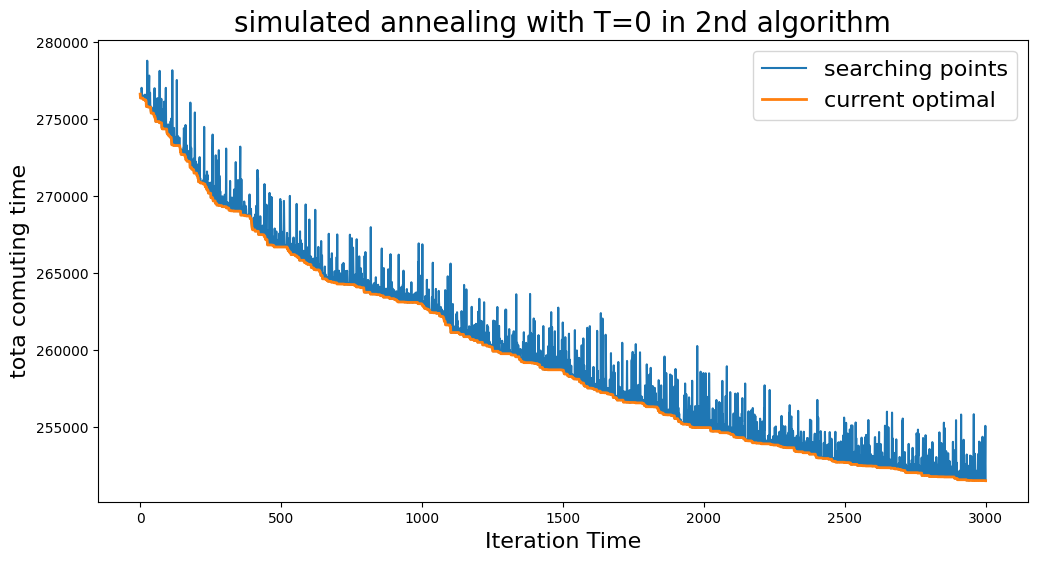

In [28]:
plt.figure(figsize=(12,6))
plt.plot(result, label='searching points')
plt.plot(temp, linewidth=2, label='current optimal')
plt.xlabel('Iteration Time', fontsize=16)
plt.ylabel('tota comuting time',fontsize=16)
plt.legend(fontsize=16)
plt.title('simulated annealing with T=0 in 2nd algorithm', fontsize=20)

In [24]:
costTime_best
temp=[result[0]]
for i in range(len(result)-1):
    if result[i+1]<temp[-1]:
        temp.append(result[i+1])
    else:
        temp.append(temp[-1])


In [11]:
ref_time

276903.29999998916

In [14]:
df_schedule

,0,1,2,3,4,5,6,7,8,9,...,41_stop,42_stop,43_stop,44_stop,45_stop,46_stop,47_stop,48_stop,49_stop,restart_time
0,0.0,2.7,5.4,8.1,10.8,13.5,16.2,18.9,21.6,24.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,135.0
1,5.0,7.7,10.4,13.1,15.8,18.5,21.2,23.9,26.6,29.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,140.0
2,10.0,12.7,15.4,18.1,20.8,23.5,26.2,28.9,31.6,34.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,145.0
3,15.0,17.7,20.4,23.1,25.8,28.5,31.2,33.9,36.6,39.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,150.0
4,20.0,22.7,25.4,28.1,30.8,33.5,36.2,38.9,41.6,44.3,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,155.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,568.6,571.3,572.8,574.3,577.0,578.5,580.0,582.7,585.4,588.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,680.8
119,569.0,571.7,574.4,577.1,578.6,581.3,584.0,586.7,589.4,592.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,699.2
120,572.0,574.7,577.4,580.1,582.8,585.5,588.2,590.9,593.6,596.3,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,702.2
121,579.6,581.1,582.6,585.3,588.0,590.7,592.2,594.9,596.4,599.1,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,689.4


In [10]:
# 
df_schedule.to_csv('../result/df_schedule_al2_SA.csv')


In [23]:
pd.DataFrame(result).to_csv('../result/SA_al2_process.csv')